# Imports and project setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import colors, cm
import glob
from datetime import datetime, timedelta

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union, List

import hoomd
import gsd.hoomd
import freud
import schmeud
from schmeud._schmeud import dynamics as schmeud_dynamics

import sys
import time
import pickle
import gc
import warnings
import copy
import pathlib
from collections import defaultdict

import os
import sys

import signac

from dataclasses import dataclass
from dataclasses_json import dataclass_json

import fresnel
import PIL.Image

In [3]:
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["axes.labelsize"] = "xx-large"

In [4]:
from monk import nb, prep, pair, render, utils, workflow, grid

config = workflow.get_config()

In [5]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'ref_sim_temps': [0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.58, 0.61, 0.64, 0.67, 0.7, 0.75, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0], 'avail_seed': 18, 'alpha_iters': 40, 'dt': 0.001, 'usteps': 1000, '_status': {}}

## Function definitions

In [6]:
def delta_to_phi(delta):
    return 1.2 - delta*0.2

def make_axes_label(ax, label, pos=(0.0, 1.05), fontsize=None):
    ax.text(*pos, label, fontsize=fontsize, transform=ax.transAxes)

In [7]:
def compute_unwrapped_pos_from_deltas(traj):
    ref_snap = traj[0]
    ref_pos = ref_snap.particles.position.copy()
    box = freud.box.Box.from_box(ref_snap.configuration.box)
    pos_shape = ref_pos.shape
    pos = np.zeros((len(traj), *pos_shape), dtype=np.float32)
    pos[0] = ref_pos
    for i, snap in enumerate(traj[1:]):
        next_pos = snap.particles.position.copy()
        pos[i+1] = box.wrap(next_pos - ref_pos) + pos[i]
        ref_pos = next_pos

    return pos

def extract_relative_timesteps(traj):
    
    tsteps = np.zeros(len(traj))
    tstep0 = traj[0].log['Simulation/timestep'][0]
    for i in range(len(traj)):
        tsteps[i] = traj[i].log['Simulation/timestep'][0] - tstep0

    return tsteps


def sisf(pos, k=7.14):

    term = k*np.linalg.norm(pos - pos[0], axis=-1)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return np.mean(np.nan_to_num(np.sin(term)/term, nan=1.0), axis=1)



def is_file_older_than(file, cutoff):
    mtime = datetime.utcfromtimestamp(os.path.getmtime(file))
    if mtime < cutoff:
        return True
    return False


In [8]:
def digitize_mask(x, mu_min, mu_max, bins):
    digs = np.floor((x - mu_min) / (mu_max - mu_min) * bins).astype(np.int32)
    return np.ma.masked_array(digs, mask=(digs < 0) | (digs >= bins))


def digitize_in_bounds(x, mu_min, mu_max, bins):
    digs = digitize_mask(x, mu_min, mu_max, bins)
    return digs[~digs.mask].data


def bin_linspaced_data(x, mu_min, mu_max, bins):
    digs = digitize_in_bounds(x, mu_min, mu_max, bins)
    return np.bincount(digs, minlength=bins)


def pair_excess_entropy_binary(g_a, g_b, f_a, f_b, r, phi):
    dr = r[1] - r[0]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return -2.0*np.pi*phi*f_a*np.sum(np.nan_to_num(g_a*np.log(g_a) - g_a + 1)*r*r)*dr \
                + -2.0*np.pi*phi*f_b*np.sum(np.nan_to_num(g_b*np.log(g_b) - g_b + 1)*r*r)*dr

In [9]:
@njit
def excess_entropy(r, g, dr):
    prelim = (g*np.log(g)-g+1)*r*r*dr
    prelim[np.isnan(prelim)] = 0
    return -2.0*np.pi*np.sum(prelim)

@njit
def local_excess_entropy(r, sfs, dr):
    vol = 4/3*np.pi*(r[-1]**3)
    inv_shell = 1/(4*np.pi*(r**2)*dr)
    out = np.zeros(len(sfs))
    for i in range(len(sfs)):
        sf = sfs[i,::2] + sfs[i,1::2]
        inv_n = 1/np.sum(sf)
        g = sf*inv_shell*inv_n*vol
        out[i] = excess_entropy(r, g, dr)
    return out


@njit
def local_excess_entropy_binary(r, sfs, dr):
    vol = 4/3*np.pi*(r[-1]**3)
    inv_shell = 1/(4*np.pi*(r**2)*dr)
    out = np.zeros(len(sfs))
    for i in range(len(sfs)):
        na = np.sum(sfs[i,::2])
        nb = np.sum(sfs[i,1::2])
        n = na + nb
        inv_na = 1/na
        inv_nb = 1/nb
        g_a = sfs[i,::2]*inv_shell*inv_na*vol
        g_b = sfs[i,1::2]*inv_shell*inv_nb*vol
        out[i] = na/n*excess_entropy(r, g_a, dr) + nb/n*excess_entropy(r, g_b, dr)
    return out

In [10]:
@njit
def local_excess_entropy_density(r, sfs, dr):
    vol = 4/3*np.pi*(r[-1]**3)
    inv_shell = 1/(4*np.pi*(r**2)*dr)
    out = np.zeros(len(sfs))
    for i in range(len(sfs)):
        sf = sfs[i,::2] + sfs[i,1::2]
        inv_n = 1/np.sum(sf)
        g = sf*inv_shell*inv_n*vol
        out[i] = excess_entropy(r, g, dr)/vol/inv_n
    return out


@njit
def local_excess_entropy_binary_density(r, sfs, dr):
    vol = 4/3*np.pi*(r[-1]**3)
    inv_shell = 1/(4*np.pi*(r**2)*dr)
    out = np.zeros(len(sfs))
    for i in range(len(sfs)):
        na = np.sum(sfs[i,::2])
        nb = np.sum(sfs[i,1::2])
        n = na + nb
        inv_na = 1/na
        inv_nb = 1/nb
        g_a = sfs[i,::2]*inv_shell*inv_na*vol
        g_b = sfs[i,1::2]*inv_shell*inv_nb*vol
        out[i] = (na/n*excess_entropy(r, g_a, dr) + nb/n*excess_entropy(r, g_b, dr))*n/vol
    return out
@njit
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

@njit
def local_excess_entropy_binary_density_var(r, sfs, dr, alpha=0.5, taper=(2.0, 1.0)):
    if not (alpha <= 1.0 and alpha >= 0.0):
        raise ValueError("alpha must be between 0 and 1")
    alpha_n = 1 - alpha
    vol = 4/3*np.pi*(r[-1]**3)
    inv_shell = 1/(4*np.pi*(r**2)*dr)
    out = np.zeros(len(sfs))
    log_taper = sigmoid((r - taper[0])/taper[1])
    nlt = 1 - log_taper
    for i in range(len(sfs)):
        na = np.sum(sfs[i,::2])
        nb = np.sum(sfs[i,1::2])
        n = na + nb
        inv_na = 1/na
        inv_nb = 1/nb
        g_a = sfs[i,::2]*inv_shell*inv_na*vol*nlt + log_taper
        g_b = sfs[i,1::2]*inv_shell*inv_nb*vol*nlt + log_taper
        out[i] = (alpha*na/n*excess_entropy(r, g_a, dr) + alpha_n*nb/n*excess_entropy(r, g_b, dr))*n/vol
    return out


@njit
def local_excess_entropy_binary_density_var_exp(r, sfs, dr, alpha=0.5, taper=(2.0, 0.1), end=-1):
    if not (alpha <= 1.0 and alpha >= 0.0):
        raise ValueError("alpha must be between 0 and 1")
    alpha_n = 1 - alpha
    vol = 4/3*np.pi*(r[end]**3)
    inv_shell = 1/(4*np.pi*(r**2)*dr)
    out = np.zeros(len(sfs))
    log_taper = sigmoid((r - taper[0])/taper[1])
    nlt = 1 - log_taper
    for i in range(len(sfs)):
        na = np.sum(sfs[i,::2][:end])
        nb = np.sum(sfs[i,1::2][:end])
        n = na + nb
        inv_na = 1/na
        inv_nb = 1/nb
        g_a = sfs[i,::2]*inv_shell*inv_na*vol*nlt + log_taper
        g_b = sfs[i,1::2]*inv_shell*inv_nb*vol*nlt + log_taper
        out[i] = (alpha*na/n*excess_entropy(r, g_a, dr) + alpha_n*nb/n*excess_entropy(r, g_b, dr))*n/vol
    return out

# Figure 1 - Characterization of systems we analyze

## Compute MSD for systems, A particles, and B particles

In [10]:
def compute_msd_sisf(delta, jobs_iter, overwrite=True):
    print("Delta:", delta)

    os.makedirs(project.fn(f"dynamics/delta-{delta}"), exist_ok=True)

    jobs: List[signac.Project.Job] = list(jobs_iter)

    job0 = jobs[0]

    msd = freud.msd.MSD(mode="direct")

    temps = [utils.extract_between(run, "/temp-", "/traj.gsd") for run in glob.glob(job0.fn("runs/*/traj.gsd"))]
    for temp in temps:
        print("Temp:", temp)

        out_file = project.fn(f"dynamics/delta-{delta}/msd-sisf_temp-{temp}.npz")
        if isinstance(overwrite, datetime):
            if not is_file_older_than(out_file, overwrite):
                print("Skipping because file is too recent")
                continue
        elif not overwrite and os.path.exists(out_file):
            print("Skipping because file exists")
            continue
        

        acc_msd = []
        acc_sisf = []

        acc_msd_A = []
        acc_sisf_A = []

        acc_msd_B = []
        acc_sisf_B = []

        for job in jobs:

            assert isinstance(job, signac.Project.Job)

            run = sorted(glob.glob(job.fn(f"runs/temp-{temp}/traj.gsd")))[0]
            traj = gsd.hoomd.open(run)[-2000:]  # these runs have 4000 data points
            # later half will have relaxed at least a couple tau alpha

            pos = compute_unwrapped_pos_from_deltas(traj)

            time = extract_relative_timesteps(traj)*project.doc["dt"]

            typeid = traj[0].particles.typeid
            A_mask = typeid == 0
            B_mask = typeid == 1

            msd.compute(pos)
            acc_msd.append(msd.msd)
            acc_sisf.append(sisf(pos))

            msd.compute(pos[:, A_mask])
            acc_msd_A.append(msd.msd)
            acc_sisf_A.append(sisf(pos[:, A_mask]))

            msd.compute(pos[:, B_mask])
            acc_msd_B.append(msd.msd)
            acc_sisf_B.append(sisf(pos[:, B_mask]))

        sys_msd = np.mean(acc_msd, axis=0)
        sys_sisf = np.mean(acc_sisf, axis=0)

        sys_msd_A = np.mean(acc_msd_A, axis=0)
        sys_sisf_A = np.mean(acc_sisf_A, axis=0)

        sys_msd_B = np.mean(acc_msd_B, axis=0)
        sys_sisf_B = np.mean(acc_sisf_B, axis=0)

        np.savez(out_file,
                 msd=sys_msd,
                 sisf=sys_sisf,
                 msd_A=sys_msd_A,
                 sisf_A=sys_sisf_A,
                 msd_B=sys_msd_B,
                 sisf_B=sys_sisf_B,
                 time=time)


In [18]:
# from multiprocessing.pool import Pool


# process_pool = Pool(5)

# arg_list = []
for delta, jobs_iter in project.find_jobs(None, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):
    compute_msd_sisf(delta, jobs_iter, overwrite=(datetime.now() - timedelta(hours=4)))
#     arg_list.append((delta, list(jobs_iter)))
# process_pool.starmap(compute_msd_sisf, arg_list)

Delta: 0.0
Temp: 2.00
Skipping because file is too recent
Temp: 0.45
Skipping because file is too recent
Temp: 0.67
Skipping because file is too recent
Temp: 0.75
Skipping because file is too recent
Temp: 0.80
Skipping because file is too recent
Temp: 0.58
Skipping because file is too recent
Temp: 1.40
Skipping because file is too recent
Temp: 0.55
Skipping because file is too recent
Temp: 1.80
Skipping because file is too recent
Temp: 0.53
Skipping because file is too recent
Temp: 0.61
Temp: 1.00
Temp: 0.90
Temp: 0.49
Temp: 1.20
Temp: 0.70
Temp: 1.60
Temp: 0.47
Temp: 0.51
Temp: 0.64
Delta: 0.1
Temp: 0.67
Skipping because file is too recent
Temp: 0.80
Skipping because file is too recent
Temp: 2.26
Skipping because file is too recent
Temp: 0.94
Skipping because file is too recent
Temp: 0.56
Skipping because file is too recent
Temp: 0.73
Skipping because file is too recent
Temp: 0.61
Skipping because file is too recent
Temp: 1.00
Skipping because file is too recent
Temp: 1.51
Skipping be

## Fix missing timesteps

In [44]:


for delta, jobs_iter in project.find_jobs(None, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):

    print("Delta:", delta)

    os.makedirs(project.fn(f"dynamics/delta-{delta}"), exist_ok=True)

    jobs: List[signac.Project.Job] = list(jobs_iter)

    job0 = jobs[0]

    msd = freud.msd.MSD(mode="direct")

    temps = [utils.extract_between(run, "/temp-", "/traj.gsd") for run in glob.glob(job0.fn("runs/*/traj.gsd"))]
    for temp in temps:
        print("Temp:", temp)

        out_file = project.fn(f"dynamics/delta-{delta}/msd-sisf-v2_temp-{temp}.npz")
        in_file = project.fn(f"dynamics/delta-{delta}/msd-sisf_temp-{temp}.npz")

        run = sorted(glob.glob(job0.fn(f"runs/temp-{temp}/traj.gsd")))[0]
        traj = gsd.hoomd.open(run)[-2000:]

        time = extract_relative_timesteps(traj)*project.doc["dt"]

        data = np.load(in_file)

        np.savez(out_file,
                 msd=data["msd"],
                 sisf=data["sisf"],
                 msd_A=data["msd_A"],
                 sisf_A=data["sisf_A"],
                 msd_B=data["msd_B"],
                 sisf_B=data["sisf_B"],
                 time=time)


Delta: 0.0
Temp: 2.00
Temp: 0.45
Temp: 0.67
Temp: 0.75
Temp: 0.80
Temp: 0.58
Temp: 1.40
Temp: 0.55
Temp: 1.80
Temp: 0.53
Temp: 0.61
Temp: 1.00
Temp: 0.90
Temp: 0.49
Temp: 1.20
Temp: 0.70
Temp: 1.60
Temp: 0.47
Temp: 0.51
Temp: 0.64
Delta: 0.1
Temp: 0.67
Temp: 0.80
Temp: 2.26
Temp: 0.94
Temp: 0.56
Temp: 0.73
Temp: 0.61
Temp: 1.00
Temp: 1.51
Temp: 0.69
Temp: 0.88
Temp: 2.51
Temp: 2.01
Temp: 1.13
Temp: 1.76
Temp: 0.59
Temp: 1.25
Temp: 0.64
Temp: 0.77
Temp: 0.84
Delta: 0.2
Temp: 1.46
Temp: 2.60
Temp: 0.76
Temp: 0.80
Temp: 1.95
Temp: 0.83
Temp: 0.94
Temp: 0.89
Temp: 1.04
Temp: 0.73
Temp: 1.63
Temp: 1.14
Temp: 2.28
Temp: 0.99
Temp: 1.09
Temp: 0.86
Temp: 1.30
Temp: 2.93
Temp: 1.22
Temp: 3.25
Delta: 0.3
Temp: 1.98
Temp: 1.47
Temp: 1.34
Temp: 1.54
Temp: 3.51
Temp: 1.41
Temp: 2.64
Temp: 2.20
Temp: 1.65
Temp: 1.03
Temp: 3.08
Temp: 0.99
Temp: 3.95
Temp: 1.27
Temp: 1.08
Temp: 1.12
Temp: 1.21
Temp: 4.39
Temp: 1.76
Temp: 1.16
Delta: 0.4
Temp: 1.92
Temp: 5.03
Temp: 1.82
Temp: 4.40
Temp: 3.77
Temp: 1.42

## Plot Diffusion coefficients and SISF

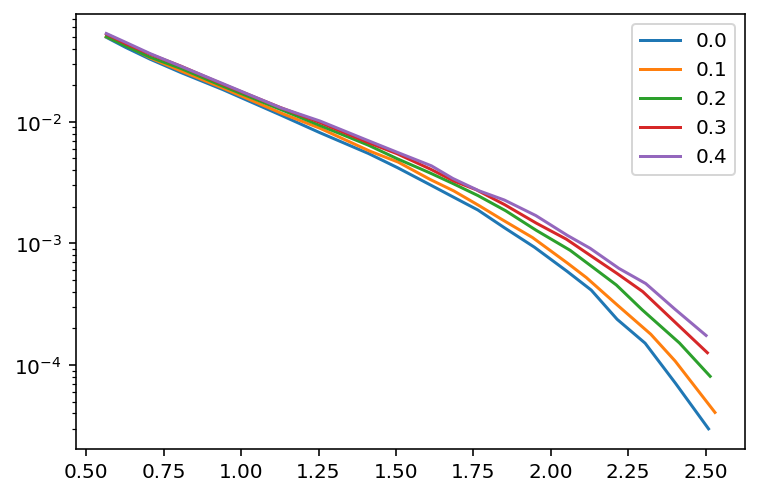

In [243]:

for dir in sorted(glob.glob(project.fn("dynamics/*/"))):
    delta = float(utils.extract_between(dir, "dynamics/delta-", "/"))
    temps = []
    Ds = []
    for file in sorted(glob.glob(dir + 'msd-sisf_*'))[::1]:
        temp = float(utils.extract_between(file, "temp-", ".npz"))
        temps.append(1/temp*np.square(1/(1-delta*2**(1/6))*delta_to_phi(delta)**(1/3)))
        
        data = np.load(file)
        mid = len(data["time"])//2
        params = np.polyfit(data["time"][mid:], data["msd_A"][mid:], 1)
        Ds.append(params[0]/6)
    plt.plot(temps, Ds, label=f"{delta}")
plt.legend()
plt.yscale('log')

In [ ]:
delta_to_phi(0.4)

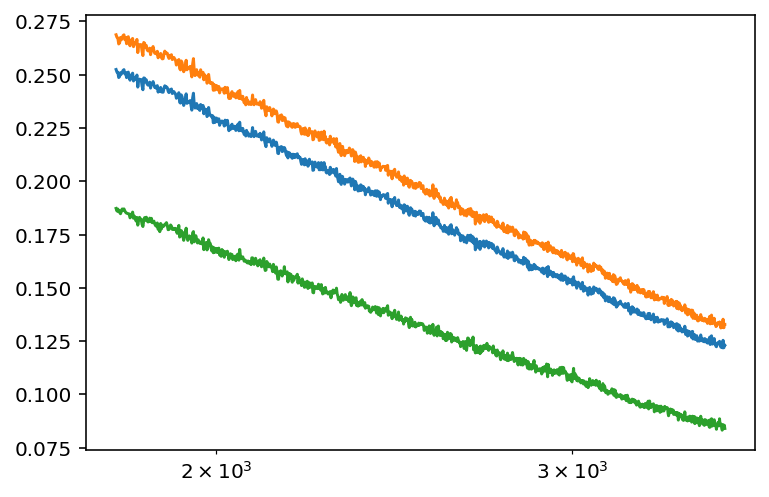

In [32]:
mid = len(data["time"])//2
plt.plot(data["time"][mid:], data["sisf"][mid:])
plt.plot(data["time"][mid:], data["sisf_A"][mid:])
plt.plot(data["time"][mid:], data["sisf_B"][mid:])
plt.xscale('log')

In [29]:
mid

1000

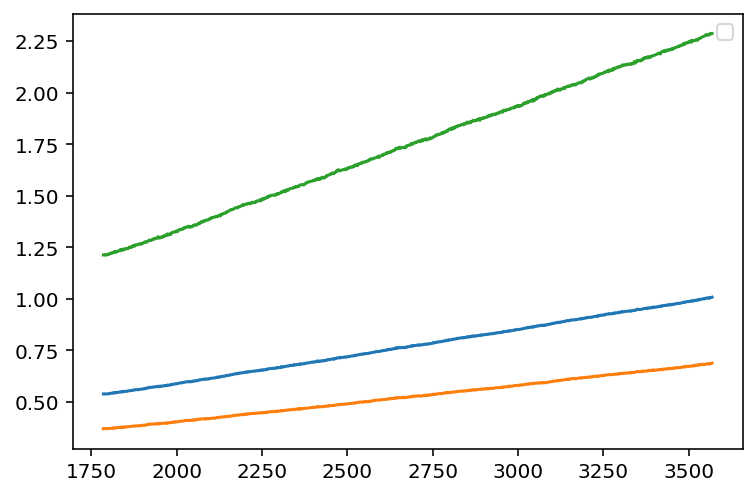

In [34]:
mid = len(data["time"])//2
plt.plot(data["time"][mid:], data["msd"][mid:])
plt.plot(data["time"][mid:], data["msd_A"][mid:])
plt.plot(data["time"][mid:], data["msd_B"][mid:])
# plt.xscale('log')
# plt.yscale('log')
plt.legend()

msd
msd_A
msd_B


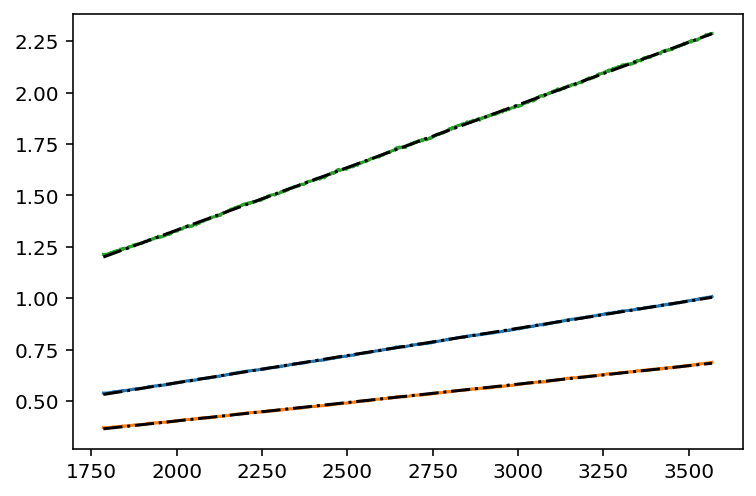

In [44]:
for key in [k for k in data.keys() if "msd" in k]:
    print(key)
    plt.plot(data["time"][mid:], data[key][mid:])

    params = np.polyfit(data["time"][mid:], data[key][mid:], 1)
    plt.plot(data["time"][mid:], np.polyval(params, data["time"][mid:]), color="k", linestyle="-.")

Looks good above!

In [14]:
len(data["sisf"])

2000

In [18]:
file

'/media/ian/Data2/monk/mlj-production/dynamics/delta-0.0/msd-sisf-v2_temp-0.45.npz'

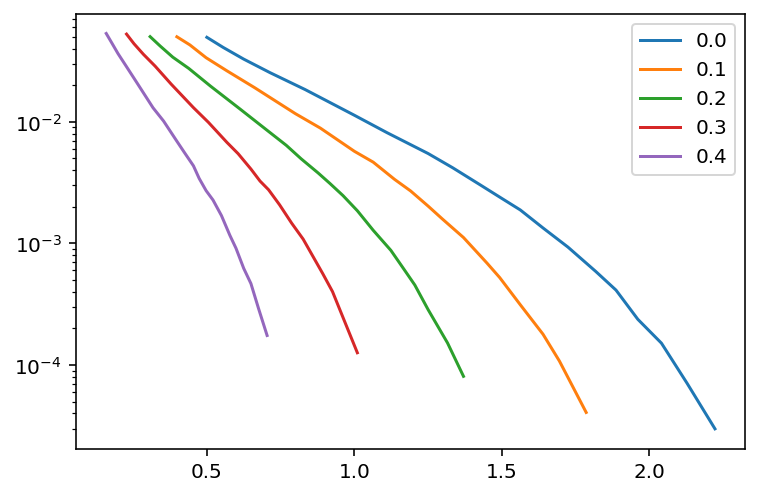

In [11]:
out_data = {}

for dir in sorted(glob.glob(project.fn("dynamics/*/"))):
    delta = utils.extract_between(dir, "dynamics/delta-", "/")
    temps = []
    Ds = []
    for file in sorted(glob.glob(dir + 'msd-sisf_*'))[::1]:
        temp = float(utils.extract_between(file, "temp-", ".npz"))
        temps.append(1/temp)
        
        data = np.load(file)
        mid = len(data["time"])//2
        params = np.polyfit(data["time"][mid:], data["msd_A"][mid:], 1)
        Ds.append(params[0]/6)
    plt.plot(temps, Ds, label=f"{delta}")
    out_data[delta] = {"inv_temp": temps, "D": Ds}
plt.legend()
plt.yscale('log')

In [12]:
np.savez(project.fn("dynamics/diffusion_coefficients.npz"), **out_data)

In [17]:
np.load(project.fn("dynamics/diffusion_coefficients.npz"), allow_pickle=True)

array({'inv_temp': [2.2222222222222223, 2.127659574468085, 2.0408163265306123, 1.9607843137254901, 1.8867924528301885, 1.8181818181818181, 1.7241379310344829, 1.639344262295082, 1.5625, 1.4925373134328357, 1.4285714285714286, 1.3333333333333333, 1.25, 1.1111111111111112, 1.0, 0.8333333333333334, 0.7142857142857143, 0.625, 0.5555555555555556, 0.5], 'D': [2.9831739976659164e-05, 7.069635228085611e-05, 0.00015103996146286055, 0.00023732295550124775, 0.00041254317533254717, 0.0005872922519146438, 0.0009302933276796943, 0.0013385552601304655, 0.0018812426459132927, 0.002400873763773625, 0.00300427608528793, 0.004182624159648855, 0.00547771778333888, 0.008119156094733853, 0.011306627427853976, 0.018379655052068403, 0.025318192018829358, 0.03272234529642195, 0.04081962526240766, 0.04947558147507412]},
      dtype=object)

In [137]:
example_job = list(project.find_jobs({"delta": 0.0}))[0]
filename = example_job.fn("short_runs/temp-0.45/fire_traj.gsd")
with gsd.hoomd.open(name=filename, mode="rb") as gsd_file:
    snap = gsd_file[0]

box = snap.configuration.box
pos = snap.particles.position
cond = (pos[:, 0] < 0.0) | (pos[:, 1] < 0.0) | (pos[:, 2] < 0)

N = len(pos[cond])
particle_types = snap.particles.typeid[cond]
colors = np.empty((N, 3))
diams = snap.particles.diameter[cond]

# # Color by typeid
colors[particle_types == 0] = fresnel.color.linear([.95, 0, 0]) # A type
colors[particle_types == 1] = fresnel.color.linear([0, .95, 0]) # B type
# colors[particle_types == 2] = fresnel.color.linear([0, 0, .95]) # C type

In [162]:
light = fresnel.light.Light((1, 1, 1))
fill_light = fresnel.light.Light((0, 0, 1), color=(0.2, 0.2, 0.2), theta=3.141592)
scene = fresnel.Scene(lights=[light, fill_light])

# Spheres for every particle in the system
geometry = fresnel.geometry.Sphere(scene, N=N, radius=diams/2)
geometry.position[:] = pos[cond]
geometry.material = fresnel.material.Material(roughness=1.0)
geometry.outline_width = 0.05

# lights = fresnel.light.rembrandt()
# scene.lights = lights

# light = fresnel.light.Light((.1, .1, .1))
# scene.lights = [light]

# use color instead of material.color
geometry.material.primitive_color_mix = 1.0
geometry.color[:] = fresnel.color.linear(colors)

In [163]:
# create box in fresnel
# fresnel.geometry.Box(scene, box, box_radius=.07)

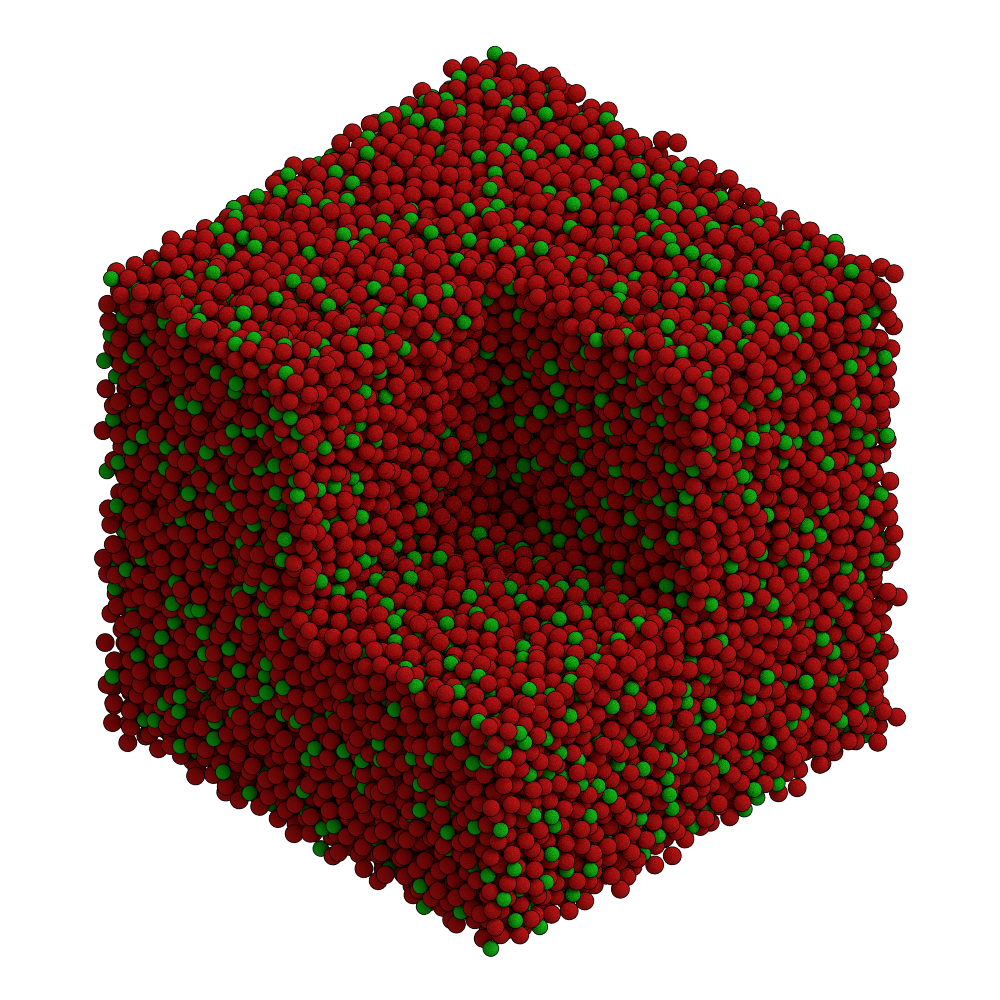

In [182]:
scene.camera = fresnel.camera.Orthographic.fit(scene)
image = fresnel.pathtrace(scene, w=1000, h=1000, light_samples=5)
# fresnel.preview(scene)
image

In [183]:
pil_image = PIL.Image.fromarray(image[:], mode='RGBA')
pil_image.save('system-fire_delta-0.0_temp-0.45.png')

### Softness field

In [10]:
example_job = list(project.find_jobs({"delta": 0.0}))[0]
filename = example_job.fn("short_runs/temp-0.45/fire_traj.gsd")
soft_file = example_job.fn("short_runs/temp-0.45/struct-descr.parquet")
df = pd.read_parquet(soft_file)
with gsd.hoomd.open(name=filename, mode="rb") as gsd_file:
    snap = gsd_file[0]

box = snap.configuration.box
pos = snap.particles.position
cond = (pos[:, 0] < 0.0) | (pos[:, 1] < 0.0) | (pos[:, 2] < 0)
N = len(pos)
# N = len(pos[cond])
particle_types = snap.particles.typeid
colors = np.empty((N, 3))
diams = snap.particles.diameter

data = df[df.frame == 0]
idxs = data.tag.to_numpy()

cmap = cm.jet
norm = mpl.colors.Normalize(vmin=-data["entropy-binary-opt"].max(), vmax=-data["entropy-binary-opt"].min())

# # Color by typeid
colors[data.tag.to_numpy()] = cmap(norm(-data["entropy-binary-opt"].to_numpy()))[:,:3] # A type
colors[particle_types == 1] = fresnel.color.linear([0, 0, 0]) # B type
# colors[particle_types == 2] = fresnel.color.linear([0, 0, .95]) # C type

In [11]:
data

frame    tag  type      phop  softness   entropy  entropy-binary  \
0          0      0     0  0.000713  0.118890 -2.236004       -3.457283   
1          0      1     0  0.000862 -0.385413 -2.102081       -2.999533   
2          0      2     0  0.014712 -0.009888 -2.508852       -4.182886   
3          0      3     0  0.000485 -0.710552 -2.242270       -3.260788   
4          0      4     0  0.001081 -0.273929 -3.410165       -6.389401   
...      ...    ...   ...       ...       ...       ...             ...   
32763      0  32763     0  0.000877 -0.581979 -3.304126       -3.975871   
32764      0  32764     0  0.028540  0.294341 -1.957359       -3.034011   
32765      0  32765     0  0.000653 -0.909013 -3.114881       -4.863638   
32766      0  32766     0  0.002848 -0.526956 -2.992895       -4.158578   
32767      0  32767     0  0.002096 -0.560005 -1.687011       -3.012155   

       entropy-binary-opt  rearrang  
0               -2.535503     False  
1               -2.505927     False  
2               -2.655738     False  
3               -2.456938     False  
4               -3.671592     False  
...                   ...       ...  
32763           -2.691977     False  
32764           -2.312628     False  
32765           -3.031701     False  
32766           -2.953452     False  
32767           -2.417849     False  

[26215 rows x 9 columns]

In [12]:
cmap(norm(data.softness.to_numpy()))

array([[0. , 0. , 0.5, 1. ],
       [0. , 0. , 0.5, 1. ],
       [0. , 0. , 0.5, 1. ],
       ...,
       [0. , 0. , 0.5, 1. ],
       [0. , 0. , 0.5, 1. ],
       [0. , 0. , 0.5, 1. ]])

In [13]:
colors[data.tag.to_numpy()]

array([[0.        , 0.72352941, 1.        ],
       [0.        , 0.69215686, 1.        ],
       [0.        , 0.84901961, 1.        ],
       ...,
       [0.30044276, 1.        , 0.66729918],
       [0.23719165, 1.        , 0.73055028],
       [0.        , 0.58235294, 1.        ]])

In [14]:
# pos = pos[cond]
colors = colors[cond]
diams = diams[cond]
N = len(pos[cond])

light = fresnel.light.Light((1, 1, 1))
fill_light = fresnel.light.Light((0, 0, 1), color=(0.2, 0.2, 0.2), theta=3.141592)
scene = fresnel.Scene(lights=[light, fill_light])

# Spheres for every particle in the system
geometry = fresnel.geometry.Sphere(scene, N=N, radius=diams/2)
geometry.position[:] = pos[cond]
geometry.material = fresnel.material.Material(roughness=1.0)
geometry.outline_width = 0.05

# lights = fresnel.light.rembrandt()
# scene.lights = lights

# light = fresnel.light.Light((.1, .1, .1))
# scene.lights = [light]

# use color instead of material.color
geometry.material.primitive_color_mix = 1.0
geometry.color[:] = fresnel.color.linear(colors)

In [15]:
# create box in fresnel
# fresnel.geometry.Box(scene, box, box_radius=.07)

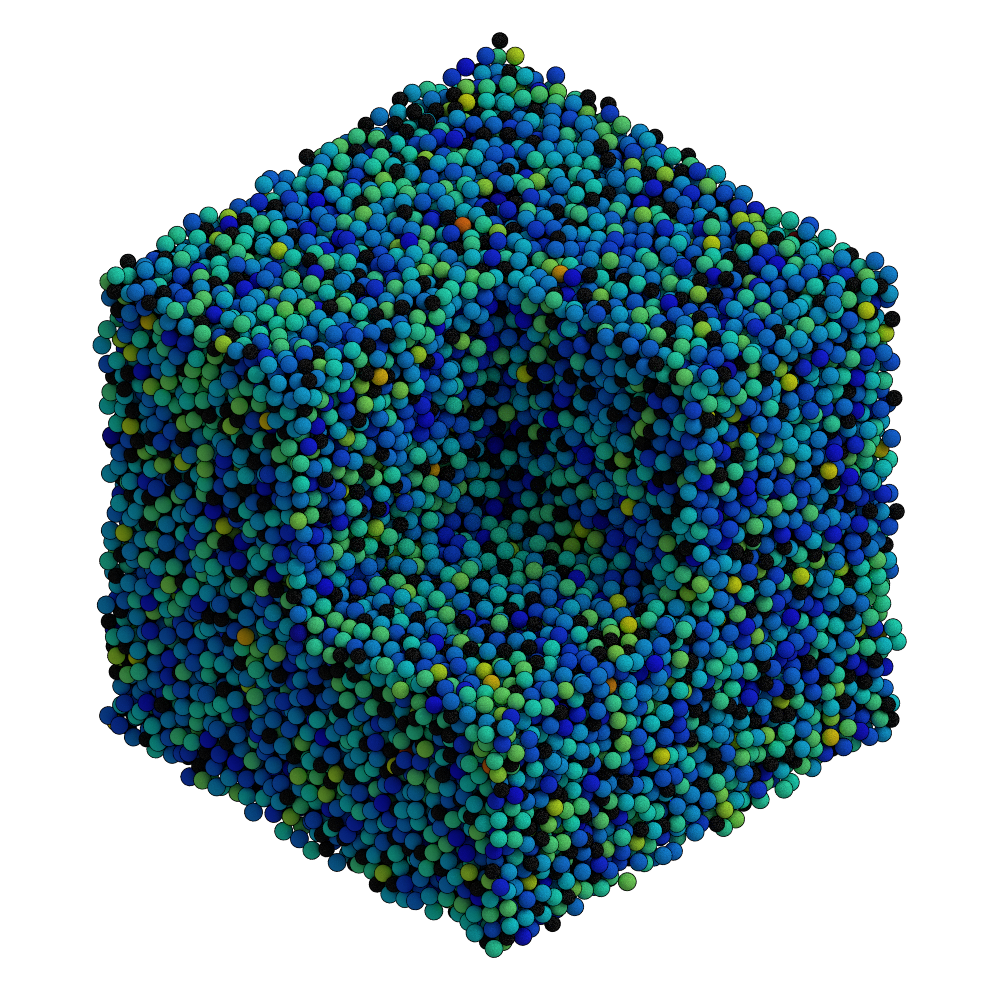

In [16]:
scene.camera = fresnel.camera.Orthographic.fit(scene)
image = fresnel.pathtrace(scene, w=1000, h=1000, light_samples=10)
# fresnel.preview(scene)
image

## Compute $g(r)$ for systems

In [264]:
for delta, jobs_iter in project.find_jobs(None, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):

    # Create a freud compute object (RDF is the canonical example)
    rdf = freud.density.RDF(bins=300, r_max=3)

    for job in jobs_iter:

        run = sorted(glob.glob(job.fn("short_runs/temp-*/traj.gsd")))[0]
        print(run)

        # Load a GSD trajectory (see docs for other formats)
        traj = gsd.hoomd.open(run, 'rb')
        for frame in traj:
            rdf.compute(system=frame, reset=False)

    # Get bin centers, RDF data from attributes
    r = rdf.bin_centers
    rdf = rdf.rdf

    np.savez(project.fn(f"structure/rdf_delta-{delta:.1f}.npz"), r=r, y=rdf)

/media/ian/Data2/monk/mlj-production/workspace/e0e449dbb710b9bd88a01339bcca2881/short_runs/temp-0.45/traj.gsd
/media/ian/Data2/monk/mlj-production/workspace/7258b25c27a73f4e5d0f06642c8733a3/short_runs/temp-0.45/traj.gsd
/media/ian/Data2/monk/mlj-production/workspace/1fd668d1992cea34bb8de5b9cf4bc990/short_runs/temp-0.45/traj.gsd
/media/ian/Data2/monk/mlj-production/workspace/f595e61455c7afd831e594cb06e13386/short_runs/temp-0.56/traj.gsd
/media/ian/Data2/monk/mlj-production/workspace/7a42158b0a5d86f088865f9872fb2cda/short_runs/temp-0.56/traj.gsd
/media/ian/Data2/monk/mlj-production/workspace/45c99c3929afad3f2bd1bff09da3776c/short_runs/temp-0.56/traj.gsd
/media/ian/Data2/monk/mlj-production/workspace/314a0d8f96f7c452d5df3fac7ec93728/short_runs/temp-0.73/traj.gsd
/media/ian/Data2/monk/mlj-production/workspace/a298a48087d6d3fb1c9cddeef7cd82a8/short_runs/temp-0.73/traj.gsd
/media/ian/Data2/monk/mlj-production/workspace/72fe51e16712cb785b06a92bb65cb42d/short_runs/temp-0.73/traj.gsd
/media/ian

## Plot MLJ potential curves

In [11]:
def mlj_pot(r, delta):
    dsigma = 1.0 - delta*2**(-1/6)
    return 4*((dsigma/(r-delta))**12 - (dsigma/(r-delta))**6)

In [24]:
def plot_mlj_pot(ax, legend=True):
    r = np.linspace(0.95, 2.3, 400)
    cmap = cm.jet
    norm = mpl.colors.Normalize(vmin=0, vmax=0.4)
    for delta in np.linspace(0.0, 0.4, 5):
        ax.plot(r, mlj_pot(r, delta), label=f"{delta:.1f}", color=cmap(norm(delta)))
        ax.set_ylim(-1.2, 0.4)
    if legend:
        ax.legend(title=r"$\Delta$")
    ax.set_xlabel(r"$r [\sigma]$")
    ax.set_ylabel(r"$V(r) [\epsilon]$")

def plot_diffusion_coefficient(ax, data, legend=True):
    cmap = cm.jet
    norm = mpl.colors.Normalize(vmin=0, vmax=0.4)
    for delta, d in data.items():
        ax.plot(d[()]["inv_temp"], d[()]["D"], label=f"{delta}", color=cmap(norm(float(delta))))
    if legend:
        ax.legend(title=r"$\Delta$")
    ax.set_yscale('log')
    ax.set_xlabel(r"$1/T$")
    ax.set_ylabel(r"$D_A$")

def plot_system(ax, filename):
    pil_image = PIL.Image.open(filename)
    ax.set_axis_off()
    ax.imshow(pil_image)

def plot_rdf(ax, folder, legend=True):
    cmap = cm.jet
    norm = mpl.colors.Normalize(vmin=0, vmax=0.4)
    for filename in sorted(glob.glob(folder + "/rdf_delta*.npz")):
        print(filename)
        delta = float(utils.extract_between(filename, "delta-", ".npz"))
        data = np.load(filename)
        ax.plot(data["r"], data["y"], label=f"{delta:.1f}", color=cmap(norm(delta)))
    if legend:
        ax.legend(title=r"$\Delta$")
    plt.xlim(0.7, 3.0)
    plt.xlabel(r"$r$")
    plt.ylabel(r"$g(r)$")

## Final Plot

/media/ian/Data2/monk/mlj-production/structure/rdf_delta-0.0.npz
/media/ian/Data2/monk/mlj-production/structure/rdf_delta-0.1.npz
/media/ian/Data2/monk/mlj-production/structure/rdf_delta-0.2.npz
/media/ian/Data2/monk/mlj-production/structure/rdf_delta-0.3.npz
/media/ian/Data2/monk/mlj-production/structure/rdf_delta-0.4.npz


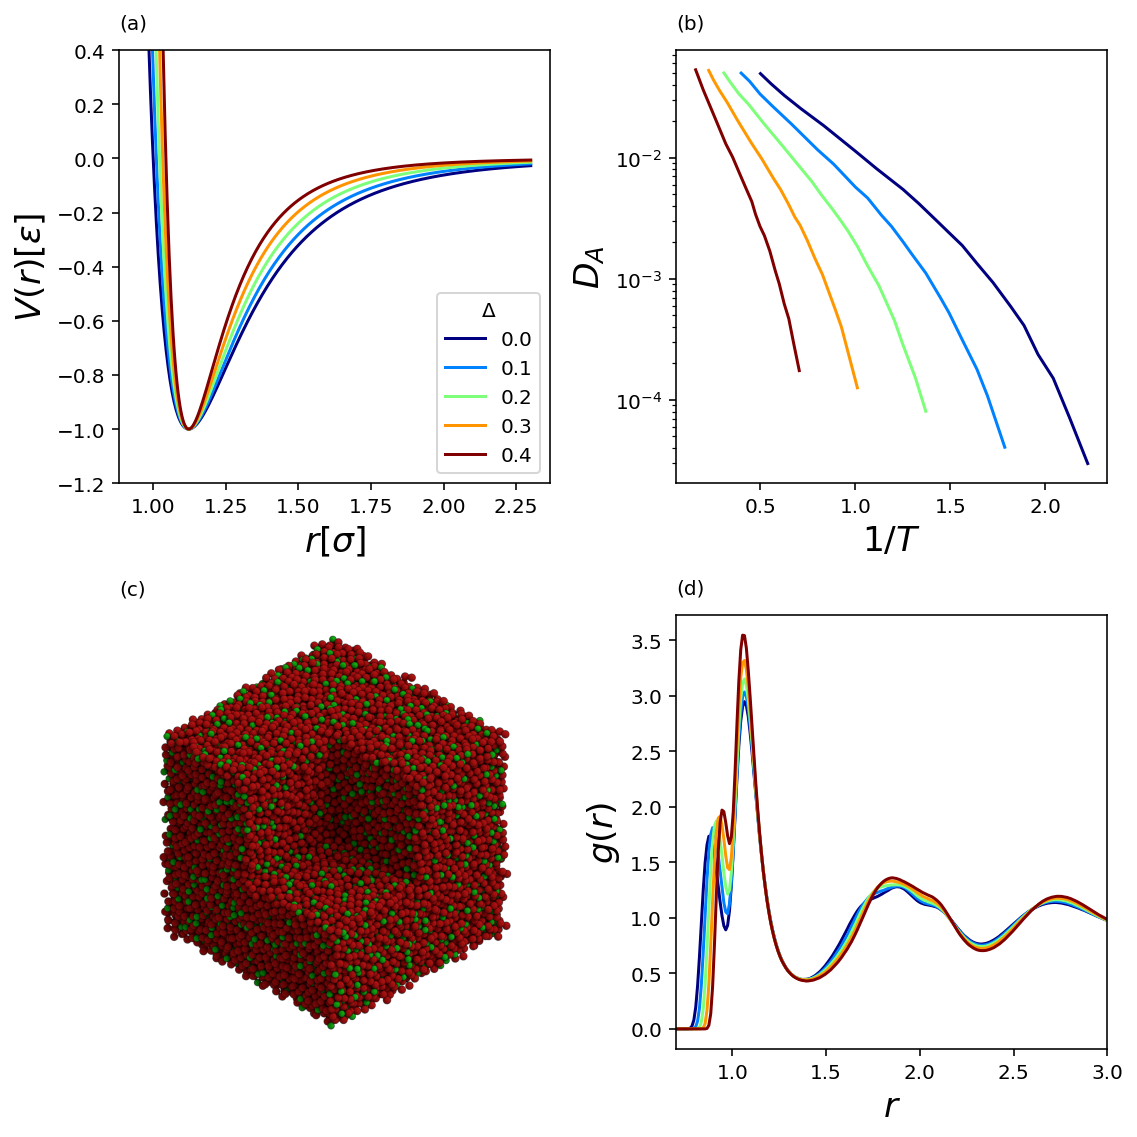

In [52]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8), tight_layout=True)

plot_mlj_pot(axs[0, 0])
make_axes_label(axs[0, 0], "(a)")

plot_diffusion_coefficient(axs[0, 1], np.load(project.fn("dynamics/diffusion_coefficients.npz"), allow_pickle=True), legend=False)
make_axes_label(axs[0, 1], "(b)")

plot_system(axs[1, 0], "system-fire_delta-0.0_temp-0.45.png")
make_axes_label(axs[1, 0], "(c)")

plot_rdf(axs[1, 1], project.fn("structure"), legend=False)
make_axes_label(axs[1, 1], "(d)")

plt.savefig("fig1.png", dpi=200)

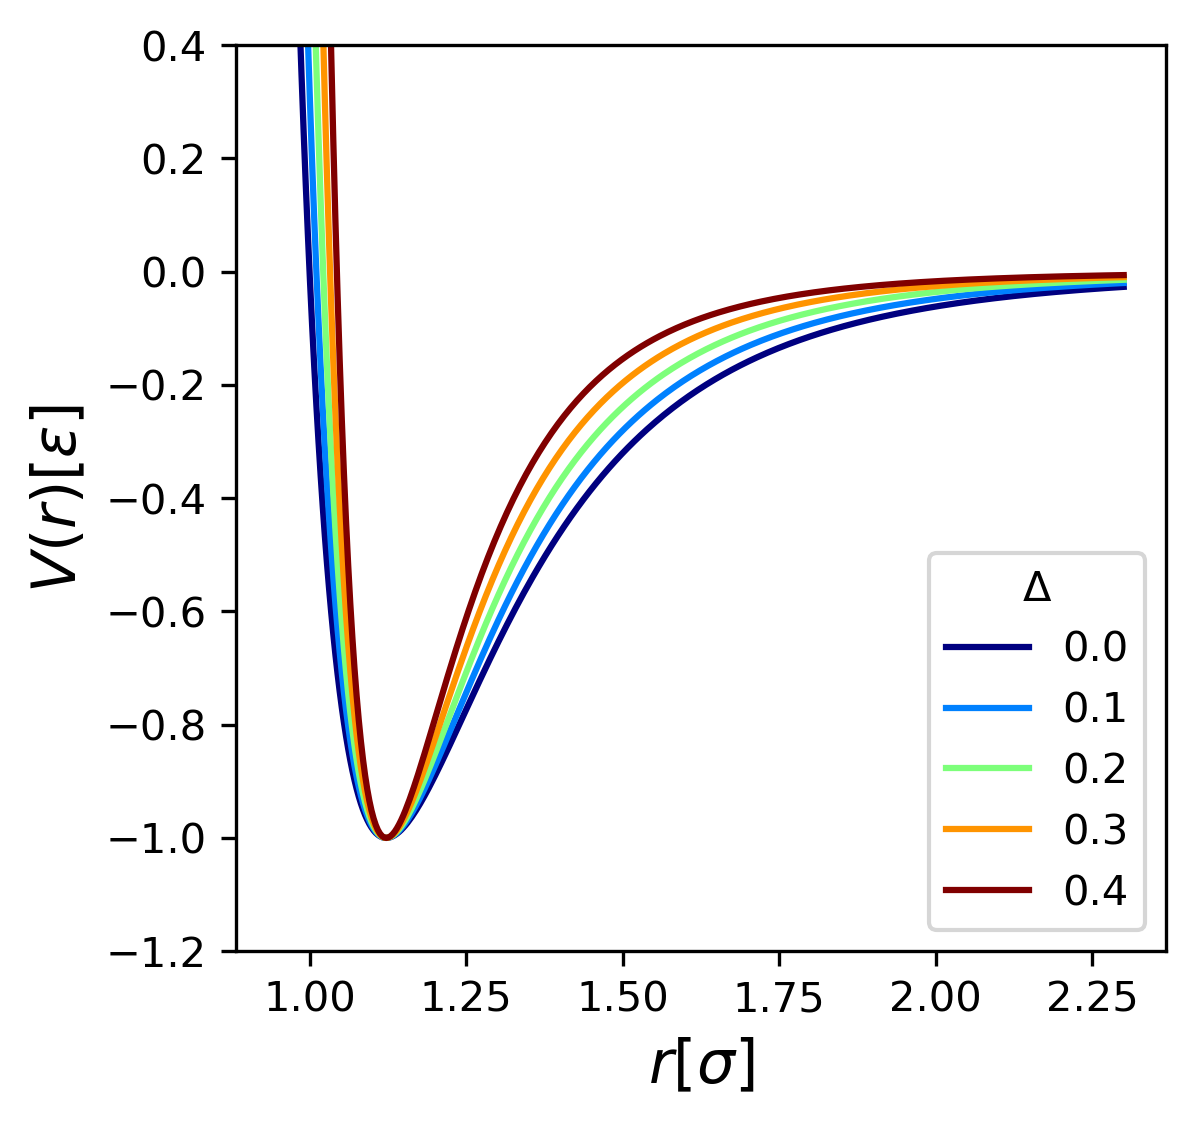

In [20]:
fig, ax = plt.subplots(figsize=(4,4), dpi=150)

plot_mlj_pot(ax)

# Figure 2 - Reduced diffusion coefficients as a function of entropy and excess entropy

In [399]:

for delta, jobs_iter in project.find_jobs(None, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):

    print(delta)

    jobs = list(jobs_iter)

    with open(project.fn(f"softness_pipelines/delta-{delta:.1f}/pipe_ss-0_ts-10.pickle"), "rb") as f:
        pipeline = pickle.load(f)
    pipe = pipeline["pipe"]

    mean_softs = defaultdict(list)

    temps = set()

    job0 = jobs[0]
    for job in jobs:
        for file in sorted(glob.glob(job.fn("short_runs/temp-*/sfs.parquet"))):
            temp = float(utils.extract_between(file, "temp-", "/sfs.parquet"))
            temps.add(temp)
            df = pd.read_parquet(file)
            df = df[df["type"] == 0]

            mean_softness = pipe.decision_function(list(df["sf"]))

            mean_softs[temp].append(mean_softness)
    
    output_temps = np.array(sorted(temps))
    output_mean_softs = np.array([np.mean(mean_softs[temp]) for temp in output_temps])

    np.savez(project.fn(f"structure/mean-soft_delta-{delta:.1f}.npz"), temps=output_temps, mean_softs=output_mean_softs)
    

0.0
0.1
0.2
0.3
0.4


In [398]:

for delta, jobs_iter in project.find_jobs(None, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):

    print(delta)

    out_data = {}

    jobs = list(jobs_iter)

    job0 = jobs[0]
    phi = job0.sp["phi"]
    for run in sorted(glob.glob(job0.fn("short_runs/temp-*/traj.gsd"))):
        rdf = freud.density.RDF(bins=500, r_max=5)

        temp = float(utils.extract_between(run, "temp-", "/traj.gsd"))
        for job in jobs:
            run = job.fn(f"short_runs/temp-{temp:.2f}/traj.gsd")
            # Load a GSD trajectory (see docs for other formats)
            traj = gsd.hoomd.open(run, 'rb')[::10]
            for frame in traj:
                rdf.compute(system=frame, reset=False)
        out_data[temp] = {"r": rdf.bin_centers, "g": rdf.rdf}

    with open(project.fn(f"structure/excess-entropy_delta-{delta:.1f}.pickle"), "wb") as f:
        pickle.dump(out_data, f)

    

0.0
0.1
0.2
0.3
0.4


In [23]:

for delta, jobs_iter in project.find_jobs(None, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):

    print(delta)

    out_data = {}

    jobs = list(jobs_iter)

    r = np.linspace(0.0, 5.0, 500, endpoint=False)
    dr = (r[1] - r[0])
    r += dr / 2.0
    shell = 4.0*np.pi*r*r*dr
    phi = 1.2
    vol = 4.0/3.0*np.pi*r[-1]**3

    job0 = jobs[0]
    phi = job0.sp["phi"]
    for run in sorted(glob.glob(job0.fn("short_runs/temp-*/traj.gsd"))):

        hist_a = np.zeros_like(r)
        hist_b = np.zeros_like(r)

        temp = float(utils.extract_between(run, "temp-", "/traj.gsd"))
        for job in jobs:
            run = job.fn(f"short_runs/temp-{temp:.2f}/traj.gsd")
            # Load a GSD trajectory (see docs for other formats)
            traj = gsd.hoomd.open(run, 'rb')[::10]
            for frame in traj:
                nlist_query = freud.locality.AABBQuery.from_system(frame)
                nlist = nlist_query.query(
                    frame.particles.position[frame.particles.typeid == 0],
                    dict(mode="ball", r_min=0.1, r_max=5.0)
                    ).toNeighborList()
                dist_a = nlist.distances[frame.particles.typeid[nlist.point_indices] == 0]
                dist_b = nlist.distances[frame.particles.typeid[nlist.point_indices] == 1]
        
        hist_a += bin_linspaced_data(dist_a, 0.0, 5.0, 500)
        hist_b += bin_linspaced_data(dist_b, 0.0, 5.0, 500)
        n_a = np.sum(hist_a)
        n_b = np.sum(hist_b)
        g_a = hist_a*vol/n_a/shell
        g_b = hist_b*vol/n_b/shell
        excess_entropy = pair_excess_entropy_binary(g_a, g_b, 0.8, 0.2, r, phi)

        out_data[temp] = dict(r=r, g_a=g_a, g_b=g_b, n_a=n_a, n_b=n_b, excess_entropy=excess_entropy)

    with open(project.fn(f"structure/excess-entropy-binary_delta-{delta:.1f}.pickle"), "wb") as f:
        pickle.dump(out_data, f)

    

0.0
0.1
0.2
0.3
0.4


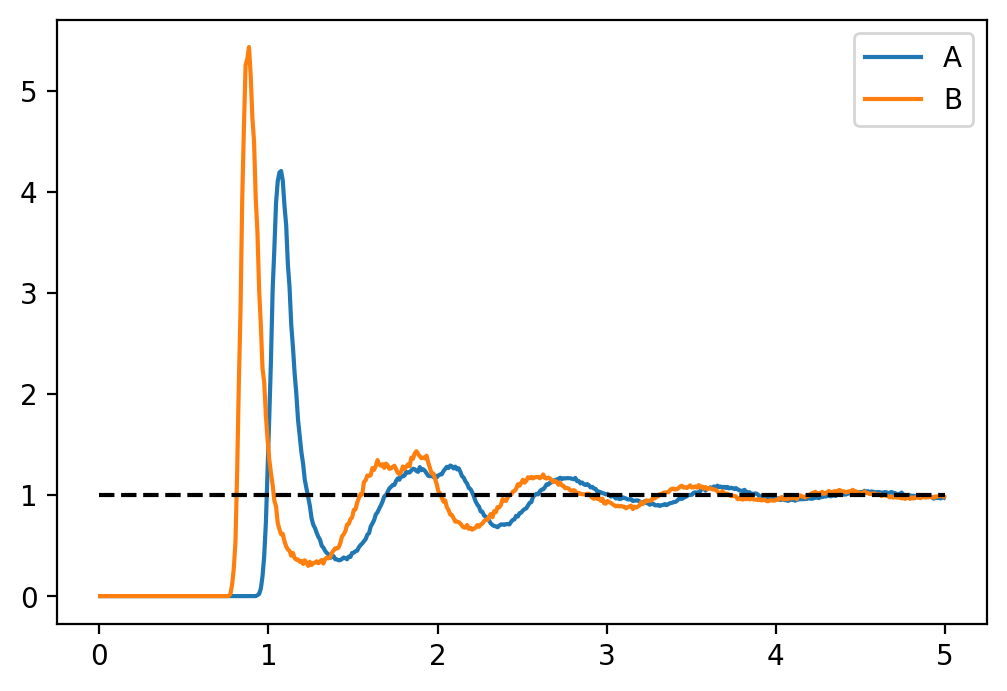

In [13]:
r = np.linspace(0.0, 5.0, 500, endpoint=False)
dr = (r[1] - r[0])
r += dr / 2.0
shell = 4.0*np.pi*r*r*dr
phi = 1.2
vol = 4.0/3.0*np.pi*r[-1]**3
g_a = hist_a*vol/np.sum(hist_a)/shell
g_b = hist_b*vol/np.sum(hist_b)/shell
excess_entropy = pair_excess_entropy_binary(g_a, g_b, 0.8, 0.2, r, phi)
plt.plot(r, g_a, label="A")
plt.plot(r, g_b, label="B")
plt.hlines(1.0, 0.0, 5.0, linestyles="dashed", color="k")
plt.legend()

In [31]:
def pair_excess_entropy(g, r, phi):
    dr = r[1] - r[0]
    return -2.0*np.pi*phi*np.sum(np.nan_to_num(g*np.log(g) - g + 1)*r*r)*dr

def plot_reduced_diffusion_coefficient_softness(ax, diff_data, soft_folder, legend=True):
    cmap = cm.jet
    norm = mpl.colors.Normalize(vmin=0, vmax=0.4)
    
    for delta, d in diff_data.items():
        phi = delta_to_phi(float(delta))
        soft_data = np.load(soft_folder + f"/mean-soft_delta-{delta}.npz")
        ax.plot(soft_data["mean_softs"], np.array(d[()]["D"])*phi**(1/3)*np.sqrt(d[()]["inv_temp"]), label=f"{delta}", color=cmap(norm(float(delta))))
    if legend:
        ax.legend(title=r"$\Delta$")
    ax.set_yscale('log')
    ax.set_xlabel(r"$\langle S \rangle$")
    ax.set_ylabel(r"$D^*_A$")


def plot_reduced_diffusion_coefficient_excess_entropy(ax, diff_data, excess_entropy_folder, legend=True):
    cmap = cm.jet
    norm = mpl.colors.Normalize(vmin=0, vmax=0.4)
    
    for delta, d in diff_data.items():
        phi = delta_to_phi(float(delta))
        with open(excess_entropy_folder + f"/excess-entropy-binary_delta-{delta}.pickle", "rb") as f:
            excess_entropy_data = pickle.load(f)
        plot_data = []
        for temp, data in excess_entropy_data.items():
            plot_data.append(excess_entropy_data[temp]["excess_entropy"])
        ax.plot(np.array(plot_data), np.array(d[()]["D"])*phi**(1/3)*np.sqrt(d[()]["inv_temp"]), label=f"{delta}", color=cmap(norm(float(delta))))
    if legend:
        ax.legend(title=r"$\Delta$")
    ax.set_yscale('log')
    ax.set_xlabel(r"$s^{(2)}$")
    # ax.set_ylabel(r"$D^*_A$")



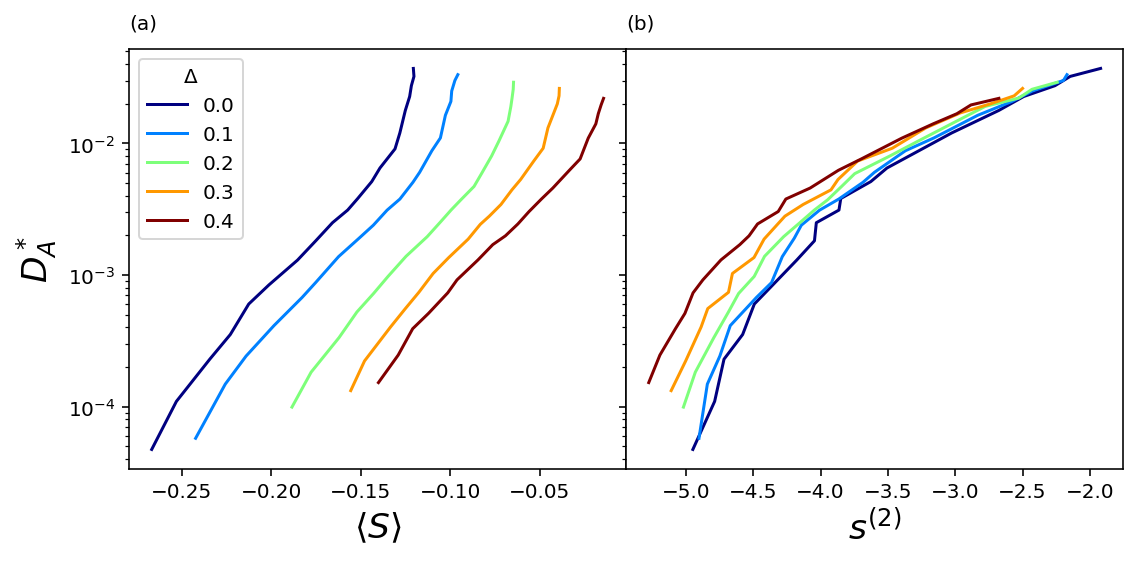

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True, sharey=True, gridspec_kw={'hspace': 0, 'wspace': 0})
plot_reduced_diffusion_coefficient_softness(axs[0], np.load(project.fn("dynamics/diffusion_coefficients.npz"), allow_pickle=True), project.fn("structure"))
make_axes_label(axs[0], "(a)")
plot_reduced_diffusion_coefficient_excess_entropy(axs[1], np.load(project.fn("dynamics/diffusion_coefficients.npz"), allow_pickle=True), project.fn("structure"), legend=False)
make_axes_label(axs[1], "(b)")

plt.savefig("fig2.png", dpi=200)

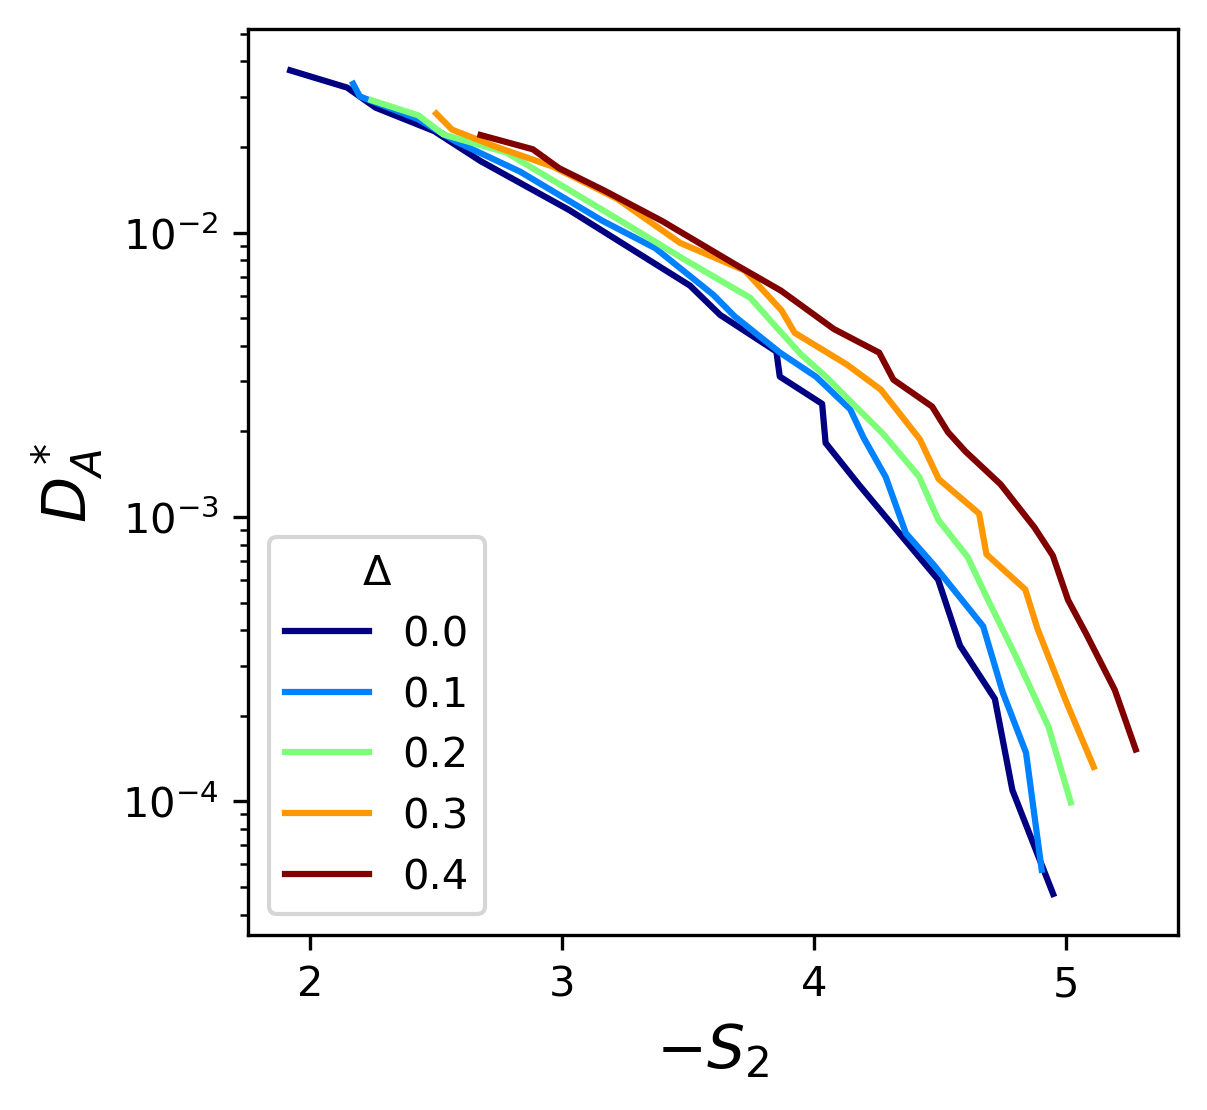

In [21]:
def plot_reduced_diffusion_coefficient_excess_entropy_v2(ax, diff_data, excess_entropy_folder, legend=True):
    cmap = cm.jet
    norm = mpl.colors.Normalize(vmin=0, vmax=0.4)
    
    for delta, d in diff_data.items():
        phi = delta_to_phi(float(delta))
        with open(excess_entropy_folder + f"/excess-entropy-binary_delta-{delta}.pickle", "rb") as f:
            excess_entropy_data = pickle.load(f)
        plot_data = []
        for temp, data in excess_entropy_data.items():
            plot_data.append(excess_entropy_data[temp]["excess_entropy"])
        ax.plot(-np.array(plot_data), np.array(d[()]["D"])*phi**(1/3)*np.sqrt(d[()]["inv_temp"]), label=f"{delta}", color=cmap(norm(float(delta))))
    if legend:
        ax.legend(title=r"$\Delta$")
    ax.set_yscale('log')
    ax.set_xlabel(r"$-S_2$")
    ax.set_ylabel(r"$D^*_A$")

fig, ax = plt.subplots(dpi=150, figsize=(4,4)) # , sharey=True, gridspec_kw={'hspace': 0, 'wspace': 0}
plot_reduced_diffusion_coefficient_excess_entropy_v2(ax, np.load(project.fn("dynamics/diffusion_coefficients.npz"), allow_pickle=True), project.fn("structure"))
# # make_axes_label(axs[1], "(b)")

# plt.savefig("fig2.png", dpi=200)

# Figure 3 - Bin by softness and get Arrhenius fits

In [135]:
for delta, jobs_iter in project.find_jobs(None, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):

    print(delta)

    jobs = list(jobs_iter)

    job0 = jobs[0]
    temps = job0.doc["temps"]

    with open(project.fn(f"softness_pipelines/delta-{delta:.1f}/pipe_ss-0_ts-10.pickle"), "rb") as f:
        pipeline = pickle.load(f)
    pipe = pipeline["pipe"]

    bounds_file = project.fn(f"structure/softness-bounds_delta-{delta}.npz")
    bounds_file_pkl = project.fn(f"structure/softness-bounds_delta-{delta}.pickle")
    if os.path.exists(bounds_file):
        softness_bounds = pickle.load(open(bounds_file, "rb"))
        bounds_arr = softness_bounds["bounds"]
        softness_bounds["min"] = np.max(bounds_arr[:, 0])
        softness_bounds["max"] = np.min(bounds_arr[:, 1])
        bound_temps_arr = softness_bounds["temps"]
        softness_bounds["temps"] = [float(b) for b in bound_temps_arr]
        pickle.dump(softness_bounds, open(bounds_file_pkl, "wb"))
    else:
        bounds = []
        bound_temps = []
        
        for job in jobs:
            print(job)
            files = glob.glob(job.fn(f"short_runs/*/sfs.parquet"))
            for file in files:
                df = pd.read_parquet(file)
                df = df[df["type"] == 0]
                softness = pipe.decision_function(list(df["sf"]))
                q05 = np.quantile(softness, 0.05)
                q95 = np.quantile(softness, 0.95)
                bounds.append((q05, q95))
                bound_temps.append(float(utils.extract_between(file, "temp-", "/sfs.parquet")))
        
        bounds_arr = np.array(bounds)
        bound_temps_arr = np.array(bound_temps)
        softness_bounds = dict(min=np.max(bounds_arr[:, 0]), max=np.min(bounds_arr[:, 1]), bounds=bounds_arr, temps=bound_temps_arr, q_min=0.05, q_max=0.95)
        pickle.dump(softness_bounds, open(bounds_file, "wb"))

    plot_data = []

    be = np.linspace(softness_bounds["min"], softness_bounds["max"], 6)
    soft_bin_centers = be[:-1] + np.diff(be)/2

    rearrang_file = project.fn(f"prob_rearrang/softness_delta-{delta}.pickle")

    if not os.path.exists(rearrang_file):
        for temp in temps:
            dfs = []
            for job in jobs:
                files = glob.glob(job.fn(f"short_runs/temp-{temp:.2f}/sfs.parquet"))
                if len(files) == 0:
                    continue
                assert len(files) == 1
                file = files[0]
                df = pd.read_parquet(file)
                df = df[df["type"] == 0]
                dfs.append(df)
            if len(dfs) == 0:
                continue
            assert len(dfs) == 3
            print(temp)
            df = pd.concat(dfs)

            df["softness"] = pipe.decision_function(list(df["sf"]))

            df["rearrang"] = df["phop"] > 0.2

            df["cuts"] = pd.cut(df["softness"], bins=be)

            data = []
            for cut, df_cut in df.groupby("cuts"):
                data.append([cut.mid, df_cut["rearrang"].mean()])
            plot_data.append(data)

        plot_data = np.array(plot_data)

        output_data = dict(delta=delta, temps=temps, bounds_data=softness_bounds, data=plot_data, bin_centers=soft_bin_centers, bin_edges=be)

        pickle.dump(output_data, open(rearrang_file, "wb"))



0.0
2.0
1.8
1.6
1.4
1.2
1.0
0.9
0.8
0.75
0.7
0.67
0.64
0.61
0.58
0.55
0.53
0.51
0.49
0.47
0.45
0.1
2.51
2.26
2.01
1.76
1.51
1.25
1.13
1.0
0.94
0.88
0.84
0.8
0.77
0.73
0.69
0.67
0.64
0.61
0.59
0.56
0.2
3.25
2.93
2.6
2.28
1.95
1.63
1.46
1.3
1.22
1.14
1.09
1.04
0.99
0.94
0.89
0.86
0.83
0.8
0.76
0.73
0.3
4.39
3.95
3.51
3.08
2.64
2.2
1.98
1.76
1.65
1.54
1.47
1.41
1.34
1.27
1.21
1.16
1.12
1.08
1.03
0.99
0.4
6.29
5.66
5.03
4.4
3.77
3.15
2.83
2.52
2.36
2.2
2.11
2.01
1.92
1.82
1.73
1.67
1.6
1.54
1.48
1.42


In [199]:
array_sfs = np.array(df["sf"].to_numpy().tolist())

In [189]:
s2_sf = np.array(df["sf"].to_numpy().tolist())[0]
r = np.linspace(0.4, 3.0, 27)
dr = r[1] - r[0]

In [190]:
vol = 4/3*np.pi*(r[-1]**3)
shell = 4*np.pi*(r**2)*dr
n_a = np.sum(s2_sf[::2])
n_b = np.sum(s2_sf[1::2])

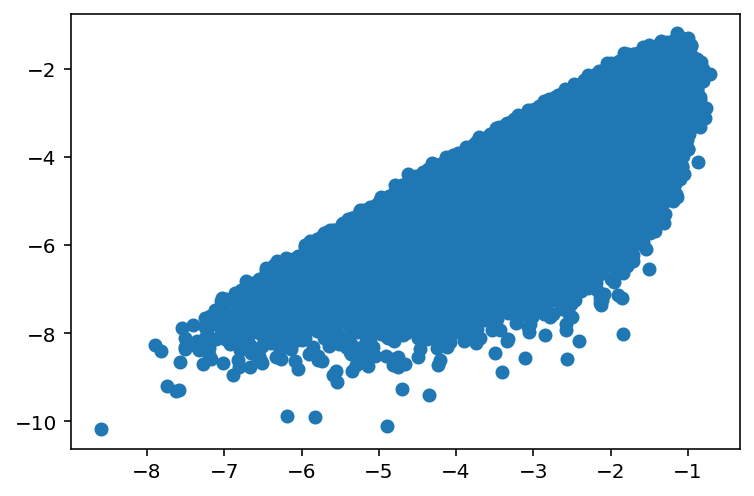

In [200]:
one_part = local_excess_entropy(r, array_sfs, dr)
two_part = local_excess_entropy_binary(r, array_sfs, dr)
plt.scatter(one_part, two_part)

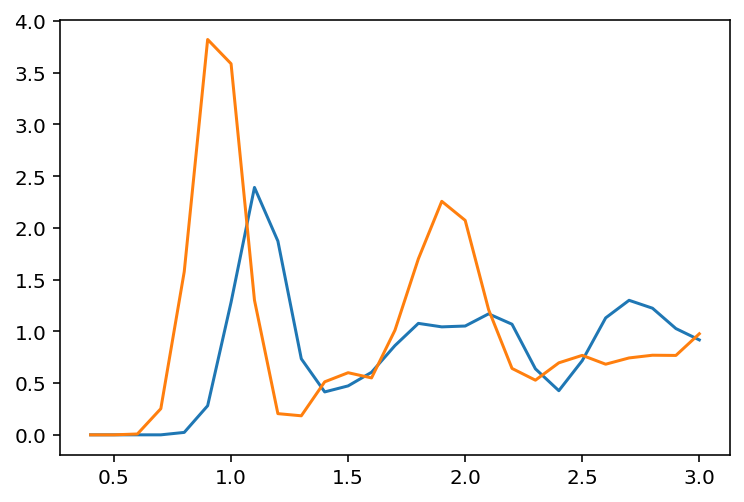

In [198]:
# testing excess entropy calculation

plt.plot(r, s2_sf[::2]/shell/n_a*vol)
plt.plot(r, s2_sf[1::2]/shell/n_b*vol)

In [12]:
r = np.linspace(0.4, 3.0, 27)
dr = r[1] - r[0]

for delta, jobs_iter in project.find_jobs(None, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):

    print(delta)

    jobs = list(jobs_iter)

    job0 = jobs[0]
    temps = job0.doc["temps"]

    bounds_file = project.fn(f"structure/entropy-bounds-binary_delta-{delta}.pickle")
    if not os.path.exists(bounds_file):
        entropy_bounds = pickle.load(open(bounds_file, "rb"))
    else:
        bounds = []
        bound_temps = []
        
        for job in jobs:
            print(job)
            files = glob.glob(job.fn(f"short_runs/*/sfs.parquet"))
            for file in files:
                df = pd.read_parquet(file)
                df = df[df["type"] == 0]
                sfs = np.array(df["sf"].to_numpy().tolist())
                entropy = local_excess_entropy_binary(r, sfs, dr)
                q05 = np.quantile(entropy, 0.05)
                q95 = np.quantile(entropy, 0.95)
                bounds.append((q05, q95))
                bound_temps.append(float(utils.extract_between(file, "temp-", "/sfs.parquet")))
        
        bounds_arr = np.array(bounds)
        bound_temps_arr = np.array(bound_temps)
        entropy_bounds = dict(min=np.max(bounds_arr[:, 0]), max=np.min(bounds_arr[:, 1]), bounds=bounds_arr, temps=bound_temps_arr, q_min=0.05, q_max=0.95)
        pickle.dump(entropy_bounds, open(bounds_file, "wb"))

    plot_data = []

    be = np.linspace(entropy_bounds["min"], entropy_bounds["max"], 6)
    entr_bin_centers = be[:-1] + np.diff(be)/2

    rearrang_file = project.fn(f"prob_rearrang/entropy-binary_delta-{delta}.pickle")

    if os.path.exists(rearrang_file):
        for temp in temps:
            dfs = []
            for job in jobs:
                files = glob.glob(job.fn(f"short_runs/temp-{temp:.2f}/sfs.parquet"))
                if len(files) == 0:
                    continue
                assert len(files) == 1
                file = files[0]
                df = pd.read_parquet(file)
                df = df[df["type"] == 0]
                dfs.append(df)
            if len(dfs) == 0:
                continue
            assert len(dfs) == 3
            print(temp)
            df = pd.concat(dfs)
            sfs = np.array(df["sf"].to_numpy().tolist())
            df["entropy"] = local_excess_entropy_binary(r, sfs, dr)

            df["rearrang"] = df["phop"] > 0.2

            df["cuts"] = pd.cut(df["entropy"], bins=be)

            data = []
            for cut, df_cut in df.groupby("cuts"):
                data.append([cut.mid, df_cut["rearrang"].mean()])
            plot_data.append(data)

        plot_data = np.array(plot_data)

        output_data = dict(delta=delta, temps=temps, bounds_data=entropy_bounds, data=plot_data, bin_centers=entr_bin_centers, bin_edges=be)

        pickle.dump(output_data, open(rearrang_file, "wb"))



0.0
1fd668d1992cea34bb8de5b9cf4bc990
7258b25c27a73f4e5d0f06642c8733a3
e0e449dbb710b9bd88a01339bcca2881
2.0
1.8
1.6
1.4
1.2
1.0
0.9
0.8
0.75
0.7
0.67
0.64
0.61
0.58
0.55
0.53
0.51
0.49
0.47
0.45
0.1
f595e61455c7afd831e594cb06e13386
7a42158b0a5d86f088865f9872fb2cda
45c99c3929afad3f2bd1bff09da3776c
2.51
2.26
2.01
1.76
1.51
1.25
1.13
1.0
0.94
0.88
0.84
0.8
0.77
0.73
0.69
0.67
0.64
0.61
0.59
0.56
0.2
72fe51e16712cb785b06a92bb65cb42d
a298a48087d6d3fb1c9cddeef7cd82a8
314a0d8f96f7c452d5df3fac7ec93728
3.25
2.93
2.6
2.28
1.95
1.63
1.46
1.3
1.22
1.14
1.09
1.04
0.99
0.94
0.89
0.86
0.83
0.8
0.76
0.73
0.3
d6979381505eb6519c0d16ec88037aee
7d6967d4f601c1714b5132edaf24fe9d
f16d82d125d3aab51fd5171c26f67867
4.39
3.95
3.51
3.08
2.64
2.2
1.98
1.76
1.65
1.54
1.47
1.41
1.34
1.27
1.21
1.16
1.12
1.08
1.03
0.99
0.4
5f0a0fbd4dec53eea46715e33a9fa9d3
94a53b959600e08199c6389066f6b3b5
f7dd302c65ba83b65059638f11584ebb
6.29
5.66
5.03
4.4
3.77
3.15
2.83
2.52
2.36
2.2
2.11
2.01
1.92
1.82
1.73
1.67
1.6
1.54
1.48
1.42


In [13]:
r = np.linspace(0.4, 3.0, 27)
dr = r[1] - r[0]

for delta, jobs_iter in project.find_jobs(None, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):

    print(delta)

    jobs = list(jobs_iter)

    job0 = jobs[0]
    temps = job0.doc["temps"]

    bounds_file = project.fn(f"structure/entropy-bounds_delta-{delta}.pickle")
    if not os.path.exists(bounds_file):
        entropy_bounds = pickle.load(open(bounds_file, "rb"))
    else:
        bounds = []
        bound_temps = []
        
        for job in jobs:
            print(job)
            files = glob.glob(job.fn(f"short_runs/*/sfs.parquet"))
            for file in files:
                df = pd.read_parquet(file)
                df = df[df["type"] == 0]
                sfs = np.array(df["sf"].to_numpy().tolist())
                entropy = local_excess_entropy(r, sfs, dr)
                q05 = np.quantile(entropy, 0.05)
                q95 = np.quantile(entropy, 0.95)
                bounds.append((q05, q95))
                bound_temps.append(float(utils.extract_between(file, "temp-", "/sfs.parquet")))
        
        bounds_arr = np.array(bounds)
        bound_temps_arr = np.array(bound_temps)
        entropy_bounds = dict(min=np.max(bounds_arr[:, 0]), max=np.min(bounds_arr[:, 1]), bounds=bounds_arr, temps=bound_temps_arr, q_min=0.05, q_max=0.95)
        pickle.dump(entropy_bounds, open(bounds_file, "wb"))

    plot_data = []

    be = np.linspace(entropy_bounds["min"], entropy_bounds["max"], 6)
    entr_bin_centers = be[:-1] + np.diff(be)/2

    rearrang_file = project.fn(f"prob_rearrang/entropy_delta-{delta}.pickle")

    if os.path.exists(rearrang_file):
        for temp in temps:
            dfs = []
            for job in jobs:
                files = glob.glob(job.fn(f"short_runs/temp-{temp:.2f}/sfs.parquet"))
                if len(files) == 0:
                    continue
                assert len(files) == 1
                file = files[0]
                df = pd.read_parquet(file)
                df = df[df["type"] == 0]
                dfs.append(df)
            if len(dfs) == 0:
                continue
            assert len(dfs) == 3
            print(temp)
            df = pd.concat(dfs)
            sfs = np.array(df["sf"].to_numpy().tolist())
            df["entropy"] = local_excess_entropy(r, sfs, dr)

            df["rearrang"] = df["phop"] > 0.2

            df["cuts"] = pd.cut(df["entropy"], bins=be)

            data = []
            for cut, df_cut in df.groupby("cuts"):
                data.append([cut.mid, df_cut["rearrang"].mean()])
            plot_data.append(data)

        plot_data = np.array(plot_data)

        output_data = dict(delta=delta, temps=temps, bounds_data=entropy_bounds, data=plot_data, bin_centers=entr_bin_centers, bin_edges=be)

        pickle.dump(output_data, open(rearrang_file, "wb"))



0.0
1fd668d1992cea34bb8de5b9cf4bc990
7258b25c27a73f4e5d0f06642c8733a3
e0e449dbb710b9bd88a01339bcca2881
2.0
1.8
1.6
1.4
1.2
1.0
0.9
0.8
0.75
0.7
0.67
0.64
0.61
0.58
0.55
0.53
0.51
0.49
0.47
0.45
0.1
f595e61455c7afd831e594cb06e13386
7a42158b0a5d86f088865f9872fb2cda
45c99c3929afad3f2bd1bff09da3776c
2.51
2.26
2.01
1.76
1.51
1.25
1.13
1.0
0.94
0.88
0.84
0.8
0.77
0.73
0.69
0.67
0.64
0.61
0.59
0.56
0.2
72fe51e16712cb785b06a92bb65cb42d
a298a48087d6d3fb1c9cddeef7cd82a8
314a0d8f96f7c452d5df3fac7ec93728
3.25
2.93
2.6
2.28
1.95
1.63
1.46
1.3
1.22
1.14
1.09
1.04
0.99
0.94
0.89
0.86
0.83
0.8
0.76
0.73
0.3
d6979381505eb6519c0d16ec88037aee
7d6967d4f601c1714b5132edaf24fe9d
f16d82d125d3aab51fd5171c26f67867
4.39
3.95
3.51
3.08
2.64
2.2
1.98
1.76
1.65
1.54
1.47
1.41
1.34
1.27
1.21
1.16
1.12
1.08
1.03
0.99
0.4
5f0a0fbd4dec53eea46715e33a9fa9d3
94a53b959600e08199c6389066f6b3b5
f7dd302c65ba83b65059638f11584ebb
6.29
5.66
5.03
4.4
3.77
3.15
2.83
2.52
2.36
2.2
2.11
2.01
1.92
1.82
1.73
1.67
1.6
1.54
1.48
1.42


In [258]:
r = np.linspace(0.4, 3.0, 27)
dr = r[1] - r[0]

for delta, jobs_iter in project.find_jobs(None, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):

    print(delta)

    jobs = list(jobs_iter)

    job0 = jobs[0]
    temps = job0.doc["temps"]

    bounds_file = project.fn(f"structure/entropy-bounds-binary-opt_delta-{delta}.pickle")
    if os.path.exists(bounds_file):
        entropy_bounds = pickle.load(open(bounds_file, "rb"))
    else:
        bounds = []
        bound_temps = []
        
        for job in jobs:
            print(job)
            files = glob.glob(job.fn(f"short_runs/*/sfs.parquet"))
            for file in files:
                df = pd.read_parquet(file)
                df = df[df["type"] == 0]
                sfs = np.array(df["sf"].to_numpy().tolist())
                entropy = local_excess_entropy_binary_density_var(r, sfs, dr)
                q05 = np.quantile(entropy, 0.05)
                q95 = np.quantile(entropy, 0.95)
                bounds.append((q05, q95))
                bound_temps.append(float(utils.extract_between(file, "temp-", "/sfs.parquet")))
        
        bounds_arr = np.array(bounds)
        bound_temps_arr = np.array(bound_temps)
        entropy_bounds = dict(min=np.max(bounds_arr[:, 0]), max=np.min(bounds_arr[:, 1]), bounds=bounds_arr, temps=bound_temps_arr, q_min=0.05, q_max=0.95)
        pickle.dump(entropy_bounds, open(bounds_file, "wb"))

    plot_data = []

    be = np.linspace(entropy_bounds["min"], entropy_bounds["max"], 6)
    entr_bin_centers = be[:-1] + np.diff(be)/2

    rearrang_file = project.fn(f"prob_rearrang/entropy-binary-opt_delta-{delta}.pickle")

    if not os.path.exists(rearrang_file):
        for temp in temps:
            dfs = []
            for job in jobs:
                files = glob.glob(job.fn(f"short_runs/temp-{temp:.2f}/sfs.parquet"))
                if len(files) == 0:
                    continue
                assert len(files) == 1
                file = files[0]
                df = pd.read_parquet(file)
                df = df[df["type"] == 0]
                dfs.append(df)
            if len(dfs) == 0:
                continue
            assert len(dfs) == 3
            print(temp)
            df = pd.concat(dfs)
            sfs = np.array(df["sf"].to_numpy().tolist())
            df["entropy"] = local_excess_entropy_binary_density_var(r, sfs, dr)

            df["rearrang"] = df["phop"] > 0.2

            df["cuts"] = pd.cut(df["entropy"], bins=be)

            data = []
            for cut, df_cut in df.groupby("cuts"):
                data.append([cut.mid, df_cut["rearrang"].mean()])
            plot_data.append(data)

        plot_data = np.array(plot_data)

        output_data = dict(delta=delta, temps=temps, bounds_data=entropy_bounds, data=plot_data, bin_centers=entr_bin_centers, bin_edges=be)

        pickle.dump(output_data, open(rearrang_file, "wb"))



0.0
1fd668d1992cea34bb8de5b9cf4bc990
7258b25c27a73f4e5d0f06642c8733a3
e0e449dbb710b9bd88a01339bcca2881
2.0
1.8
1.6
1.4
1.2
1.0
0.9
0.8
0.75
0.7
0.67
0.64
0.61
0.58
0.55
0.53
0.51
0.49
0.47
0.45
0.1
f595e61455c7afd831e594cb06e13386
7a42158b0a5d86f088865f9872fb2cda
45c99c3929afad3f2bd1bff09da3776c
2.51
2.26
2.01
1.76
1.51
1.25
1.13
1.0
0.94
0.88
0.84
0.8
0.77
0.73
0.69
0.67
0.64
0.61
0.59
0.56
0.2
72fe51e16712cb785b06a92bb65cb42d
a298a48087d6d3fb1c9cddeef7cd82a8
314a0d8f96f7c452d5df3fac7ec93728
3.25
2.93
2.6
2.28
1.95
1.63
1.46
1.3
1.22
1.14
1.09
1.04
0.99
0.94
0.89
0.86
0.83
0.8
0.76
0.73
0.3
d6979381505eb6519c0d16ec88037aee
7d6967d4f601c1714b5132edaf24fe9d
f16d82d125d3aab51fd5171c26f67867
4.39
3.95
3.51
3.08
2.64
2.2
1.98
1.76
1.65
1.54
1.47
1.41
1.34
1.27
1.21
1.16
1.12
1.08
1.03
0.99
0.4
5f0a0fbd4dec53eea46715e33a9fa9d3
94a53b959600e08199c6389066f6b3b5
f7dd302c65ba83b65059638f11584ebb
6.29
5.66
5.03
4.4
3.77
3.15
2.83
2.52
2.36
2.2
2.11
2.01
1.92
1.82
1.73
1.67
1.6
1.54
1.48
1.42


In [259]:
r = np.linspace(0.4, 3.0, 27)
dr = r[1] - r[0]

for delta, jobs_iter in project.find_jobs(None, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):

    print(delta)

    jobs = list(jobs_iter)

    with open(project.fn(f"softness_pipelines/delta-{delta:.1f}/pipe_ss-0_ts-10.pickle"), "rb") as f:
        pipeline = pickle.load(f)
    pipe = pipeline["pipe"]

    job0 = jobs[0]

    temps = job0.doc["temps"]
    for temp in temps:
        for job in jobs:
            files = sorted(glob.glob(job.fn(f"short_runs/temp-{temp:.2f}/sfs.parquet")))

            for file in files:
                df = pd.read_parquet(file)
                df = df[df["type"] == 0]

                df["softness"] = pipe.decision_function(list(df["sf"]))
                sfs = np.array(df["sf"].to_numpy().tolist())
                df["entropy"] = local_excess_entropy(r, sfs, dr)
                df["entropy-binary"] = local_excess_entropy_binary(r, sfs, dr)
                df["entropy-binary-opt"] = local_excess_entropy_binary_density_var(r, sfs, dr, alpha=0.5, taper=(2.0, 1.0))

                df["rearrang"] = df["phop"] > 0.2

                df.drop('sf', axis=1, inplace=True)
                
                out_file = file.replace("sfs.parquet", "struct-descr.parquet")
                assert out_file != file
                df.to_parquet(out_file)

0.0
0.1
0.2
0.3
0.4


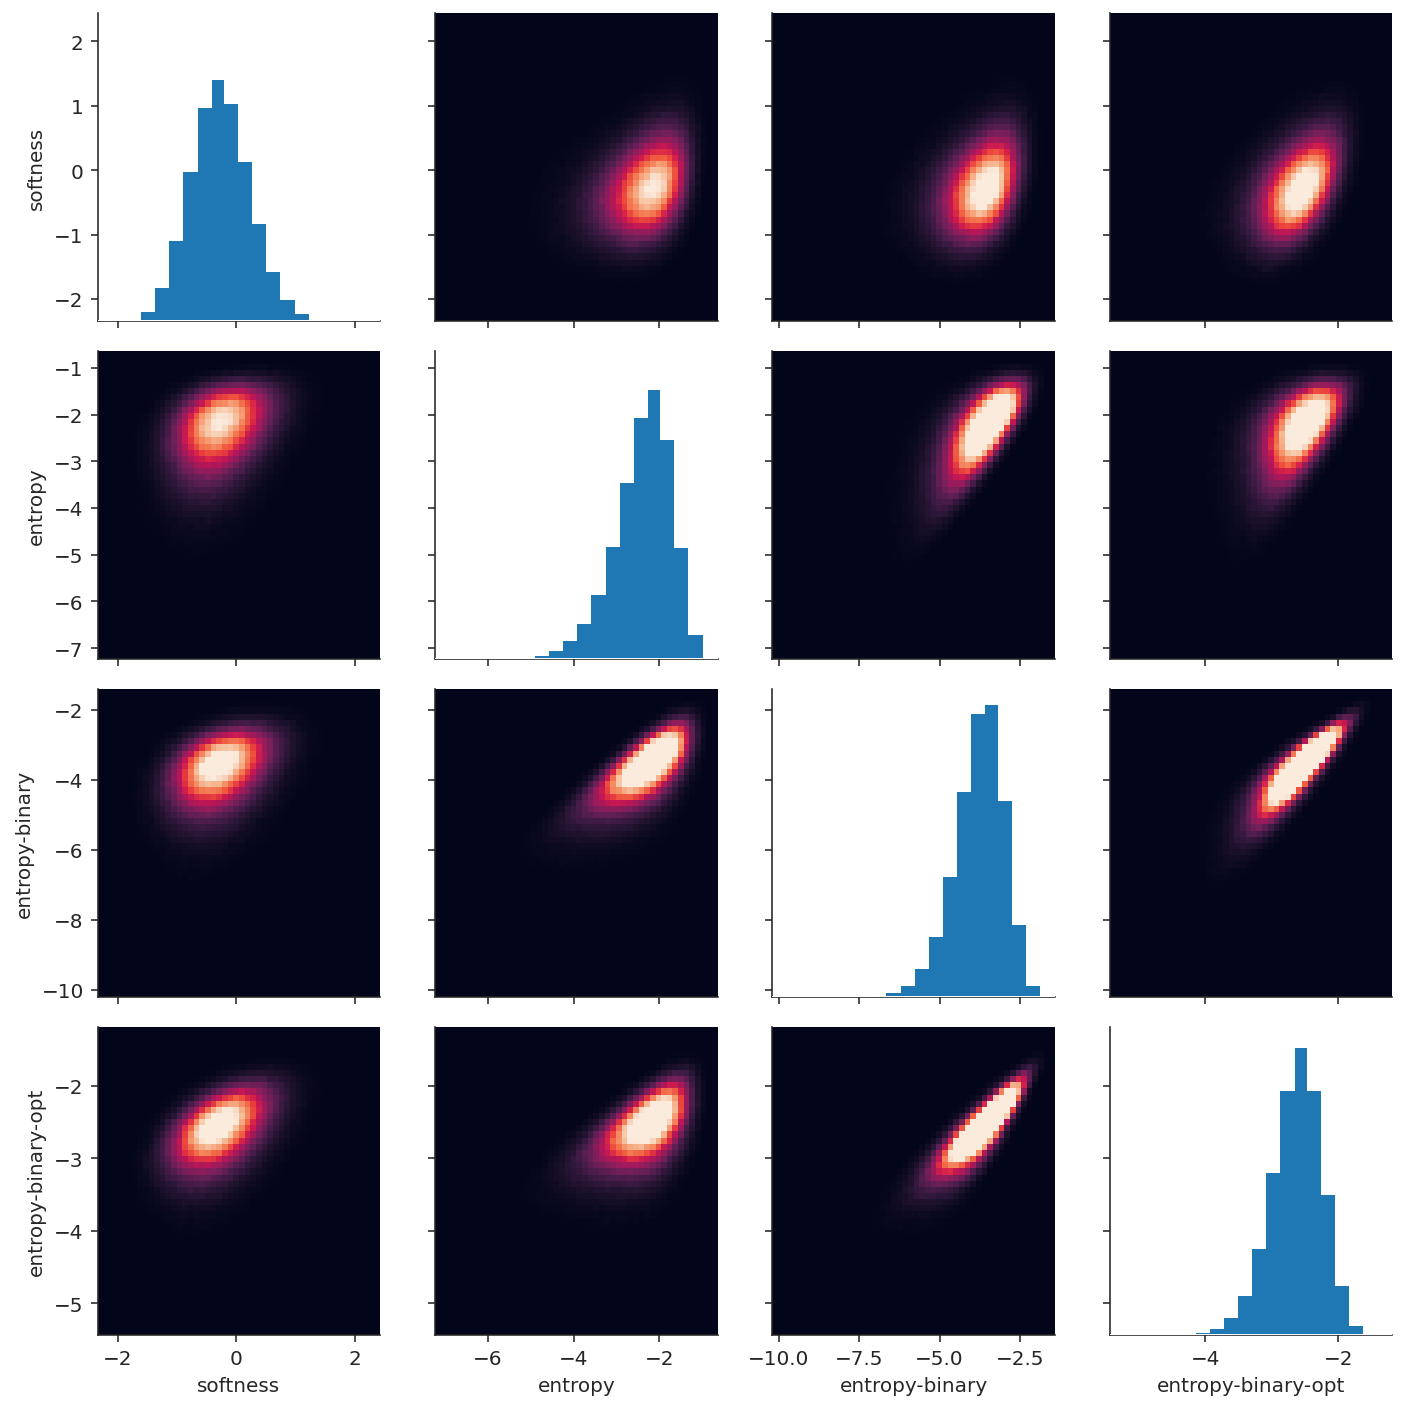

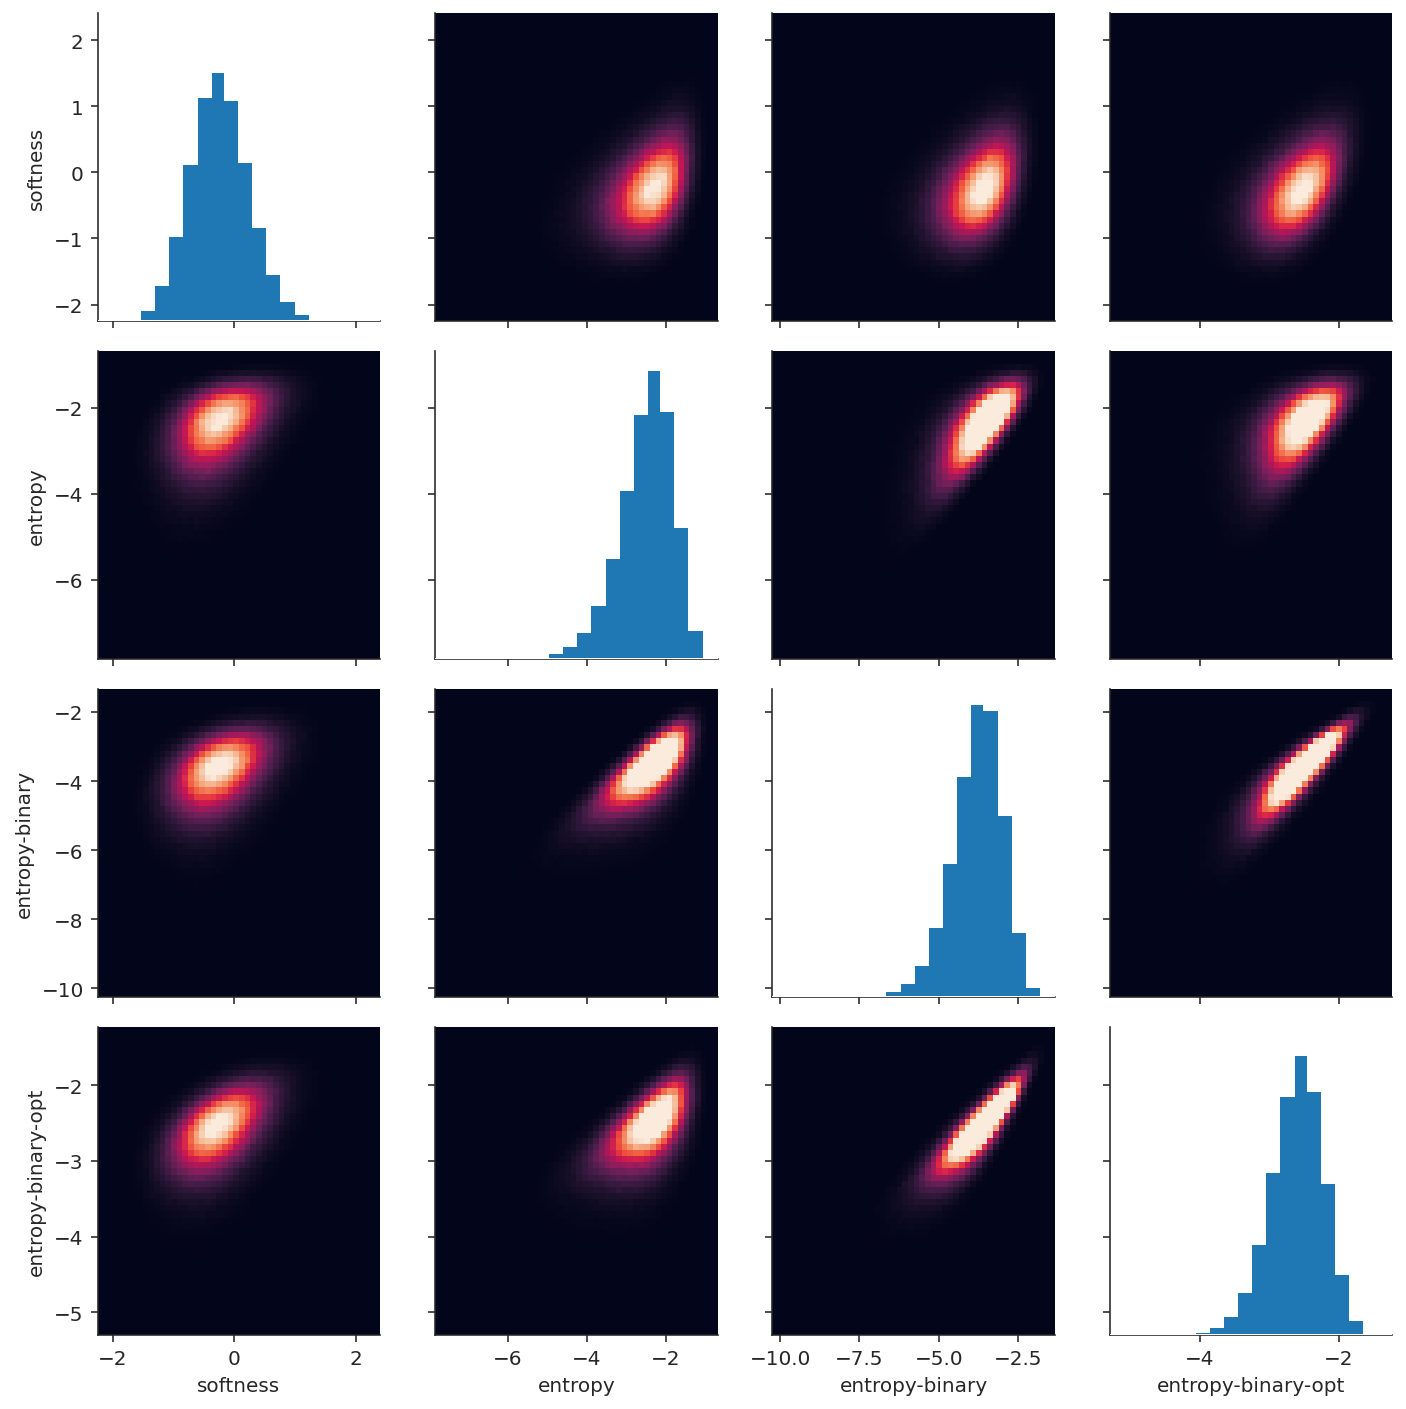

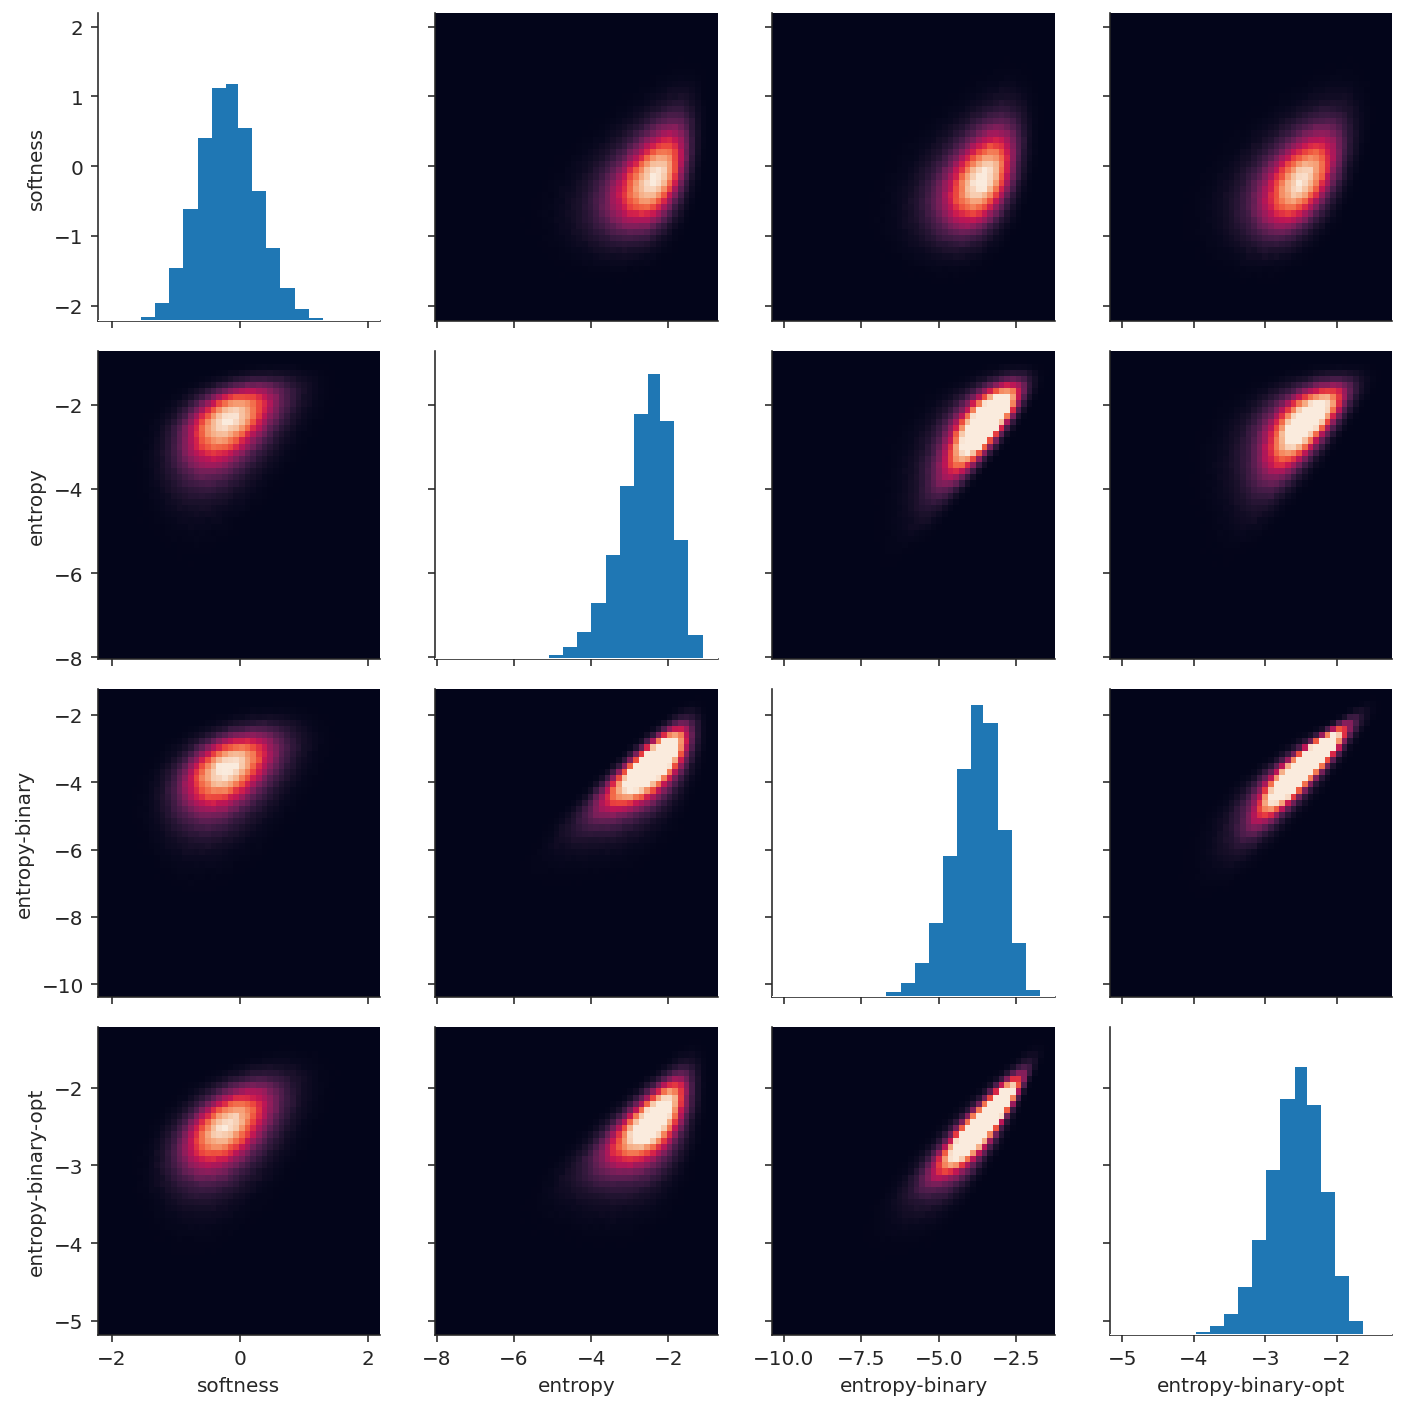

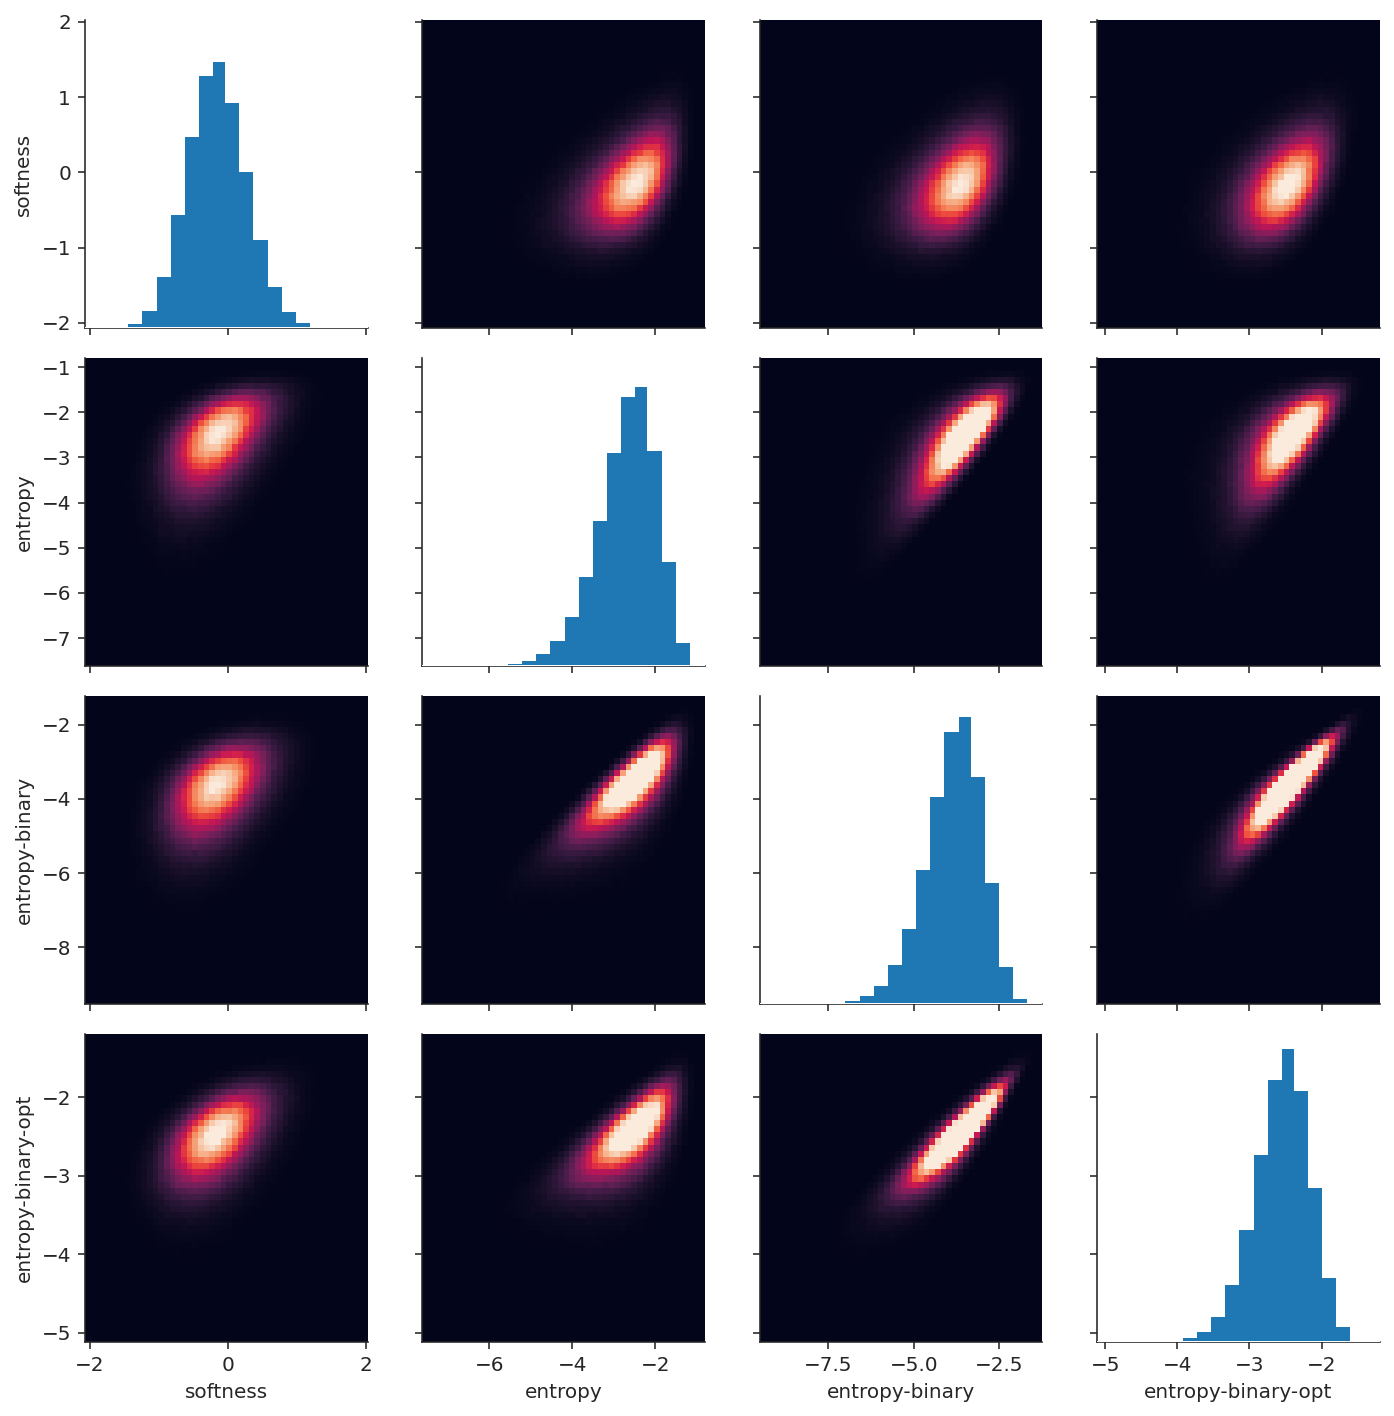

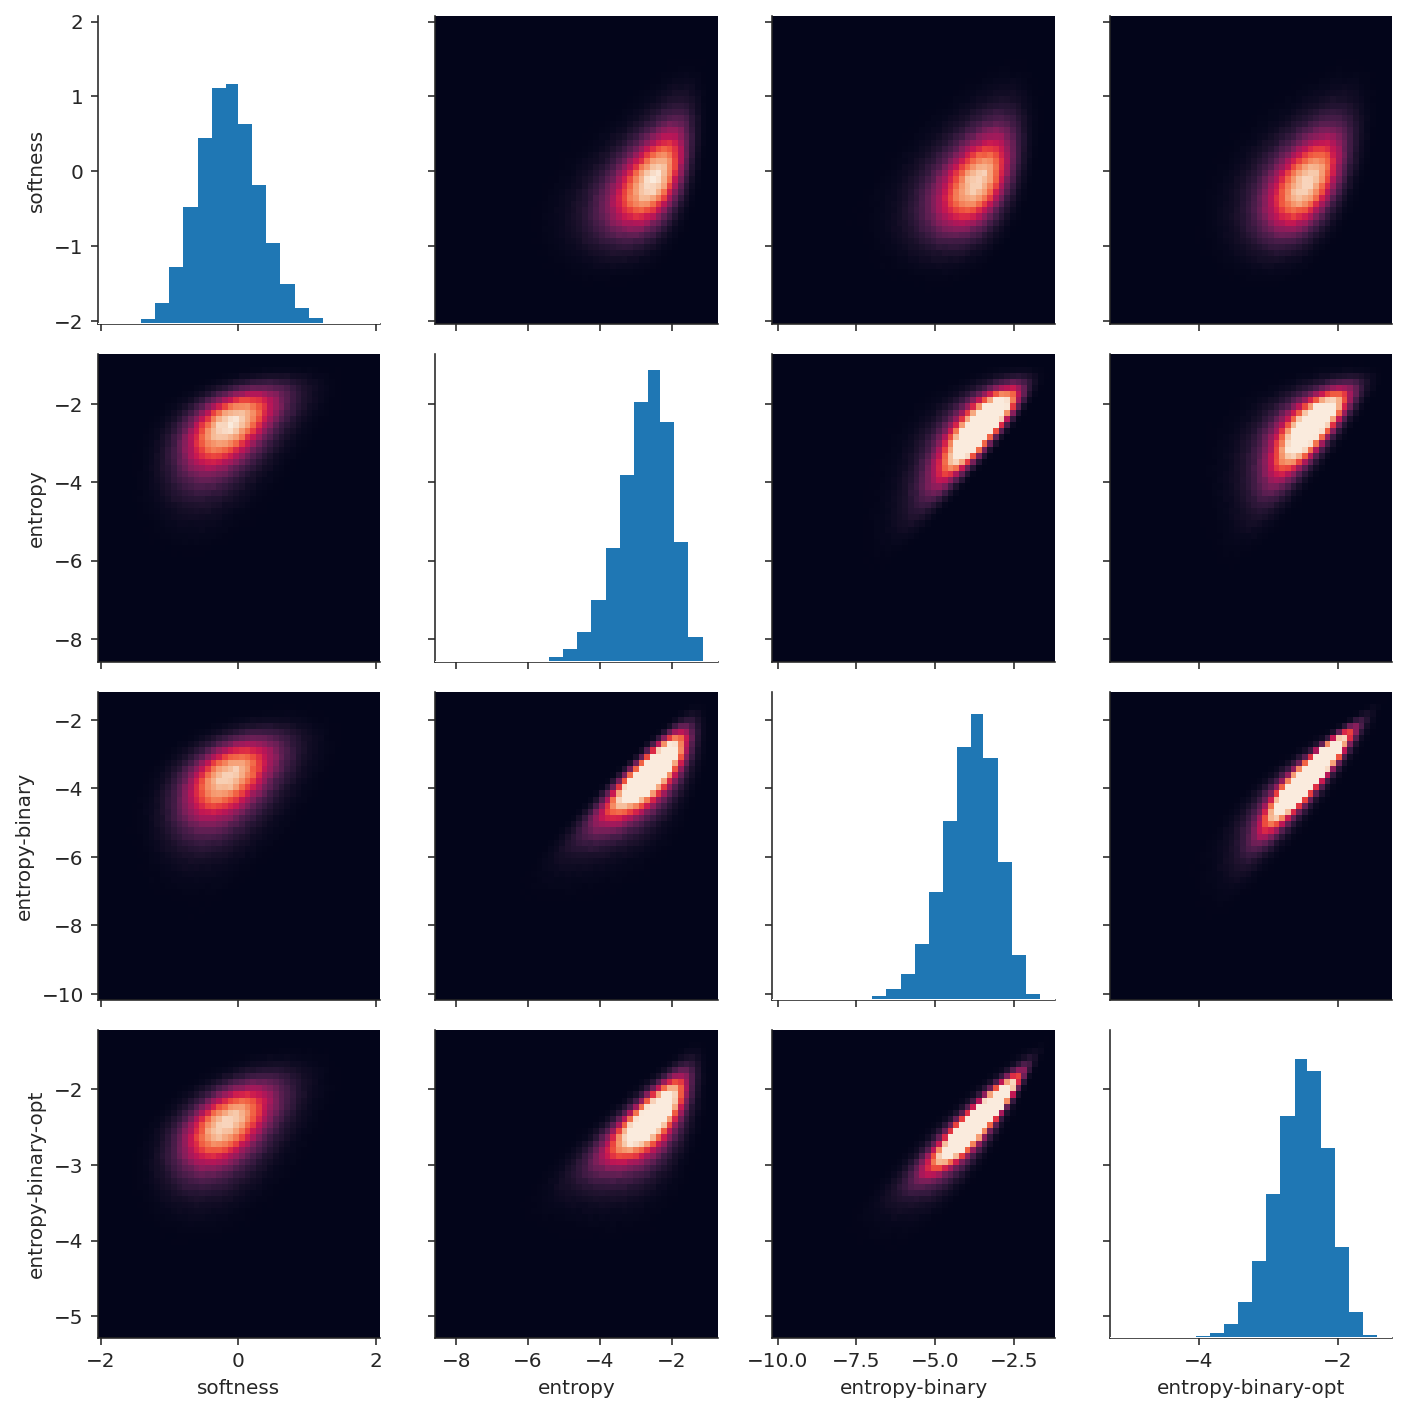

In [18]:
r = np.linspace(0.4, 3.0, 27)
dr = r[1] - r[0]

for delta, jobs_iter in project.find_jobs(None, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):

    jobs = list(jobs_iter)
    job0 = jobs[0]

    temps = job0.doc["temps"]

    dfs = []

    for temp in sorted(temps):
        for job in jobs:
            files = sorted(glob.glob(job.fn(f"short_runs/temp-{temp:.2f}/struct-descr.parquet")))
            for file in files:
                df = pd.read_parquet(file)
                dfs.append(df)
                break
        if len(dfs) > 0:
            break
    
    df = pd.concat(dfs)
    # print(delta, df.iloc[:,4:-1].corr())
    sns.set_style('ticks')
    # sns.light_palette("white", as_cmap=True)
    g = sns.PairGrid(df.iloc[:, 4:-1])
    g.map_diag(plt.hist, bins=20, histtype="stepfilled")

    def pairgrid_heatmap(x, y, **kws):
        plt.hist2d(x, y, cmin=0, linewidths=0, **kws)

    g.map_offdiag(pairgrid_heatmap, bins=50, norm=colors.Normalize(), cmap="rocket")

### Fiddling with some variations of excess entropy

In [14]:
delta

0.0

In [13]:
df.iloc[:,4:-1].corr()

softness   entropy  entropy-binary  entropy-binary-opt
softness            1.000000  0.319982        0.343580            0.458191
entropy             0.319982  1.000000        0.708047            0.570543
entropy-binary      0.343580  0.708047        1.000000            0.865020
entropy-binary-opt  0.458191  0.570543        0.865020            1.000000

In [86]:
r = np.linspace(0.4, 3.0, 27)
dr = r[1] - r[0]

for delta, jobs_iter in project.find_jobs(None, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):

    print(delta)

    jobs = list(jobs_iter)

    with open(project.fn(f"softness_pipelines/delta-{delta:.1f}/pipe_ss-0_ts-10.pickle"), "rb") as f:
        pipeline = pickle.load(f)
    pipe = pipeline["pipe"]

    job0 = jobs[0]

    temps = sorted(job0.doc["temps"])[2:]
    for temp in temps:
        for job in jobs:
            files = sorted(glob.glob(job.fn(f"short_runs/temp-{temp:.2f}/sfs.parquet")))

            for file in files:
                print(file)
                df = pd.read_parquet(file)
                df = df[df["type"] == 0]
            break
        break
    break
            

0.0
/media/ian/Data2/monk/mlj-production/workspace/1fd668d1992cea34bb8de5b9cf4bc990/short_runs/temp-0.45/sfs.parquet


In [89]:
df["softness"] = pipe.decision_function(list(df["sf"]))
sfs = np.array(df["sf"].to_numpy().tolist())
df["entropy"] = local_excess_entropy(r, sfs, dr)
df["entropy-binary"] = local_excess_entropy_binary(r, sfs, dr)
df["entropy-dens"] = local_excess_entropy_density(r, sfs, dr)
df["entropy-binary-dens"] = local_excess_entropy_binary_density(r, sfs, dr)

In [111]:
df.iloc[:,5:].corr()

softness   entropy  entropy-binary  entropy-dens  \
softness                 1.000000  0.328219        0.347732      0.367026   
entropy                  0.328219  1.000000        0.707220      0.996187   
entropy-binary           0.347732  0.707220        1.000000      0.704007   
entropy-dens             0.367026  0.996187        0.704007      1.000000   
entropy-binary-dens      0.399914  0.704104        0.993293      0.710803   
entropy-binary-dens-var  0.378817  0.811328        0.914037      0.819508   

                         entropy-binary-dens  entropy-binary-dens-var  
softness                            0.399914                 0.378817  
entropy                             0.704104                 0.811328  
entropy-binary                      0.993293                 0.914037  
entropy-dens                        0.710803                 0.819508  
entropy-binary-dens                 1.000000                 0.924428  
entropy-binary-dens-var             0.924428                 1.000000

In [91]:
df.head()

frame  tag  type      phop  \
0      0    0     0  0.000713   
1      0    1     0  0.000862   
2      0    2     0  0.014712   
3      0    3     0  0.000485   
4      0    4     0  0.001081   

                                                  sf  softness   entropy  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.01931316, 0.0, 0.2...  0.118890 -2.236004   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.014731606, 0.0, 0.... -0.385413 -2.102081   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.016687617, 0.0, 0.... -0.009888 -2.508852   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.02962939, 0.002191... -0.710552 -2.242270   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.129... -0.273929 -3.410165   

   entropy-binary  entropy-dens  entropy-binary-dens  
0       -3.457283     -6.760927           -10.453665  
1       -2.999533     -6.739044            -9.616180  
2       -4.182886     -8.089755           -13.487651  
3       -3.260788     -7.309683           -10.629998  
4       -6.389401    -10.486200           -19.647303

In [49]:
for delta, jobs_iter in project.find_jobs(None, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):

    print(delta)

    jobs = list(jobs_iter)

    job0 = jobs[0]

    temps = sorted(job0.doc["temps"])[2:]
    for temp in temps:
        for job in jobs:
            print(job)
            files = sorted(glob.glob(job.fn(f"short_runs/temp-{temp:.2f}/struct-descr.parquet")))
            if len(files) == 0:
                continue
            file = files[0]
            df = pd.read_parquet(file)
            break
        break
    break

0.0
1fd668d1992cea34bb8de5b9cf4bc990


In [132]:
for delta, _ in project.find_jobs(None, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):

    file = project.fn(f"prob_rearrang/softness_delta-{delta}.pickle")
    out_file = project.fn(f"prob_rearrang/fit_softness_delta-{delta}.pickle")
    data = pickle.load(open(file, "rb"))
    bd = data["bounds_data"]

    itemps = []
    for temp, soft in zip(data["temps"][11:], data["data"][11:]):
        itemps.append(1/temp)
    fit_data = {}
    inv_t = np.array(itemps)
    for d, s in zip(data["data"][11:,:,1].T, data["data"][11:,:,0].T):
        p = np.polyfit(itemps, np.log(d), 1)
        x = np.linspace(itemps[0], itemps[-1], 100)
        y = np.polyval(p, x)
        fit_data[s[0]] = dict(x=x, y=y, p=p, d=d, log_d=np.log(d))
    pickle.dump(dict(data=fit_data, inv_t=inv_t), open(out_file, "wb"))
    


    file = project.fn(f"prob_rearrang/entropy-binary-opt_delta-{delta}.pickle")
    out_file = project.fn(f"prob_rearrang/fit_entropy-binary-opt_delta-{delta}.pickle")
    data = pickle.load(open(file, "rb"))
    bd = data["bounds_data"]

    itemps = []
    for temp, soft in zip(data["temps"][11:], data["data"][11:]):
        itemps.append(1/temp)
    fit_data = {}
    inv_t = np.array(itemps)
    for d, s in zip(data["data"][11:,:,1].T, data["data"][11:,:,0].T):
        p = np.polyfit(itemps, np.log(d), 1)
        x = np.linspace(itemps[0], itemps[-1], 100)
        y = np.polyval(p, x)
        fit_data[s[0]] = dict(x=x, y=y, p=p, d=d, log_d=np.log(d))
    pickle.dump(dict(data=fit_data, inv_t=inv_t), open(out_file, "wb"))


In [131]:
s

array([-0.804, -0.804, -0.804, -0.804, -0.804, -0.804, -0.804, -0.804,
       -0.804])

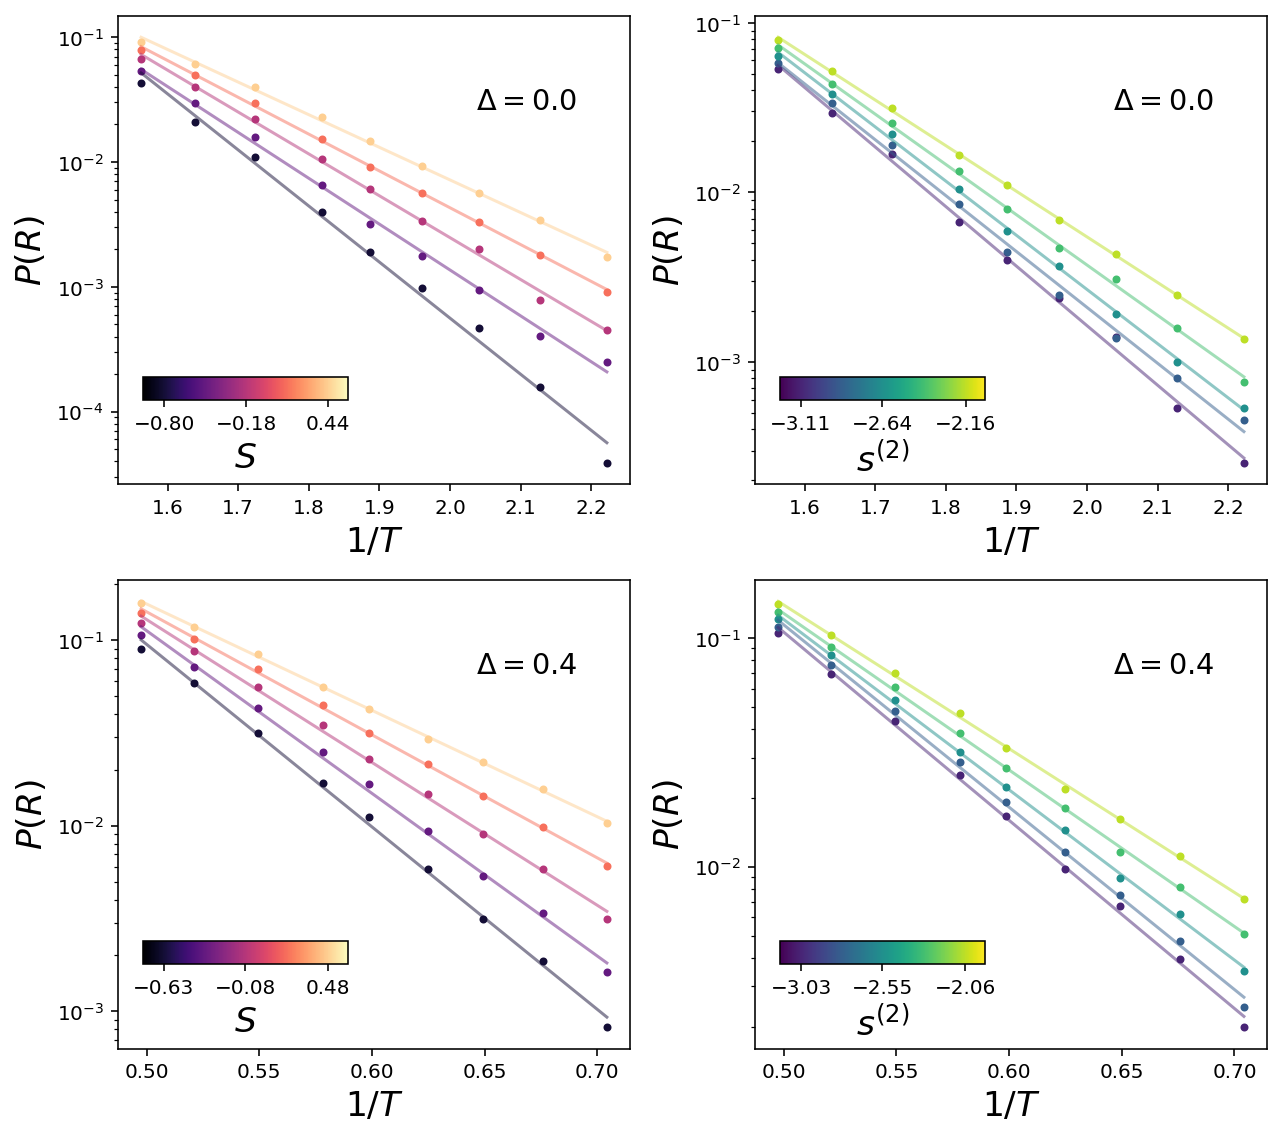

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(9, 8), tight_layout=True)
faxes = np.ravel(axes)
# make_axes_label(faxes[0], "(a)")
# make_axes_label(faxes[1], "(b)")
# make_axes_label(faxes[2], "(c)")
# make_axes_label(faxes[3], "(d)")

iter_axs = iter(axes)

for delta, _ in project.find_jobs(None, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):
    if delta == 0.0 or delta == 0.4:
        pass
    else:
        continue

    axs = iter_axs.__next__()
    plt.sca(axs[0])
    plt.yscale('log')

    file = project.fn(f"prob_rearrang/softness_delta-{delta}.pickle")
    data = pickle.load(open(file, "rb"))
    bd = data["bounds_data"]
    # cmap = sns.color_palette("flare", as_cmap=True)
    cmap = sns.color_palette("magma", as_cmap=True)
    norm = colors.Normalize(bd["min"], bd["max"])
    itemps = []
    for temp, soft in zip(data["temps"][11:], data["data"][11:]):
        itemps.append(1/temp)
        for s, d in soft:
            plt.plot(1/temp, d, ".", color=cmap(norm(s)))
    cbaxes = axs[0].inset_axes([0.05, 0.18, 0.4, 0.05])
    sm = cm.ScalarMappable(norm, cmap)
    ticks = np.around(soft[::2,0], 2)
    plt.colorbar(sm, ticks=ticks, cax=cbaxes, label=r"$S$", orientation='horizontal')
    plt.text(0.7, 0.8, rf'$\Delta={delta}$', transform=axs[0].transAxes, size="x-large")

    for d, s in zip(data["data"][11:,:,1].T, data["data"][11:,:,0].T):
        p = np.polyfit(itemps, np.log(d), 1)
        x = np.linspace(itemps[0], itemps[-1], 100)
        y = np.polyval(p, x)
        plt.plot(x, np.exp(y), color=cmap(norm(s[0])), alpha=0.5)
    
    plt.ylabel(r"$P(R)$", size="xx-large")
    plt.xlabel(r"$1/T$", size="xx-large")

    plt.sca(axs[1])
    plt.yscale('log')
    # axs[1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    file = project.fn(f"prob_rearrang/entropy-binary-opt_delta-{delta}.pickle")
    data = pickle.load(open(file, "rb"))
    bd = data["bounds_data"]
    # cmap = sns.color_palette("crest", as_cmap=True)
    cmap = sns.color_palette("viridis", as_cmap=True)
    norm = colors.Normalize(bd["min"], bd["max"])
    itemps = []
    for temp, soft in zip(data["temps"][11:], data["data"][11:]):
        itemps.append(1/temp)
        for s, d in soft:
            plt.plot(1/temp, d, ".", color=cmap(norm(s)))
    # cbaxes = inset_axes(axs[1], width="40%", height="5%", loc=3)
    cbaxes = axs[1].inset_axes([0.05, 0.18, 0.4, 0.05])
    sm = cm.ScalarMappable(norm, cmap)
    ticks = np.around(soft[::2,0], 2)
    plt.colorbar(sm, ticks=ticks, cax=cbaxes, label=r"$s^{(2)}$", orientation='horizontal')
    plt.text(0.7, 0.8, rf'$\Delta={delta}$', transform=axs[1].transAxes, size="x-large")

    for d, s in zip(data["data"][11:,:,1].T, data["data"][11:,:,0].T):
        p = np.polyfit(itemps, np.log(d), 1)
        x = np.linspace(itemps[0], itemps[-1], 100)
        y = np.polyval(p, x)
        plt.plot(x, np.exp(y), color=cmap(norm(s[0])), alpha=0.5)

    plt.ylabel(r"$P(R)$", size="xx-large")
    plt.xlabel(r"$1/T$", size="xx-large")

plt.savefig("fig3.png", dpi=200)

0.0
0.1
0.2
0.3
0.4


Text(0, 0.5, '$\\Sigma$')

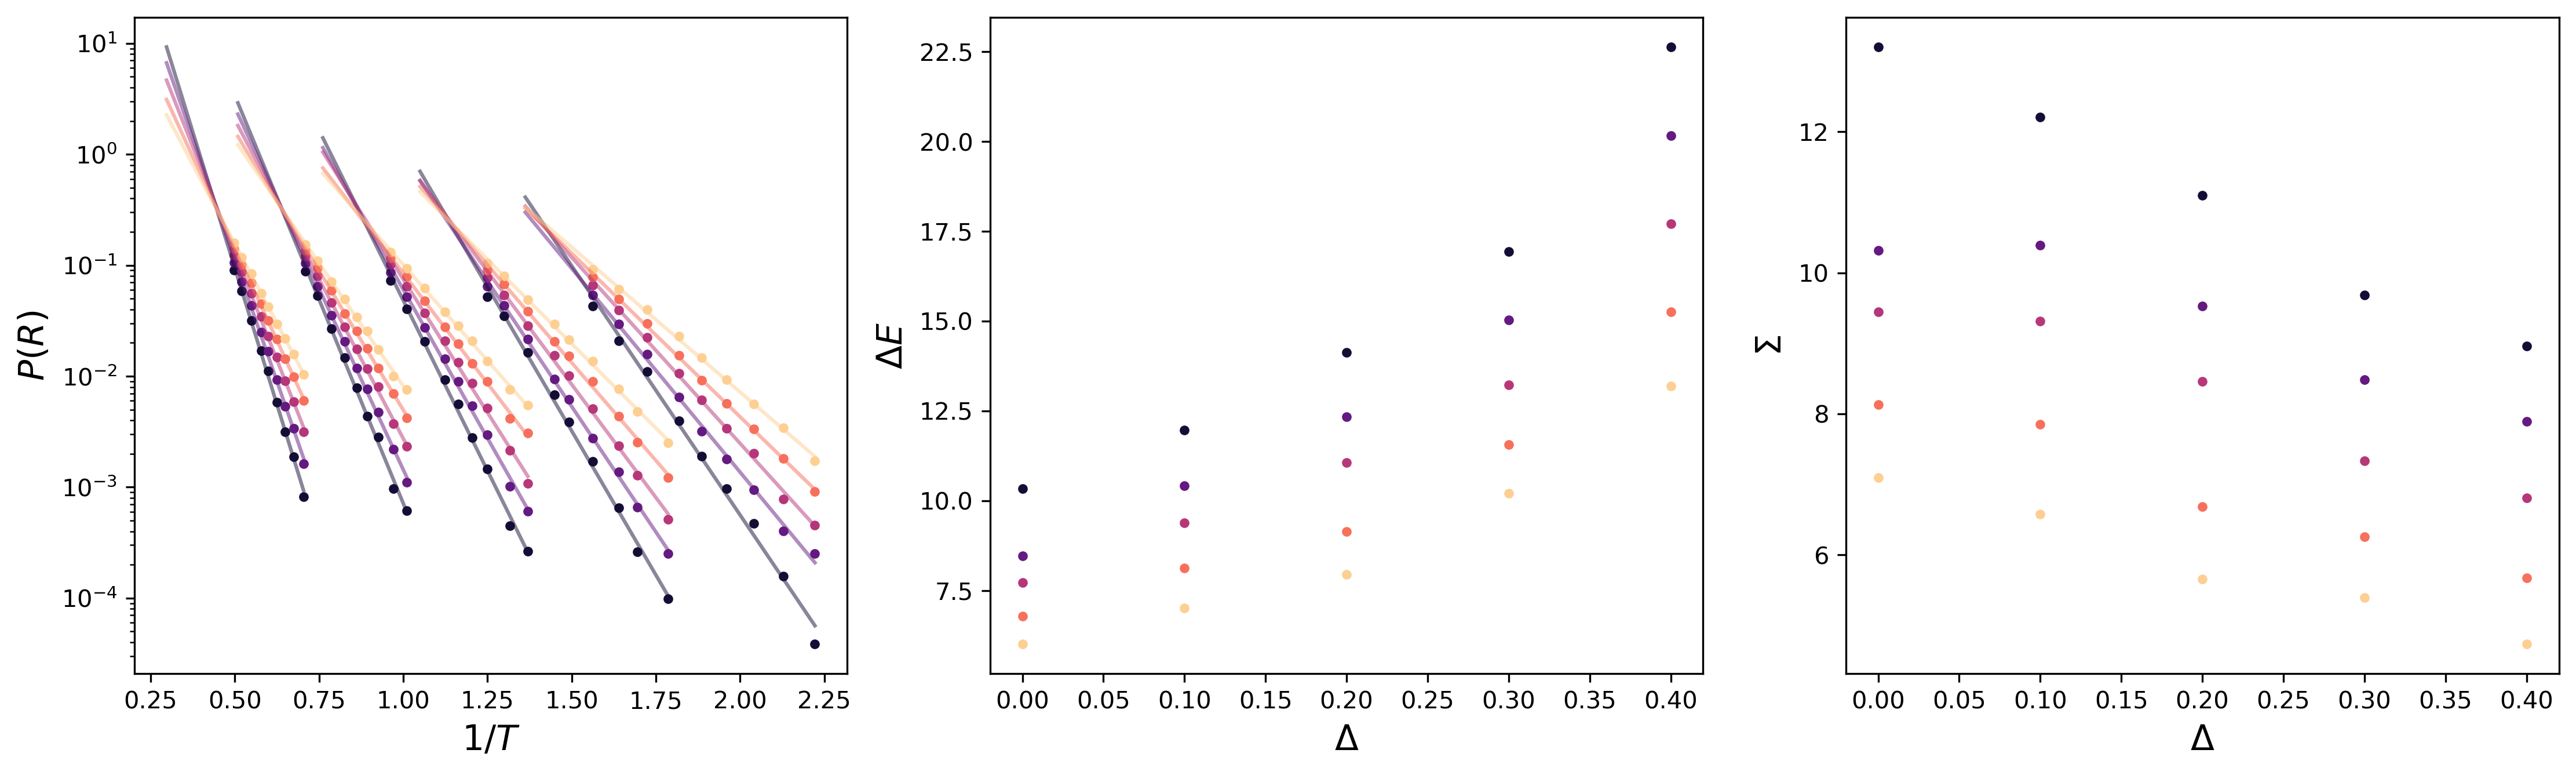

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), dpi=150)

out = []
for delta, _ in project.find_jobs(None, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):
    print(delta)
    DEs = []
    SEs = []
    # if delta == 0.0 or delta == 0.4:
    #     pass
    # else:
    #     continue

    # axs = iter_axs.__next__()
    plt.sca(axs[0])
    plt.yscale('log')

    file = project.fn(f"prob_rearrang/softness_delta-{delta}.pickle")
    data = pickle.load(open(file, "rb"))
    bd = data["bounds_data"]
    # cmap = sns.color_palette("flare", as_cmap=True)
    cmap = sns.color_palette("magma", as_cmap=True)
    norm = colors.Normalize(bd["min"], bd["max"])
    itemps = []
    for temp, soft in zip(data["temps"][11:], data["data"][11:]):
        itemps.append(1/temp)
        for s, d in soft:
            plt.plot(1/temp, d, ".", color=cmap(norm(s)))
    # cbaxes = axs[0].inset_axes([0.05, 0.15, 0.4, 0.05])
    # sm = cm.ScalarMappable(norm, cmap)
    # ticks = np.around(soft[::2,0], 2)
    # plt.colorbar(sm, ticks=ticks, cax=cbaxes, label=r"$S$", orientation='horizontal')
    # plt.text(0.7, 0.8, rf'$\Delta={delta}$', transform=axs[0].transAxes, size="large")

    for d, s in zip(data["data"][11:,:,1].T, data["data"][11:,:,0].T):
        p = np.polyfit(itemps, np.log(d), 1)
        x = np.linspace(itemps[0]-0.2, itemps[-1], 100)
        y = np.polyval(p, x)
        # DEs.append(-p[0])
        # SEs.append(p[1])
        plt.plot(x, np.exp(y), color=cmap(norm(s[0])), alpha=0.5)
        axs[1].plot(delta, -p[0], ".", color=cmap(norm(s[0])))
        axs[2].plot(delta, p[1], ".", color=cmap(norm(s[0])))

    # axs[1].plot([delta]*len(DEs), DEs, "ok", label=f"{delta}")
    # axs[2].plot([delta]*len(SEs), SEs, "ok", label=f"{delta}")
    
plt.ylabel(r"$P(R)$")
plt.xlabel(r"$1/T$")

plt.sca(axs[1])
plt.xlabel(r"$\Delta$")
plt.ylabel(r"$\Delta E$")

plt.sca(axs[2])
plt.xlabel(r"$\Delta$")
plt.ylabel(r"$\Sigma$")

# axs[1].legend()

# plt.savefig("fig3.png", dpi=200)

# Figure 4 - Get softness-excess entropy correlation and cross-over temperatures

## Final Plot

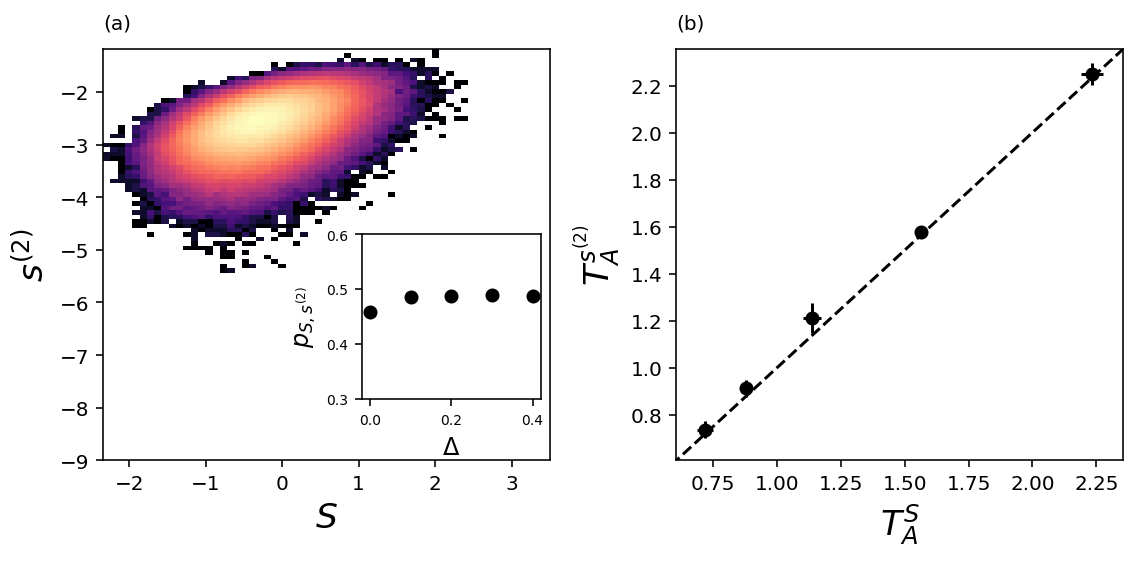

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)

in_ax = axs[0].inset_axes([0.58, 0.15, 0.4, 0.4])
in_ax.tick_params(axis='both', which='major', labelsize="x-small")
in_ax.set_ylim(0.3, 0.6)
in_ax.set_ylabel(r"$p_{S,s^{(2)}}$", size="large")
in_ax.set_xlabel(r'$\Delta$', size="large")

faxes = np.ravel(axs)
make_axes_label(faxes[0], "(a)")
make_axes_label(faxes[1], "(b)")
# make_axes_label(faxes[2], "(c)")

for delta, jobs_iter in project.find_jobs(None, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):

    jobs = list(jobs_iter)
    job0 = jobs[0]

    temps = job0.doc["temps"]

    dfs = []

    for temp in sorted(temps):
        for job in jobs:
            files = sorted(glob.glob(job.fn(f"short_runs/temp-{temp:.2f}/struct-descr.parquet")))
            for file in files:
                df = pd.read_parquet(file)
                dfs.append(df)
                break
        if len(dfs) > 0:
            break
    
    df = pd.concat(dfs)
    # # print(delta, df.iloc[:,4:-1].corr())
    # sns.set_style('ticks')
    # # sns.light_palette("white", as_cmap=True)
    # g = sns.PairGrid(df.iloc[:, 4:-1])
    # g.map_diag(plt.hist, bins=20, histtype="stepfilled")

    def heatmap(x, y, **kws):
        plt.hist2d(x, y, cmin=1, linewidths=0, **kws)

    corr = df[["softness","entropy-binary-opt"]].corr().iloc[1,0]

    in_ax.plot(delta, corr, "o", color="black")

    # corr = df[["softness","entropy"]].corr().iloc[1,0]

    # in_ax.plot(delta, corr, "x", color="green")

    if delta == 0.0:
        plt.sca(axs[0])
        heatmap(df["softness"], df["entropy-binary-opt"], bins=50, norm=colors.LogNorm(), cmap="magma", alpha=1.0)
        plt.xlabel(r"$S$", size="xx-large")
        plt.ylabel(r"$s^{(2)}$", size="xx-large")
    # sns.regplot(x=df["softness"], y=df["entropy-binary-opt"], x_bins=20, ci=None)
    soft = pickle.load(open(project.fn(f"prob_rearrang/fit_softness_delta-{delta}.pickle"), "rb"))
    entr = pickle.load(open(project.fn(f"prob_rearrang/fit_entropy-binary-opt_delta-{delta}.pickle"), "rb"))

    def reject_outliers(sr, iq_range=0.8):
        pcnt = (1 - iq_range) / 2
        qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
        iqr = qhigh - qlow
        return sr[ (sr - median).abs() <= iqr]

    data1 = []
    keys = list(soft["data"].keys())
    for i in range(len(keys)-1):
        v1 = soft["data"][keys[i]]["p"]
        for j in range(i+1, len(keys)):
            v2 = soft["data"][keys[j]]["p"]
            data1.append(1/((v2[1] - v1[1]) / (v1[0] - v2[0])))
    data1 = reject_outliers(pd.Series(data1)).to_numpy()

    data2 = []
    keys = list(entr["data"].keys())
    for i in range(len(keys)-1):
        v1 = entr["data"][keys[i]]["p"]
        for j in range(i+1, len(keys)):
            v2 = entr["data"][keys[j]]["p"]
            data2.append(1/((v2[1] - v1[1]) / (v1[0] - v2[0])))
    data2 = reject_outliers(pd.Series(data2)).to_numpy()

    plt.sca(axs[1])
    plt.errorbar(np.mean(data1), np.mean(data2), yerr=np.std(data2), xerr=np.std(data1), fmt="o", color="k")

plt.sca(axs[0])
lims = plt.ylim()
plt.ylim(-9, lims[1])
lims = plt.xlim()
plt.xlim(lims[0], 3.5)

# g.map_offdiag(pairgrid_heatmap, bins=50, norm=colors.Normalize(), cmap="rocket")
plt.sca(axs[1])
lims = plt.xlim()
# axs[1].set_autoscale_on(False)
plt.plot([0, 3.0], [0, 3.0], "--", color="k")
plt.xlim(*lims)
plt.ylim(*lims)
plt.xlabel(r"$T^S_A$", size="xx-large")
plt.ylabel(r"$T^{s^{(2)}}_A$", size="xx-large")

plt.savefig("fig4.png", dpi=200)

In [193]:
corr.iloc[1,0]

0.4865347657985593

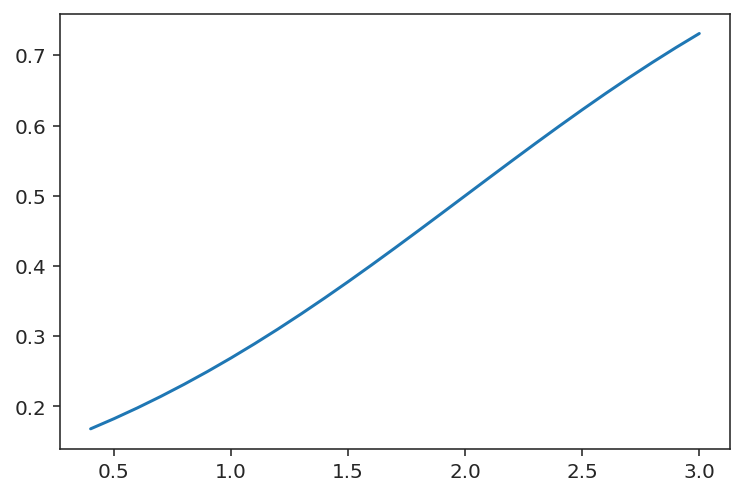

In [256]:
plt.plot(r, sigmoid((r- 2.0)/1.0))

In [254]:
df["entropy-binary-dens-var"] = local_excess_entropy_binary_density_var(r, sfs, dr, alpha=0.62, taper=(1.5, 0.8))
df["entropy-binary-dens-var-correct"] = local_excess_entropy_binary_density_var(r, sfs, dr, alpha=0.5, taper=(2.0, 1.0))
df["entropy-binary-dens-exp-correct"] = local_excess_entropy_binary_density_var_exp(r, sfs, dr, alpha=0.62, taper=(1.5, 0.8), end=-3)
df.iloc[:,5:].corr()

softness   entropy  entropy-binary  \
softness                         1.000000  0.328219        0.347732   
entropy                          0.328219  1.000000        0.707220   
entropy-binary                   0.347732  0.707220        1.000000   
entropy-dens                     0.367026  0.996187        0.704007   
entropy-binary-dens              0.399914  0.704104        0.993293   
entropy-binary-dens-var          0.493027  0.635601        0.829228   
entropy-binary-dens-var-correct  0.458609  0.571676        0.866018   
entropy-binary-dens-exp-correct  0.498989  0.637117        0.835232   

                                 entropy-dens  entropy-binary-dens  \
softness                             0.367026             0.399914   
entropy                              0.996187             0.704104   
entropy-binary                       0.704007             0.993293   
entropy-dens                         1.000000             0.710803   
entropy-binary-dens                  0.710803             1.000000   
entropy-binary-dens-var              0.638460             0.831844   
entropy-binary-dens-var-correct      0.575193             0.868536   
entropy-binary-dens-exp-correct      0.640906             0.839099   

                                 entropy-binary-dens-var  \
softness                                        0.493027   
entropy                                         0.635601   
entropy-binary                                  0.829228   
entropy-dens                                    0.638460   
entropy-binary-dens                             0.831844   
entropy-binary-dens-var                         1.000000   
entropy-binary-dens-var-correct                 0.967835   
entropy-binary-dens-exp-correct                 0.994743   

                                 entropy-binary-dens-var-correct  \
softness                                                0.458609   
entropy                                                 0.571676   
entropy-binary                                          0.866018   
entropy-dens                                            0.575193   
entropy-binary-dens                                     0.868536   
entropy-binary-dens-var                                 0.967835   
entropy-binary-dens-var-correct                         1.000000   
entropy-binary-dens-exp-correct                         0.959152   

                                 entropy-binary-dens-exp-correct  
softness                                                0.498989  
entropy                                                 0.637117  
entropy-binary                                          0.835232  
entropy-dens                                            0.640906  
entropy-binary-dens                                     0.839099  
entropy-binary-dens-var                                 0.994743  
entropy-binary-dens-var-correct                         0.959152  
entropy-binary-dens-exp-correct                         1.000000

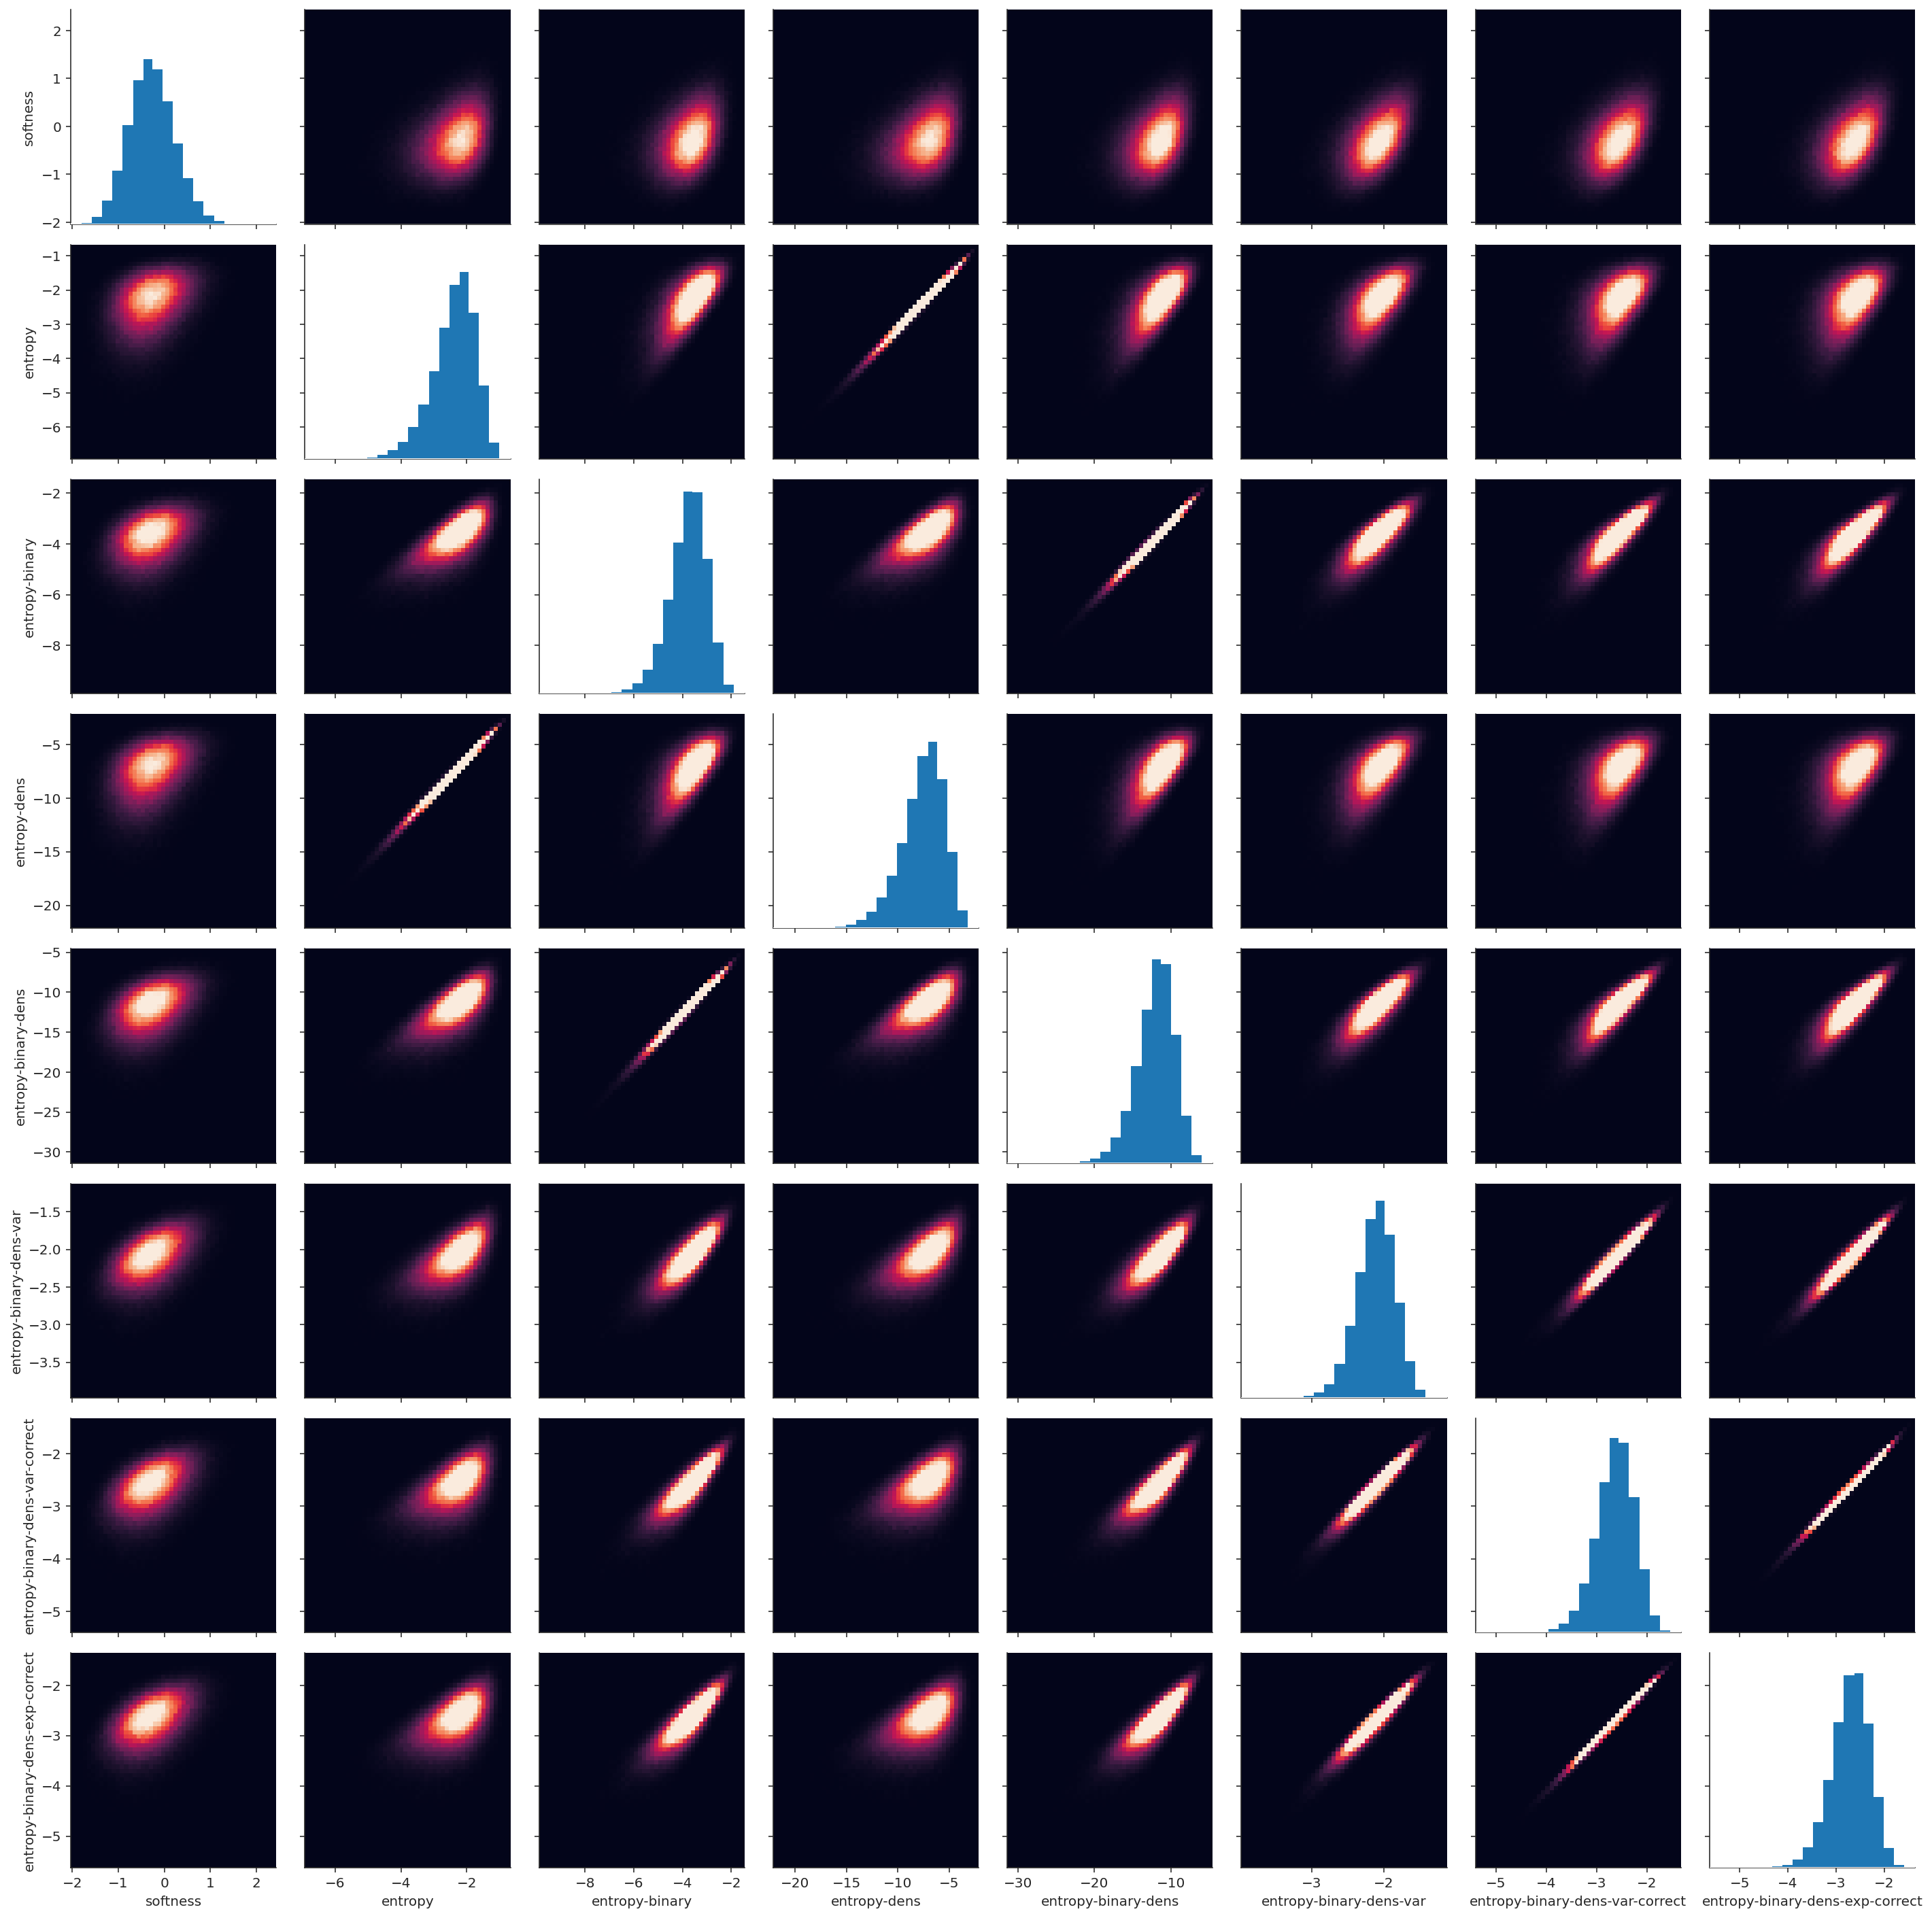

In [244]:
sns.set_style('ticks')
# sns.light_palette("white", as_cmap=True)
g = sns.PairGrid(df.iloc[:, 5:])
g.map_diag(plt.hist, bins=20, histtype="stepfilled")

def pairgrid_heatmap(x, y, **kws):
    plt.hist2d(x, y, cmin=0, linewidths=0, **kws)

g.map_offdiag(pairgrid_heatmap, bins=50, norm=colors.Normalize(), cmap="rocket")

In [54]:
df.loc[:10000, ["softness", "entropy", "entropy-binary"]].corr()

softness   entropy  entropy-binary
softness        1.000000  0.325046        0.341006
entropy         0.325046  1.000000        0.707255
entropy-binary  0.341006  0.707255        1.000000

In [71]:
df.loc[:10000, ["softness", "entropy", "entropy-binary"]].corr("kendall")

softness   entropy  entropy-binary
softness        1.000000  0.218840        0.233802
entropy         0.218840  1.000000        0.490208
entropy-binary  0.233802  0.490208        1.000000

In [72]:
df.loc[:10000, ["softness", "entropy", "entropy-binary"]].corr("spearman")

softness   entropy  entropy-binary
softness        1.000000  0.323903        0.343933
entropy         0.323903  1.000000        0.675929
entropy-binary  0.343933  0.675929        1.000000

In [132]:
cmap = cm.jet
norm = colors.Normalize(be[0], be[-1])

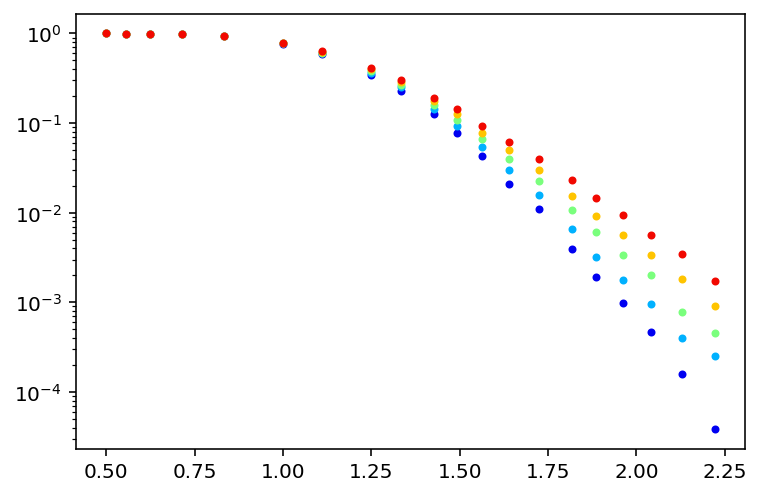

In [134]:
for t, data in zip(temps, plot_data):
    for d in data:
        plt.plot(1/t, d[1], color=cmap(norm(d[0])), marker=".")
plt.yscale('log')

In [58]:
df.head()

frame  tag  type      phop  \
0      0    0     0  0.001464   
4      0    4     0  0.004224   
6      0    6     0  0.001102   
7      0    7     0  0.001166   
8      0    8     0  0.001056   

                                                  sf  softness  rearrang  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.05785978, 0.002419... -0.217634     False   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.029464645, 0.0, 0.... -0.505980     False   
6  [0.0, 0.0, 0.0, 0.0, 0.0, 0.014470028, 0.00319...  0.018828     False   
7  [0.0, 0.0, 0.0, 0.0, 0.0, 0.04285976, 0.0, 0.4... -1.075131     False   
8  [0.0, 0.0, 0.0, 0.0, 0.0, 0.027678886, 0.00742... -0.205953     False   

              cuts  
0  (-0.726, 0.057]  
4  (-0.726, 0.057]  
6  (-0.726, 0.057]  
7  (-1.51, -0.726]  
8  (-0.726, 0.057]

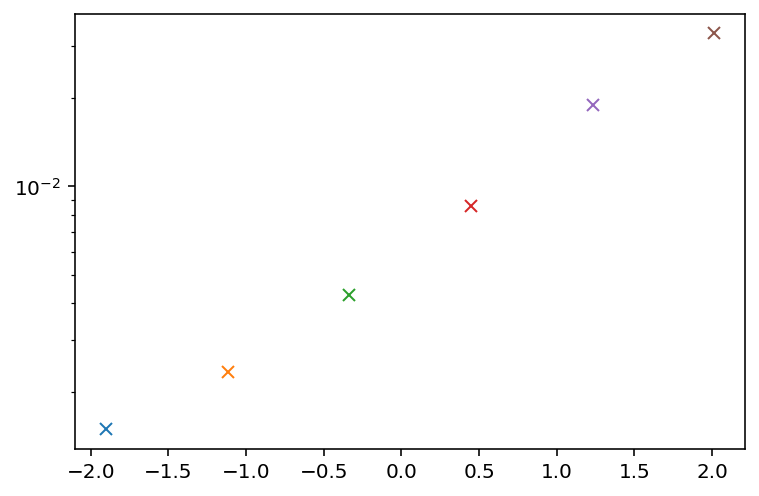

In [60]:
fig, ax = plt.subplots()
tdf = df[["phop", "cuts"]]
phop_desc = tdf["phop"].describe()
for cut, tdf in tdf.groupby("cuts"):
    # tdf.hist("phop", bins=np.geomspace(0.0001, 1, 25), ax=ax)
    plt.plot(cut.mid, tdf["phop"].mean(), "x", label=cut)
plt.yscale('log')

In [36]:
phop_desc.max()

235935.0

In [28]:
np.max(df["phop"])

0.8097302

In [10]:
(df["phop"] > 0.2).mean()

0.0008349757348422235

Text(0.5, 0, '$p_{hop}$')

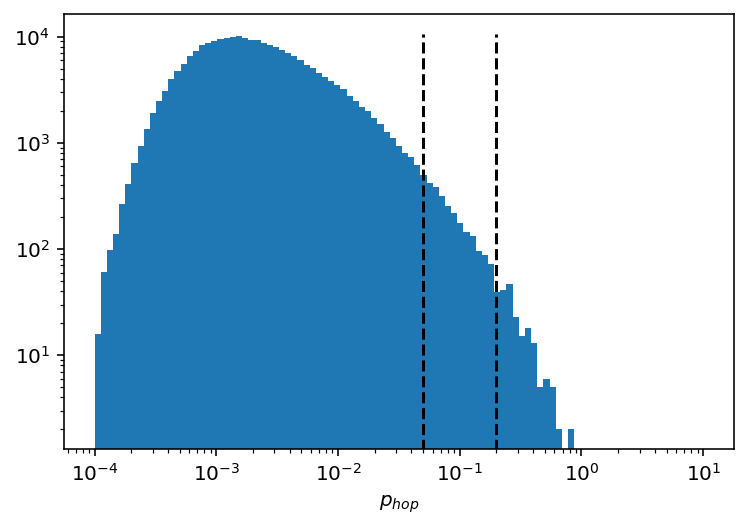

In [15]:
plt.hist(df["phop"], bins=np.geomspace(1e-4, 10, 100))
plt.xscale('log')
lim = plt.ylim()
plt.vlines(0.2, *lim, linestyles="dashed", color="k")
plt.vlines(0.05, *lim, linestyles="dashed", color="k")
plt.yscale('log')
plt.xlabel(r'$p_{hop}$')

# Figure 5 - Group particle by softness and map softness to binary excess entropy

In [66]:
r_be = np.linspace(0.1, 5.0, 246)
r_bc = r_be[:-1] + np.diff(r_be)/2
# r_bc

In [56]:
def _default_array():
    return np.zeros_like(r_bc)


for delta, jobs_iter in project.find_jobs(None, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):

    phi = delta_to_phi(delta)

    print(delta)

    jobs = list(jobs_iter)

    job0 = jobs[0]
    temps = job0.doc["temps"]

    with open(project.fn(f"softness_pipelines/delta-{delta:.1f}/pipe_ss-0_ts-10.pickle"), "rb") as f:
        pipeline = pickle.load(f)
    pipe = pipeline["pipe"]

    bounds_file = project.fn(f"structure/softness-bounds_delta-{delta}.pickle")
    if os.path.exists(bounds_file):
        softness_bounds = pickle.load(open(bounds_file, "rb"))
    else:
        raise Exception("No bounds file")

    plot_data = []

    be = np.linspace(softness_bounds["min"], softness_bounds["max"], 31)
    soft_bin_centers = be[:-1] + np.diff(be)/2

    rearrang_file = project.fn(f"prob_rearrang/rdfs-bin-softness_delta-{delta}.pickle")
    
    itemps = []
    rearrang_data = []
    for temp in sorted(temps[11:-2]):
        itemps.append(1/temp)
        print(temp)
        trajs = []
        dfs = []
        for idx, job in enumerate(jobs):
            files = glob.glob(job.fn(f"short_runs/temp-{temp:.2f}/sfs.parquet"))
            if len(files) == 0:
                raise Exception("No files")
            assert len(files) == 1
            file = files[0]
            traj = file.replace("sfs.parquet", "traj.gsd")
            trajs.append(gsd.hoomd.open(traj))
            df = pd.read_parquet(file)
            df = df[df["type"] == 0]
            df["traj_idx"] = idx
            dfs.append(df)
        df = pd.concat(dfs)

        df["softness"] = pipe.decision_function(list(df["sf"]))
        df.drop("sf", axis=1, inplace=True)

        df["rearrang"] = df["phop"] > 0.2

        df["cuts"] = pd.cut(df["softness"], bins=be)

        data = []
        cuts = []

        for cut, df_cut in df.groupby("cuts"):
            cuts.append(cut.mid)
            data.append(df_cut["rearrang"].mean())
        data.append(data)

        rdf_a = defaultdict(_default_array)
        rdf_b = defaultdict(_default_array)

        vol = 4/3*np.pi*r_be[-1]**3
        shells = 4*np.pi*r_bc**2*(r_be[1] - r_be[0])

        for (traj_idx, frame), tdf in df.groupby(["traj_idx", "frame"]):
            # print(frame)
            snap: gsd.hoomd.Snapshot = trajs[traj_idx][int(frame)]
            box = freud.box.Box.from_box(snap.configuration.box)
            pos = snap.particles.position
            pos_a = pos[snap.particles.typeid == 0]
            pos_b = pos[snap.particles.typeid == 1]
            nlist_query_a = freud.locality.AABBQuery.from_system((box, pos_a))
            nlist_query_b = freud.locality.AABBQuery.from_system((box, pos_b))
            
            for soft, ttdf in tdf.groupby("cuts"):
                id = ttdf["tag"].to_numpy()
                nlist_a = nlist_query_a.query(pos[id], dict(r_max=5.0, r_min=0.1)).toNeighborList()
                nlist_b = nlist_query_b.query(pos[id], dict(r_max=5.0, r_min=0.1)).toNeighborList()
                rdf_a[float(soft.mid)] += bin_linspaced_data(nlist_a.distances, r_be[0], r_be[-1], len(r_be)-1)
                rdf_b[float(soft.mid)] += bin_linspaced_data(nlist_b.distances, r_be[0], r_be[-1], len(r_be)-1)
            del snap

        final_data = {}
        final_data["rdfs"] = {}
        
        for c in cuts:
            rdf = rdf_a[c]
            g_a = rdf/shells/np.sum(rdf)*vol
            rdf = rdf_b[c]
            g_b = rdf/shells/np.sum(rdf)*vol
            final_data["rdfs"][c] = dict(g_a=g_a, g_b=g_b)

        final_data["cuts"] = cuts
        final_data["rearrang"] = data

        rearrang_data.append(final_data)
    
    pickle_data = dict(inv_t=itemps, data=rearrang_data, r_bc=r_bc, r_be=r_be, phi=phi, cuts=soft_bin_centers)
    pickle.dump(pickle_data, open(rearrang_file, "wb"))


0.0
0.45


In [67]:
def _default_array():
    return np.zeros_like(r_bc)


for delta, jobs_iter in project.find_jobs(None, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):

    phi = delta_to_phi(delta)

    print(delta)

    jobs = list(jobs_iter)

    job0 = jobs[0]
    temps = job0.doc["temps"]

    with open(project.fn(f"softness_pipelines/delta-{delta:.1f}/pipe_ss-0_ts-10.pickle"), "rb") as f:
        pipeline = pickle.load(f)
    pipe = pipeline["pipe"]

    bounds_file = project.fn(f"structure/softness-bounds_delta-{delta}.pickle")
    if os.path.exists(bounds_file):
        softness_bounds = pickle.load(open(bounds_file, "rb"))
    else:
        raise Exception("No bounds file")

    plot_data = []

    be = np.linspace(softness_bounds["min"], softness_bounds["max"], 31)
    soft_bin_centers = be[:-1] + np.diff(be)/2

    rearrang_file = project.fn(f"prob_rearrang/rdfs-bin-softness-fire_delta-{delta}.pickle")
    
    itemps = []
    rearrang_data = []
    for temp in sorted(temps[11:-2]):
        itemps.append(1/temp)
        print(temp)
        trajs = []
        dfs = []
        for idx, job in enumerate(jobs):
            files = glob.glob(job.fn(f"short_runs/temp-{temp:.2f}/sfs.parquet"))
            if len(files) == 0:
                raise Exception("No files")
            assert len(files) == 1
            file = files[0]
            traj = file.replace("sfs.parquet", "fire_traj.gsd")
            trajs.append(gsd.hoomd.open(traj))
            df = pd.read_parquet(file)
            df = df[df["type"] == 0]
            df["traj_idx"] = idx
            dfs.append(df)
        df = pd.concat(dfs)

        df["softness"] = pipe.decision_function(list(df["sf"]))
        df.drop("sf", axis=1, inplace=True)

        df["rearrang"] = df["phop"] > 0.2

        df["cuts"] = pd.cut(df["softness"], bins=be)

        data = []
        cuts = []

        for cut, df_cut in df.groupby("cuts"):
            cuts.append(cut.mid)
            data.append(df_cut["rearrang"].mean())
        data.append(data)

        rdf_a = defaultdict(_default_array)
        rdf_b = defaultdict(_default_array)

        vol = 4/3*np.pi*r_be[-1]**3
        shells = 4*np.pi*r_bc**2*(r_be[1] - r_be[0])

        for (traj_idx, frame), tdf in df.groupby(["traj_idx", "frame"]):
            # print(frame)
            snap: gsd.hoomd.Snapshot = trajs[traj_idx][int(frame)]
            box = freud.box.Box.from_box(snap.configuration.box)
            pos = snap.particles.position
            pos_a = pos[snap.particles.typeid == 0]
            pos_b = pos[snap.particles.typeid == 1]
            nlist_query_a = freud.locality.AABBQuery.from_system((box, pos_a))
            nlist_query_b = freud.locality.AABBQuery.from_system((box, pos_b))
            
            for soft, ttdf in tdf.groupby("cuts"):
                id = ttdf["tag"].to_numpy()
                nlist_a = nlist_query_a.query(pos[id], dict(r_max=5.0, r_min=0.1)).toNeighborList()
                nlist_b = nlist_query_b.query(pos[id], dict(r_max=5.0, r_min=0.1)).toNeighborList()
                rdf_a[float(soft.mid)] += bin_linspaced_data(nlist_a.distances, r_be[0], r_be[-1], len(r_be)-1)
                rdf_b[float(soft.mid)] += bin_linspaced_data(nlist_b.distances, r_be[0], r_be[-1], len(r_be)-1)
            del snap

        final_data = {}
        final_data["rdfs"] = {}
        
        for c in cuts:
            rdf = rdf_a[c]
            g_a = rdf/shells/np.sum(rdf)*vol
            rdf = rdf_b[c]
            g_b = rdf/shells/np.sum(rdf)*vol
            final_data["rdfs"][c] = dict(g_a=g_a, g_b=g_b)

        final_data["cuts"] = cuts
        final_data["rearrang"] = data

        rearrang_data.append(final_data)
    
    pickle_data = dict(inv_t=itemps, data=rearrang_data, r_bc=r_bc, r_be=r_be, phi=phi, cuts=soft_bin_centers)
    pickle.dump(pickle_data, open(rearrang_file, "wb"))


0.0
0.45
0.47
0.49
0.51
0.53
0.55
0.58
0.61
0.64
0.1
0.56
0.59
0.61
0.64
0.67
0.69
0.73
0.77
0.8
0.2
0.73
0.76
0.8
0.83
0.86
0.89
0.94
0.99
1.04
0.3
0.99
1.03
1.08
1.12
1.16
1.21
1.27
1.34
1.41
0.4
1.42
1.48
1.54
1.6
1.67
1.73
1.82
1.92
2.01


In [53]:
list(rdf_a.keys())

[-0.933,
 -0.881,
 -0.8295,
 -0.778,
 -0.726,
 -0.6745,
 -0.623,
 -0.571,
 -0.5195000000000001,
 -0.46799999999999997,
 -0.41600000000000004,
 -0.36450000000000005,
 -0.313,
 -0.261,
 -0.2095,
 -0.158,
 -0.1061,
 -0.054349999999999996,
 -0.0026500000000000013,
 0.049,
 0.1009,
 0.1525,
 0.20400000000000001,
 0.256,
 0.3075,
 0.359,
 0.41100000000000003,
 0.4625,
 0.514,
 0.5660000000000001,
 -0.9435]

In [1]:
g_a = rdf_a[0.1009]
g_b = rdf_b[0.1009]



plt.plot(r_bc, g_a/shells/np.sum(g_a)*vol)
plt.plot(r_bc, g_b/shells/np.sum(g_b)*vol)

NameError: name 'rdf_a' is not defined

In [11]:
file = "/media/ian/Data2/monk/mlj-production/prob_rearrang/rdfs-bin-softness_delta-0.1.pickle"

data = pickle.load(open(file, "rb"))

In [13]:
list(data.keys())

['inv_t', 'data', 'r_bc', 'r_be', 'phi', 'cuts']

In [20]:
list(data["data"][0].keys())

['rdfs', 'cuts', 'rearrang']

In [22]:
data["cuts"]

array([-0.88858913, -0.83889398, -0.78919884, -0.73950369, -0.68980855,
       -0.6401134 , -0.59041825, -0.54072311, -0.49102796, -0.44133282,
       -0.39163767, -0.34194253, -0.29224738, -0.24255224, -0.19285709,
       -0.14316195, -0.0934668 , -0.04377166,  0.00592349,  0.05561863,
        0.10531378,  0.15500892,  0.20470407,  0.25439921,  0.30409436,
        0.3537895 ,  0.40348465,  0.45317979,  0.50287494,  0.55257008])

In [23]:
np.array(data["data"][0]["cuts"])

array([-0.8885 , -0.839  , -0.789  , -0.7395 , -0.69   , -0.64   ,
       -0.5905 , -0.541  , -0.491  , -0.441  , -0.3915 , -0.342  ,
       -0.292  , -0.2425 , -0.193  , -0.143  , -0.0933 , -0.04375,
        0.00595,  0.05565,  0.10525,  0.155  ,  0.205  ,  0.2545 ,
        0.304  ,  0.354  ,  0.4035 ,  0.453  ,  0.503  ,  0.5525 ])

In [40]:
fits = []

itemps = data["inv_t"]
for i in range(len(data["cuts"])):
    rearrang = [d["rearrang"][i] for d in data["data"]]
    p = np.polyfit(itemps, np.log(rearrang), 1)

    fits.append(p)

fits = np.array(fits)

/tmp/ipykernel_169651/1175479928.py:6: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)


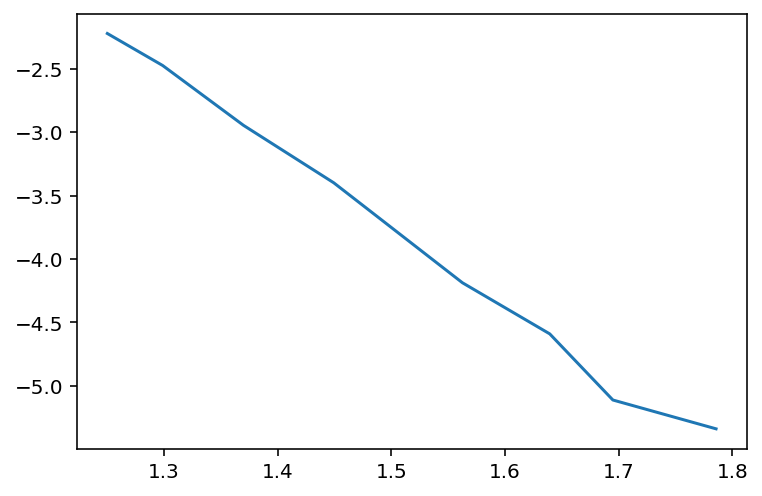

In [38]:
plt.plot(itemps, np.log(rearrang))

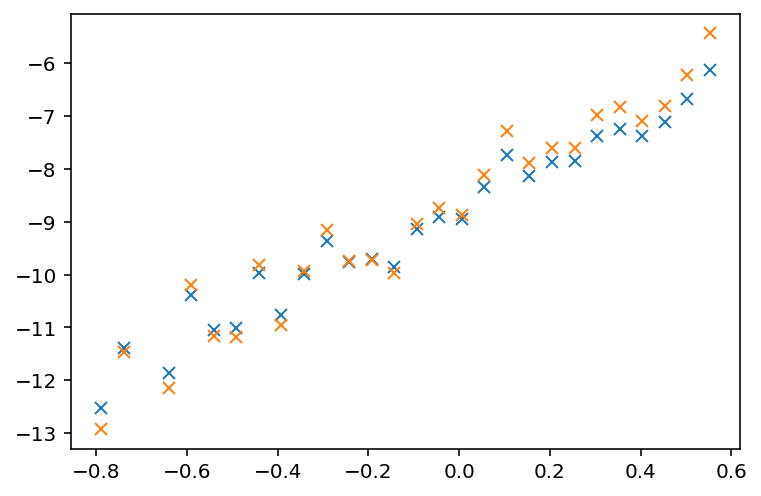

In [41]:
plt.plot(data["cuts"], fits[:,0], "x")
plt.plot(data["cuts"], -fits[:,1], "x")

/tmp/ipykernel_2291988/2678397648.py:16: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)


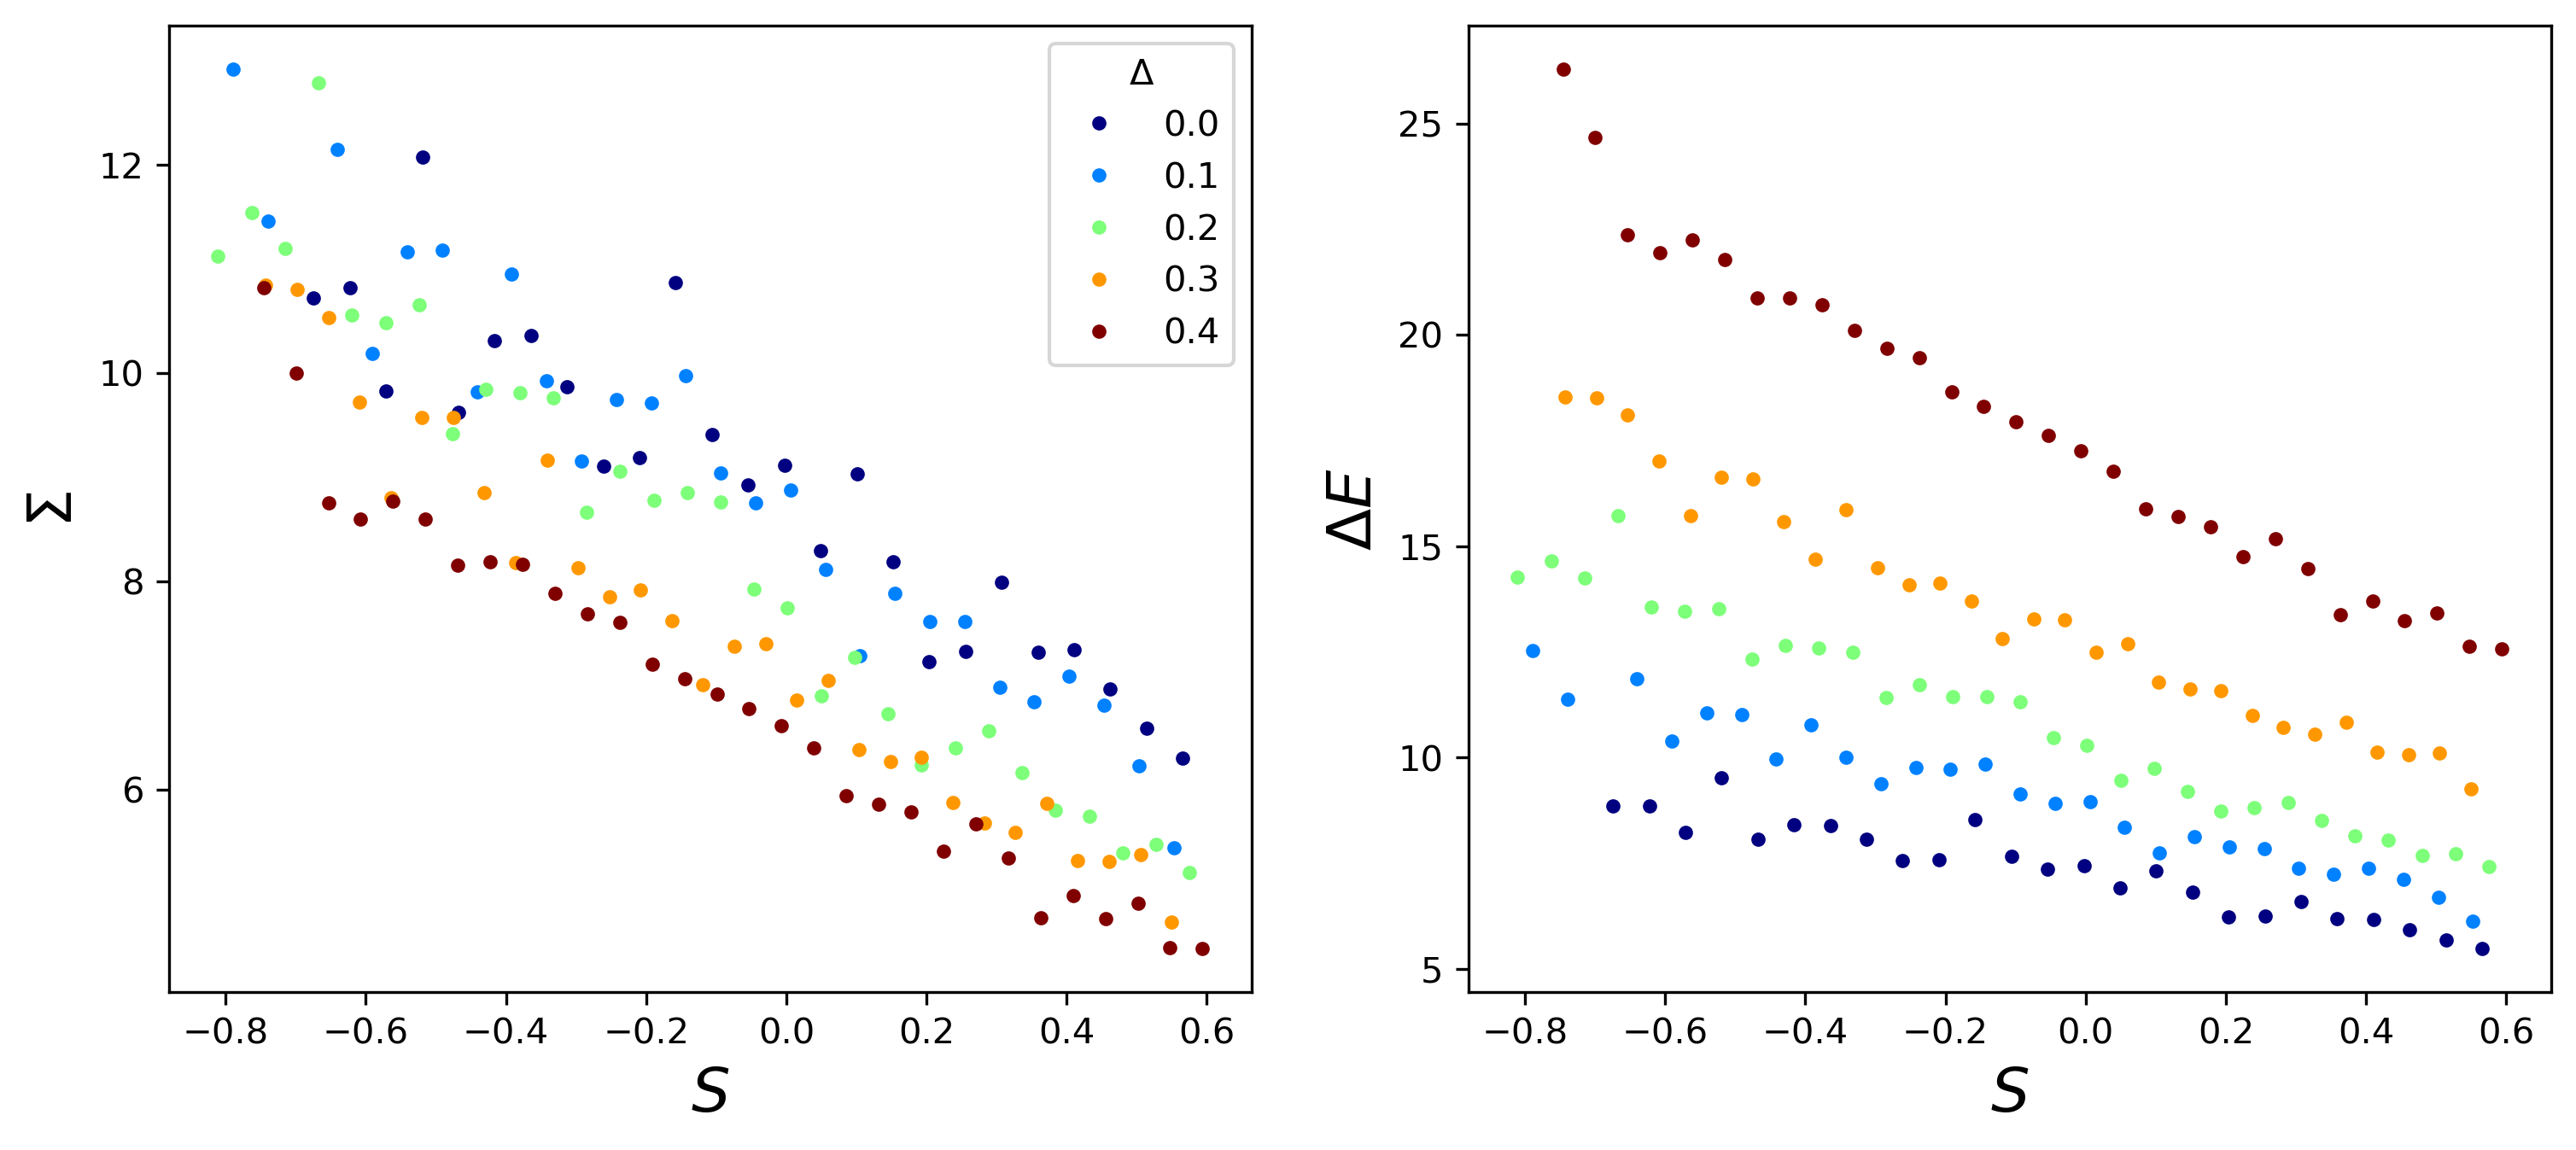

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

cmap = cm.jet
norm = colors.Normalize(vmin=0.0, vmax=0.4)

for delta in [0.0, 0.1, 0.2, 0.3, 0.4]:
    file = project.fn(f"prob_rearrang/rdfs-bin-softness_delta-{delta}.pickle")

    data = pickle.load(open(file, "rb"))

    fits = []

    itemps = data["inv_t"]
    for i in range(len(data["cuts"])):
        rearrang = [d["rearrang"][i] for d in data["data"]]
        p = np.polyfit(itemps, np.log(rearrang), 1)

        fits.append(p)

    fits = np.array(fits)

    axs[0].plot(data["cuts"], fits[:,1], ".", linestyle="", label=f"{delta:.1f}", color=cmap(norm(delta)))
    axs[1].plot(data["cuts"], -fits[:,0], ".", linestyle="", label=f"{delta:.1f}", color=cmap(norm(delta)))

axs[0].set_xlabel(r"$S$", size="xx-large")
axs[1].set_ylabel(r"$\Delta E$", size="xx-large")
plt.sca(axs[0])
plt.legend(title=r"$\Delta$")

axs[1].set_xlabel(r"$S$", size="xx-large")
axs[0].set_ylabel(r"$\Sigma$", size="xx-large")

plt.savefig("pres2.png", dpi=200)

/tmp/ipykernel_2291988/2105425969.py:26: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2291988/2105425969.py:26: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2291988/2105425969.py:26: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2291988/2105425969.py:26: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2291988/2105425969.py:26: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2291988/2105425969.py:26: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2291988/2105425969.py:26: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2291988/2105425969.py:26: 

Text(0, 0.5, '$\\Sigma$')

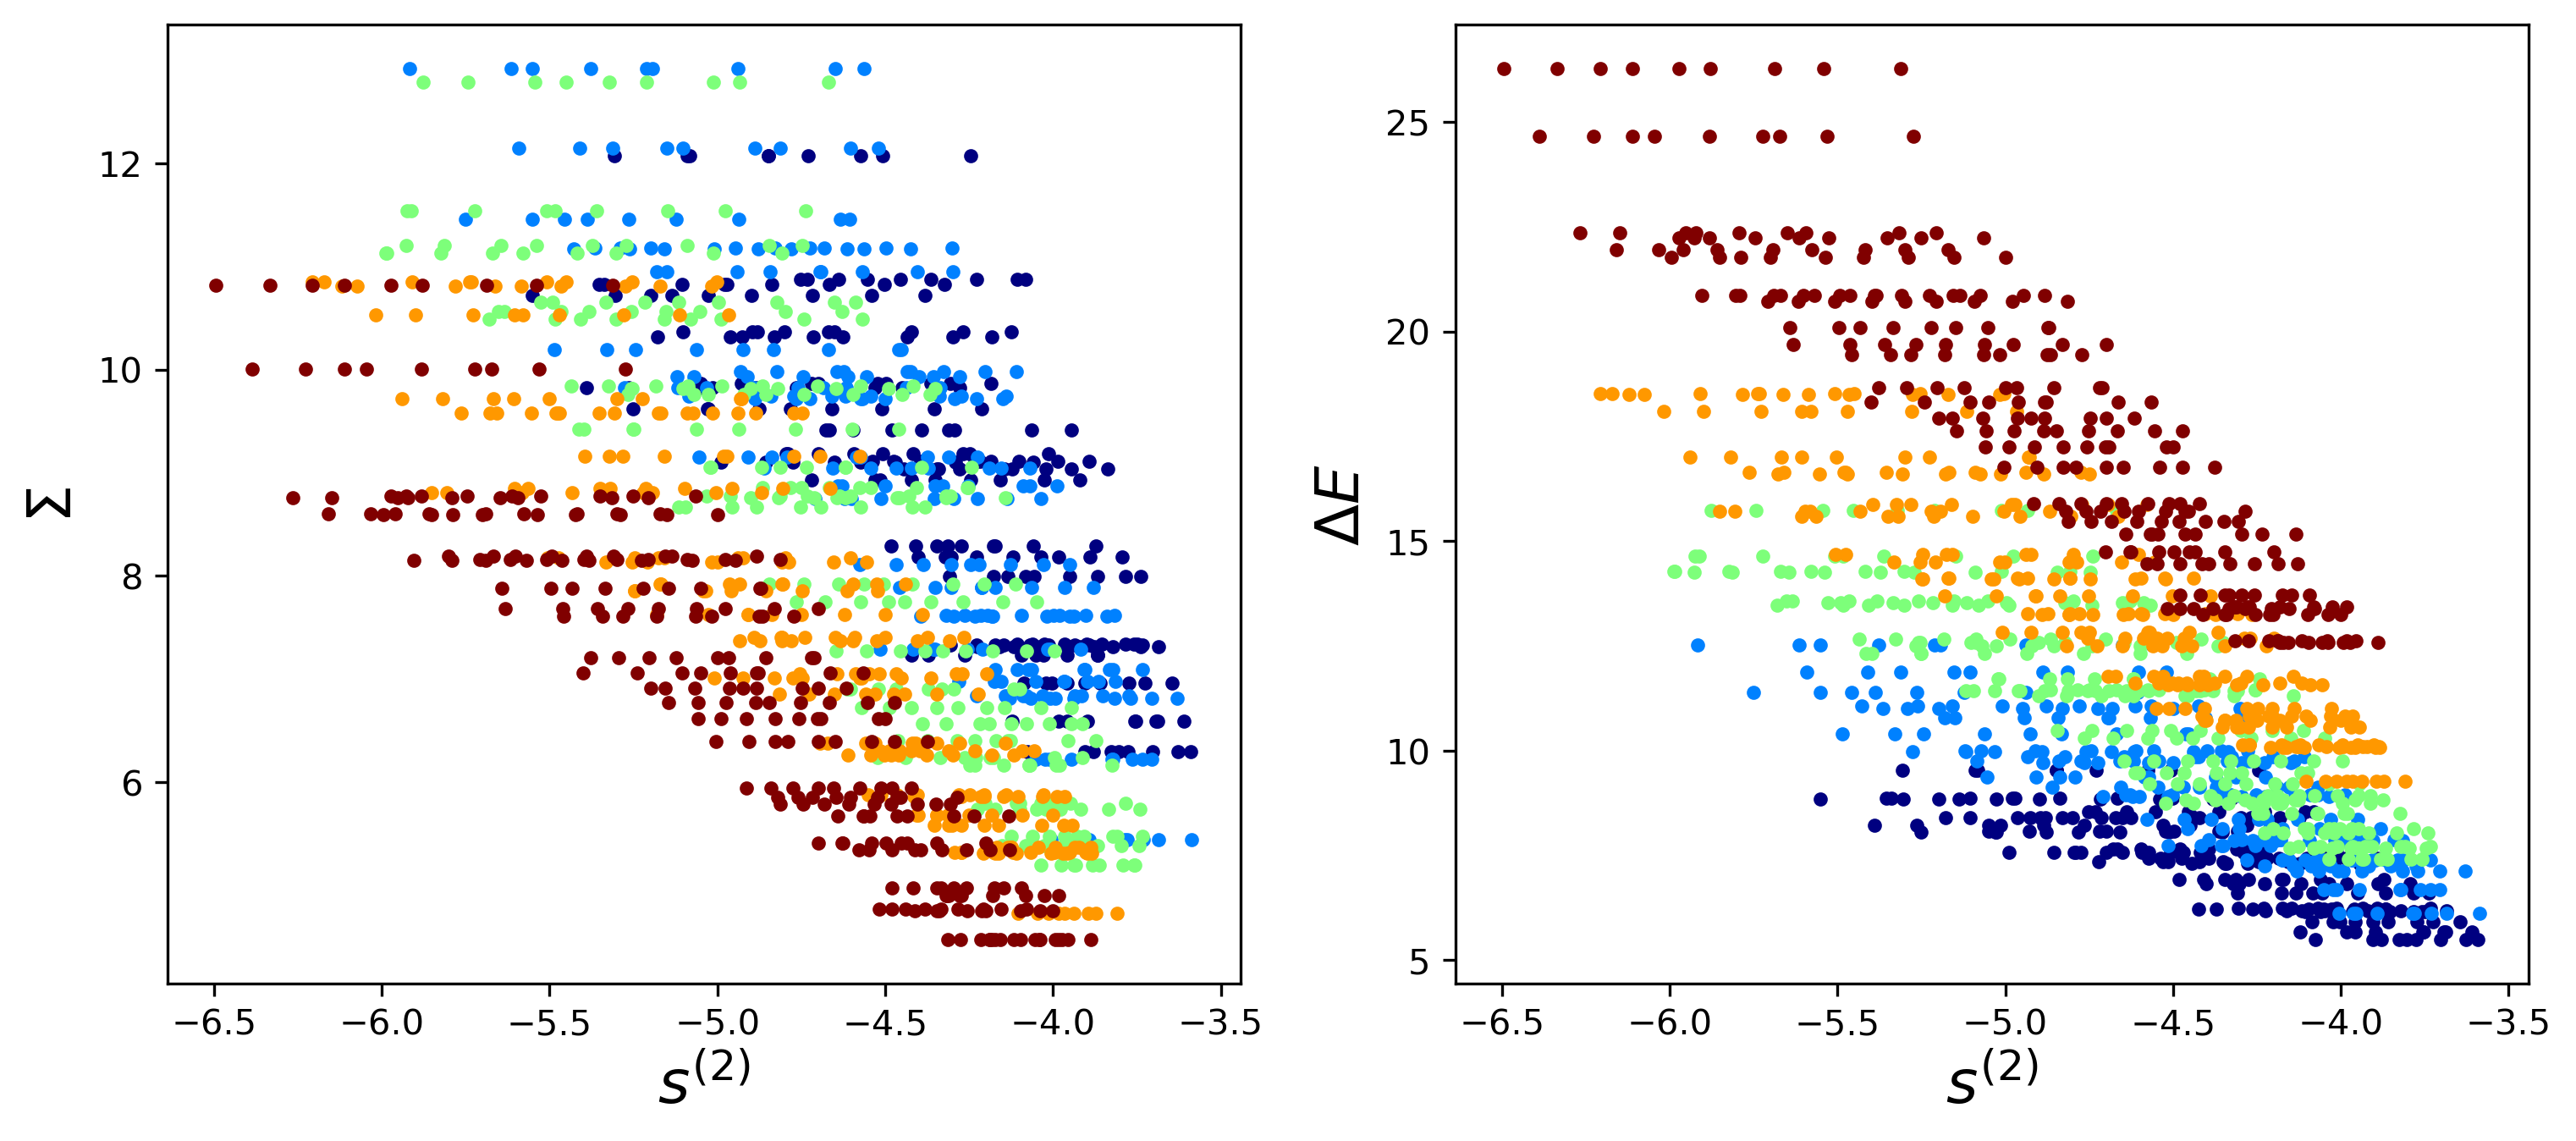

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=150)
cmap = cm.jet
norm = colors.Normalize(0.0, 0.4)

for delta in [0.0, 0.1, 0.2, 0.3, 0.4]:
    file = project.fn(f"prob_rearrang/rdfs-bin-softness_delta-{delta}.pickle")

    data = pickle.load(open(file, "rb"))

    itemps = data["inv_t"]
    in_cuts = data["data"][0]["cuts"]
    f_a = 0.8
    f_b = 0.2
    r = data["r_bc"]
    phi = data["phi"]
    for j in range(len(itemps)):
        fits = []
        entropy = []
        for i in range(len(data["cuts"])):
            rearrang = [d["rearrang"][i] for d in data["data"]]
            g_a = data["data"][j]["rdfs"][in_cuts[i]]["g_a"]
            g_b = data["data"][j]["rdfs"][in_cuts[i]]["g_b"]
            s = pair_excess_entropy_binary(g_a, g_b, f_a, f_b, r, phi)
            # s = pair_excess_entropy_binary(0.8*g_a + 0.2*g_b, r, phi)
            entropy.append(s)
            p = np.polyfit(itemps, np.log(rearrang), 1)

            fits.append(p)

        soft = pickle.load(open(project.fn(f"prob_rearrang/fit_softness_delta-{delta}.pickle"), "rb"))

        def reject_outliers(sr, iq_range=0.8):
            pcnt = (1 - iq_range) / 2
            qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
            iqr = qhigh - qlow
            return sr[ (sr - median).abs() <= iqr]

        data1 = []
        keys = list(soft["data"].keys())
        for i in range(len(keys)-1):
            v1 = soft["data"][keys[i]]["p"]
            for j in range(i+1, len(keys)):
                v2 = soft["data"][keys[j]]["p"]
                data1.append((v2[1] - v1[1]) / (v1[0] - v2[0]))
        T_a = np.mean(reject_outliers(pd.Series(data1)).to_numpy())

        fits = np.array(fits)

        axs[0].plot(entropy, fits[:,1], ".", linestyle="", label=f"{delta:.1f}", color=cmap(norm(delta)))
        axs[1].plot(entropy, -fits[:,0], ".", linestyle="", label=f"{delta:.1f}", color=cmap(norm(delta)))

axs[0].set_xlabel(r"$s^{(2)}$", size="xx-large")
axs[1].set_ylabel(r"$\Delta E$", size="xx-large")
# plt.sca(axs[0])
# plt.legend(title=r"$\Delta$")

axs[1].set_xlabel(r"$s^{(2)}$", size="xx-large")
axs[0].set_ylabel(r"$\Sigma$", size="xx-large")

/tmp/ipykernel_2291988/1652662603.py:26: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2291988/1652662603.py:26: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2291988/1652662603.py:26: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2291988/1652662603.py:26: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2291988/1652662603.py:26: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2291988/1652662603.py:26: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2291988/1652662603.py:26: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2291988/1652662603.py:26: 

Text(0, 0.5, '$\\Sigma$')

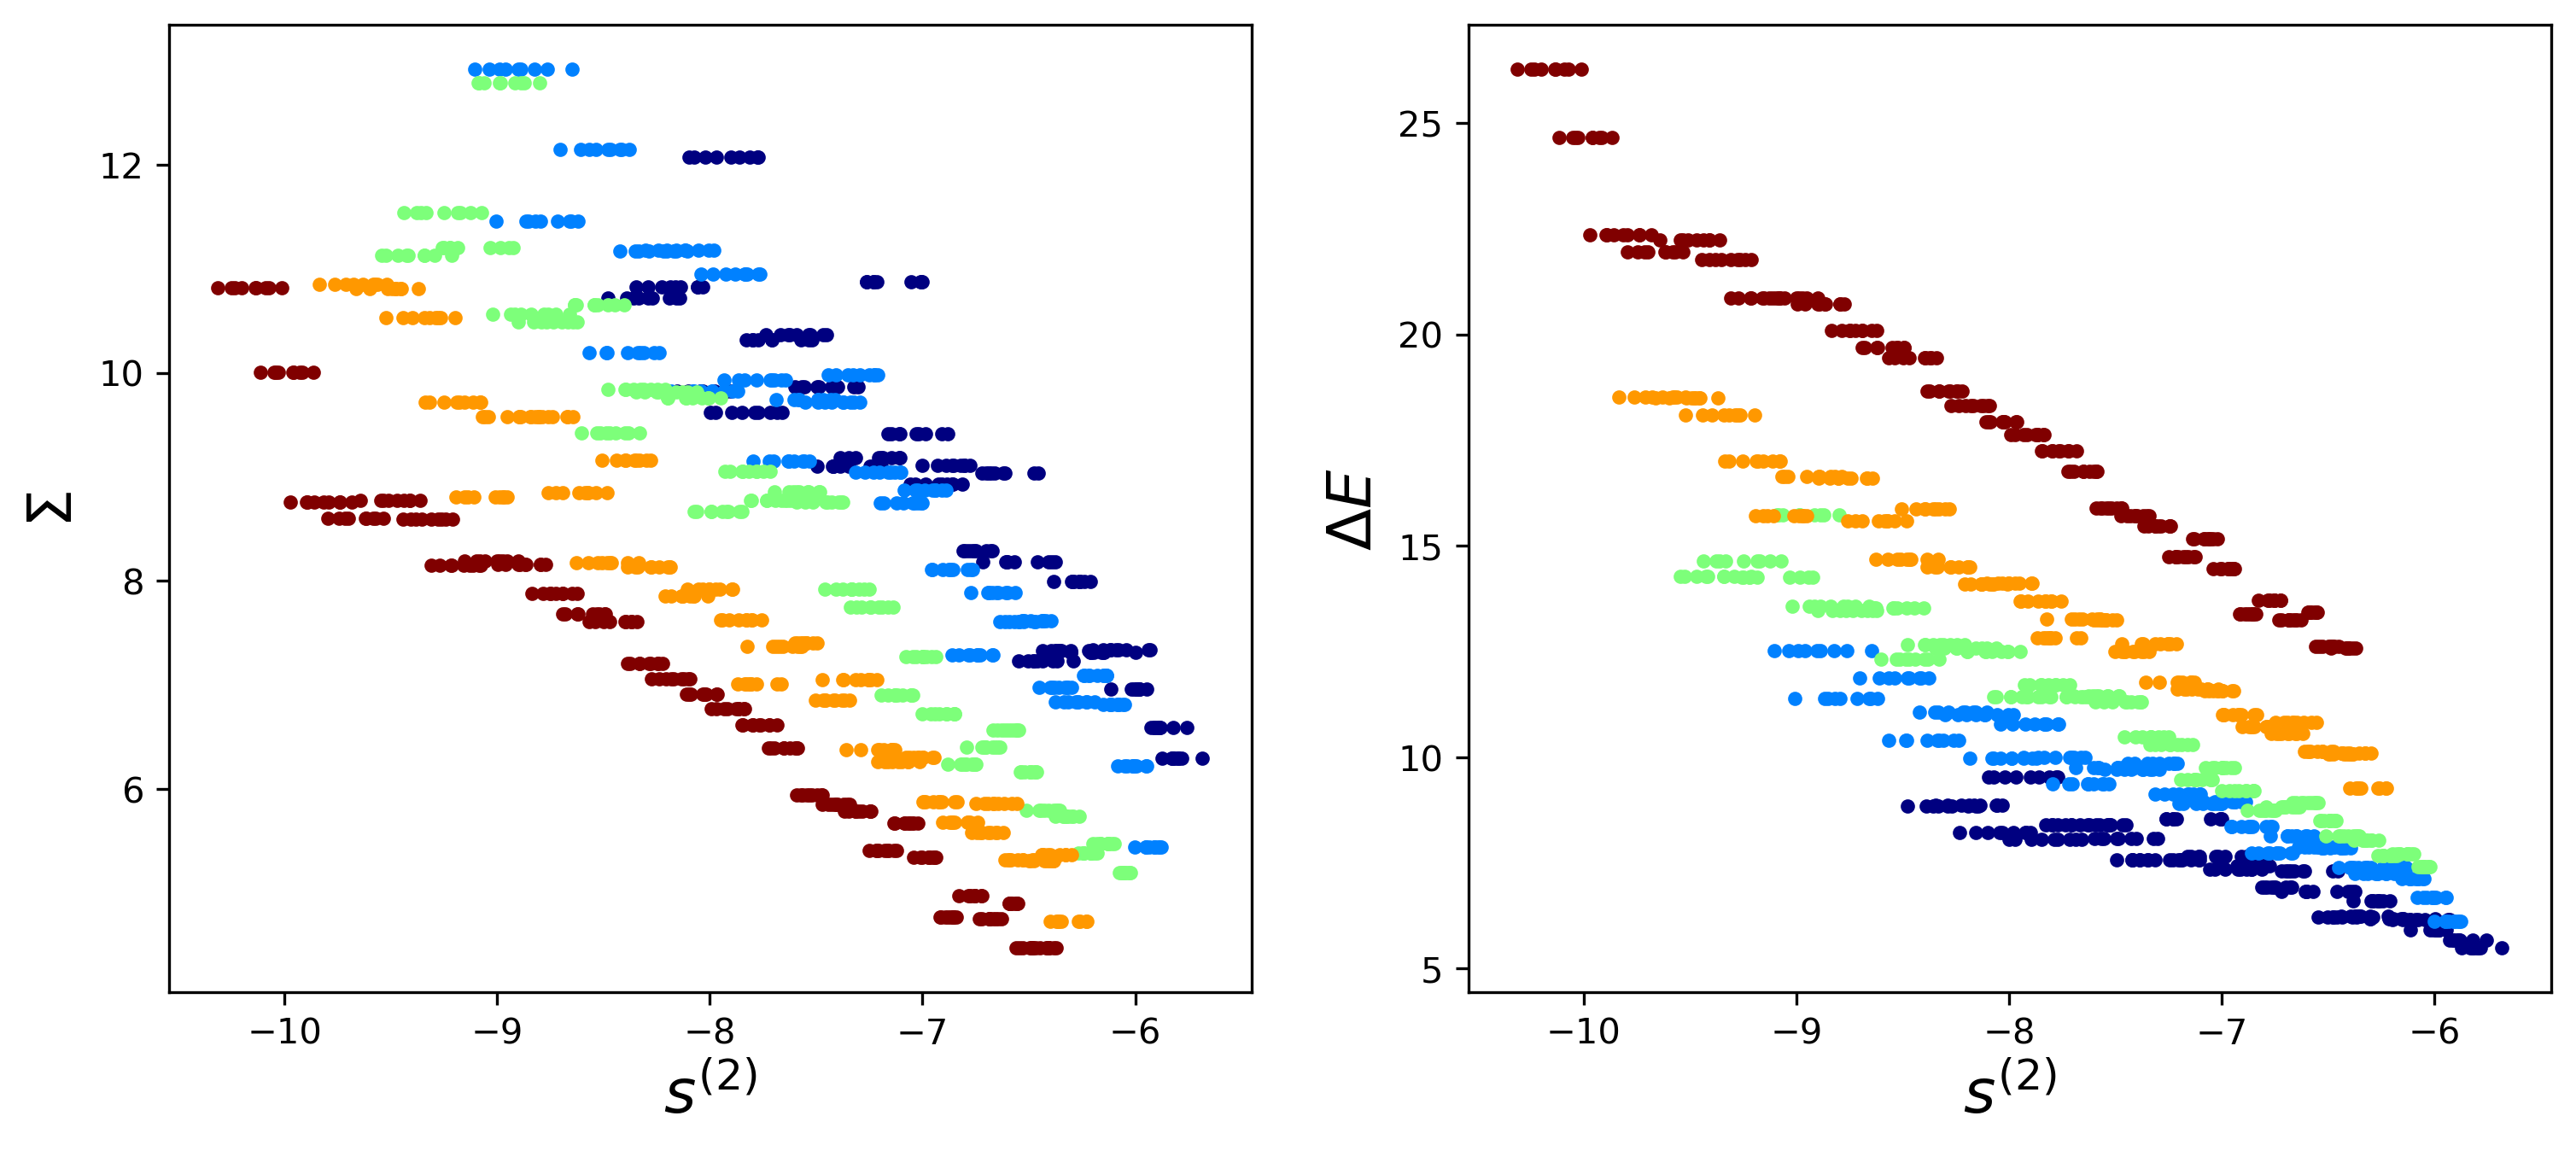

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=150)
cmap = cm.jet
norm = colors.Normalize(0.0, 0.4)

for delta in [0.0, 0.1, 0.2, 0.3, 0.4]:
    file = project.fn(f"prob_rearrang/rdfs-bin-softness-fire_delta-{delta}.pickle")

    data = pickle.load(open(file, "rb"))

    itemps = data["inv_t"]
    in_cuts = data["data"][0]["cuts"]
    f_a = 0.8
    f_b = 0.2
    r = data["r_bc"]
    phi = data["phi"]
    for j in range(len(itemps)):
        fits = []
        entropy = []
        for i in range(len(data["cuts"])):
            rearrang = [d["rearrang"][i] for d in data["data"]]
            g_a = data["data"][j]["rdfs"][in_cuts[i]]["g_a"]
            g_b = data["data"][j]["rdfs"][in_cuts[i]]["g_b"]
            s = pair_excess_entropy_binary(g_a, g_b, f_a, f_b, r, phi)
            # s = pair_excess_entropy_binary(0.8*g_a + 0.2*g_b, r, phi)
            entropy.append(s)
            p = np.polyfit(itemps, np.log(rearrang), 1)

            fits.append(p)

        soft = pickle.load(open(project.fn(f"prob_rearrang/fit_softness_delta-{delta}.pickle"), "rb"))

        def reject_outliers(sr, iq_range=0.8):
            pcnt = (1 - iq_range) / 2
            qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
            iqr = qhigh - qlow
            return sr[ (sr - median).abs() <= iqr]

        data1 = []
        keys = list(soft["data"].keys())
        for i in range(len(keys)-1):
            v1 = soft["data"][keys[i]]["p"]
            for j in range(i+1, len(keys)):
                v2 = soft["data"][keys[j]]["p"]
                data1.append((v2[1] - v1[1]) / (v1[0] - v2[0]))
        T_a = np.mean(reject_outliers(pd.Series(data1)).to_numpy())

        fits = np.array(fits)

        axs[0].plot(entropy, fits[:,1], ".", linestyle="", label=f"{delta:.1f}", color=cmap(norm(delta)))
        axs[1].plot(entropy, -fits[:,0], ".", linestyle="", label=f"{delta:.1f}", color=cmap(norm(delta)))

axs[0].set_xlabel(r"$s^{(2)}$", size="xx-large")
axs[1].set_ylabel(r"$\Delta E$", size="xx-large")
# plt.sca(axs[0])
# plt.legend(title=r"$\Delta$")

axs[1].set_xlabel(r"$s^{(2)}$", size="xx-large")
axs[0].set_ylabel(r"$\Sigma$", size="xx-large")

/tmp/ipykernel_2797781/4033523863.py:35: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2797781/4033523863.py:35: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2797781/4033523863.py:35: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2797781/4033523863.py:35: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2797781/4033523863.py:35: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2797781/4033523863.py:35: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2797781/4033523863.py:35: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2797781/4033523863.py:35: 

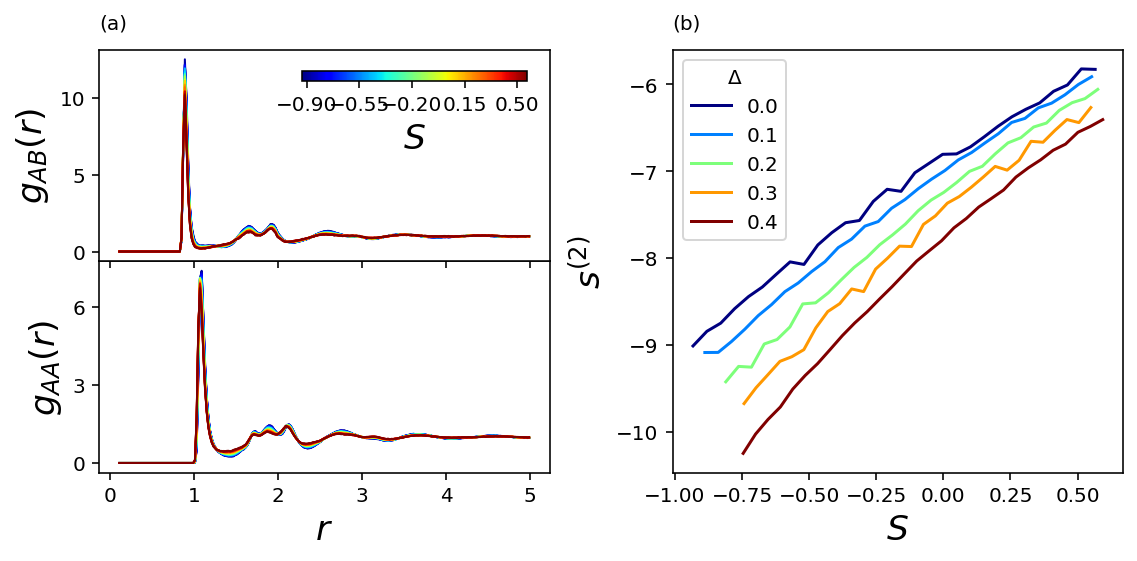

In [53]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator

fig, axs = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)

divider = make_axes_locatable(axs[0])
axdiv = divider.append_axes("top", size="100%", pad=0.0, sharex=axs[0])

cmap = cm.jet
norm = colors.Normalize(0.0, 0.4)

for delta in [0.0, 0.1, 0.2, 0.3, 0.4]:
    file = project.fn(f"prob_rearrang/rdfs-bin-softness-fire_delta-{delta}.pickle")
    data = pickle.load(open(file, "rb"))

    itemps = data["inv_t"]
    in_cuts = data["data"][0]["cuts"]
    f_a = 0.8
    f_b = 0.2
    r = data["r_bc"]
    phi = data["phi"]
    fits = []
    entropy = []

    if delta == 0.0:
        scmap = cm.jet # sns.color_palette("rocket", as_cmap=True)
        snorm = colors.Normalize(data["cuts"][0], data["cuts"][-1])

    for i in range(len(data["cuts"])):
        rearrang = [d["rearrang"][i] for d in data["data"]]
        g_a = data["data"][3]["rdfs"][in_cuts[i]]["g_a"]
        g_b = data["data"][3]["rdfs"][in_cuts[i]]["g_b"]
        s = pair_excess_entropy_binary(g_a, g_b, f_a, f_b, r, phi)
        entropy.append(s)
        p = np.polyfit(itemps, np.log(rearrang), 1)

        fits.append(p)

        if delta == 0.0:
            axs[0].plot(r, g_a, color=scmap(snorm(data["cuts"][i])), linewidth=1)
            axdiv.plot(r, g_b, color=scmap(snorm(data["cuts"][i])), linewidth=1)


    soft = pickle.load(open(project.fn(f"prob_rearrang/fit_softness_delta-{delta}.pickle"), "rb"))

    # axs[0].plot(entropy, fits[:,1]/(1.0 - delta/2.0**(1/6)), ".", linestyle="", label=f"{delta:.1f}", color=cmap(norm(delta)))
    axs[1].plot(data["cuts"], entropy, label=f"{delta:.1f}", color=cmap(norm(delta)))

axs[0].set_xlabel(r"$r$")
axs[0].set_ylabel(r"$g_{AA}(r)$")
axdiv.set_ylabel(r"$g_{AB}(r)$")
plt.sca(axs[0])
# plt.legend(title=r"$S$")
make_axes_label(axdiv, "(a)", pos=(0, 1.1))
axs[0].yaxis.set_major_locator(MaxNLocator(nbins=5, prune='upper'))
axdiv.yaxis.set_major_locator(MaxNLocator(nbins=5))
plt.setp(axdiv.get_xticklabels(), visible=False)
cbaxes = axdiv.inset_axes([0.45, 0.85, 0.5, 0.05])
sm = cm.ScalarMappable(snorm, scmap)
ticks = np.linspace(-0.9, 0.5, 3)
plt.colorbar(sm, ticks=ticks, cax=cbaxes, label=r"$S$", orientation='horizontal')

# axs[0].set_xlim(0.8, 3.0)

axs[1].set_xlabel(r"$S$")
axs[1].set_ylabel(r"$s^{(2)}$")
plt.sca(axs[1])
plt.legend(title=r"$\Delta$")
make_axes_label(axs[1], "(b)")

plt.savefig("fig5.png", dpi=200)

/tmp/ipykernel_2797781/2960469250.py:35: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2797781/2960469250.py:35: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2797781/2960469250.py:35: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2797781/2960469250.py:35: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2797781/2960469250.py:35: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2797781/2960469250.py:35: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2797781/2960469250.py:35: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2797781/2960469250.py:35: 

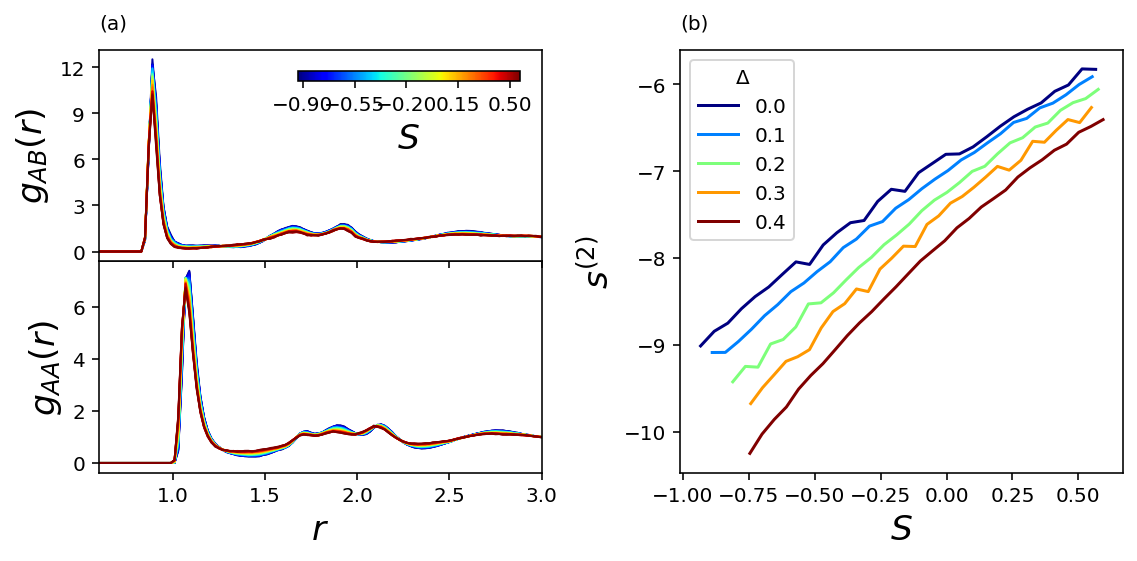

In [49]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator

cmap = cm.jet
norm = colors.Normalize(0.0, 0.4)

fig, axs = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)

divider = make_axes_locatable(axs[0])
axdiv = divider.append_axes("top", size="100%", pad=0.0, sharex=axs[0])

for delta in [0.0, 0.1, 0.2, 0.3, 0.4]:
    file = project.fn(f"prob_rearrang/rdfs-bin-softness-fire_delta-{delta}.pickle")
    data = pickle.load(open(file, "rb"))

    itemps = data["inv_t"]
    in_cuts = data["data"][0]["cuts"]
    f_a = 0.8
    f_b = 0.2
    r = data["r_bc"]
    phi = data["phi"]
    fits = []
    entropy = []

    if delta == 0.0:
        scmap = cm.jet # sns.color_palette("rocket", as_cmap=True)
        snorm = colors.Normalize(data["cuts"][0], data["cuts"][-1])

    for i in range(len(data["cuts"])):
        rearrang = [d["rearrang"][i] for d in data["data"]]
        g_a = data["data"][3]["rdfs"][in_cuts[i]]["g_a"]
        g_b = data["data"][3]["rdfs"][in_cuts[i]]["g_b"]
        s = pair_excess_entropy_binary(g_a, g_b, f_a, f_b, r, phi)
        entropy.append(s)
        p = np.polyfit(itemps, np.log(rearrang), 1)

        fits.append(p)

        if delta == 0.0:
            axs[0].plot(r, g_a, color=scmap(snorm(data["cuts"][i])), linewidth=1)
            axdiv.plot(r, g_b, color=scmap(snorm(data["cuts"][i])), linewidth=1)


    soft = pickle.load(open(project.fn(f"prob_rearrang/fit_softness_delta-{delta}.pickle"), "rb"))

    # axs[0].plot(entropy, fits[:,1]/(1.0 - delta/2.0**(1/6)), ".", linestyle="", label=f"{delta:.1f}", color=cmap(norm(delta)))
    axs[1].plot(data["cuts"], entropy, label=f"{delta:.1f}", color=cmap(norm(delta)))

axs[0].set_xlabel(r"$r$")
axs[0].set_ylabel(r"$g_{AA}(r)$")
axs[0].set_xlim(0.6, 3.0)
axdiv.set_ylabel(r"$g_{AB}(r)$")
plt.sca(axs[0])
# plt.legend(title=r"$S$")
make_axes_label(axdiv, "(a)", pos=(0, 1.1))
axs[0].yaxis.set_major_locator(MaxNLocator(nbins=5, prune='upper'))
axdiv.yaxis.set_major_locator(MaxNLocator(nbins=5))
plt.setp(axdiv.get_xticklabels(), visible=False)
cbaxes = axdiv.inset_axes([0.45, 0.85, 0.5, 0.05])
sm = cm.ScalarMappable(snorm, scmap)
ticks = np.linspace(-0.9, 0.5, 5)
plt.colorbar(sm, ticks=ticks, cax=cbaxes, label=r"$S$", orientation='horizontal')

# axs[0].set_xlim(0.8, 3.0)

axs[1].set_xlabel(r"$S$")
axs[1].set_ylabel(r"$s^{(2)}$")
plt.sca(axs[1])
plt.legend(title=r"$\Delta$")
make_axes_label(axs[1], "(b)")

plt.savefig("fig5.png", dpi=200)

In [69]:
snorm.vmin, snorm.vmax

(-0.9326989284305751, 0.5656828041666604)

In [79]:
np.linspace(-0.9, 0.5, 5)

array([-0.9 , -0.55, -0.2 ,  0.15,  0.5 ])

In [66]:
data["cuts"][::6], data["cuts"]

(array([-0.74580327, -0.46864662, -0.19148997,  0.08566668,  0.36282333]),
 array([-0.74580327, -0.6996105 , -0.65341772, -0.60722495, -0.56103217,
        -0.5148394 , -0.46864662, -0.42245385, -0.37626107, -0.3300683 ,
        -0.28387552, -0.23768275, -0.19148997, -0.1452972 , -0.09910442,
        -0.05291165, -0.00671887,  0.0394739 ,  0.08566668,  0.13185945,
         0.17805223,  0.224245  ,  0.27043778,  0.31663055,  0.36282333,
         0.4090161 ,  0.45520888,  0.50140165,  0.54759443,  0.5937872 ]))

In [24]:
data["inv_t"]

[2.2222222222222223,
 2.127659574468085,
 2.0408163265306123,
 1.9607843137254901,
 1.8867924528301885,
 1.8181818181818181,
 1.7241379310344829,
 1.639344262295082,
 1.5625]

In [27]:
data["cuts"]

array([-0.74580327, -0.6996105 , -0.65341772, -0.60722495, -0.56103217,
       -0.5148394 , -0.46864662, -0.42245385, -0.37626107, -0.3300683 ,
       -0.28387552, -0.23768275, -0.19148997, -0.1452972 , -0.09910442,
       -0.05291165, -0.00671887,  0.0394739 ,  0.08566668,  0.13185945,
        0.17805223,  0.224245  ,  0.27043778,  0.31663055,  0.36282333,
        0.4090161 ,  0.45520888,  0.50140165,  0.54759443,  0.5937872 ])

In [20]:
data['data'][2]

{'rdfs': {-0.933: {'g_a': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 4.82688121e-03, 4.54510927e-01, 3.39616816e+00,
          6.98806582e+00, 7.39529548e+00, 5.64883922e+00, 3.84319154e+00,
          2.589

# Figure 6 - Final energy and entropy fits

/tmp/ipykernel_2291988/1124404952.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2291988/1124404952.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2291988/1124404952.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2291988/1124404952.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2291988/1124404952.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2291988/1124404952.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2291988/1124404952.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2291988/1124404952.py:24: 

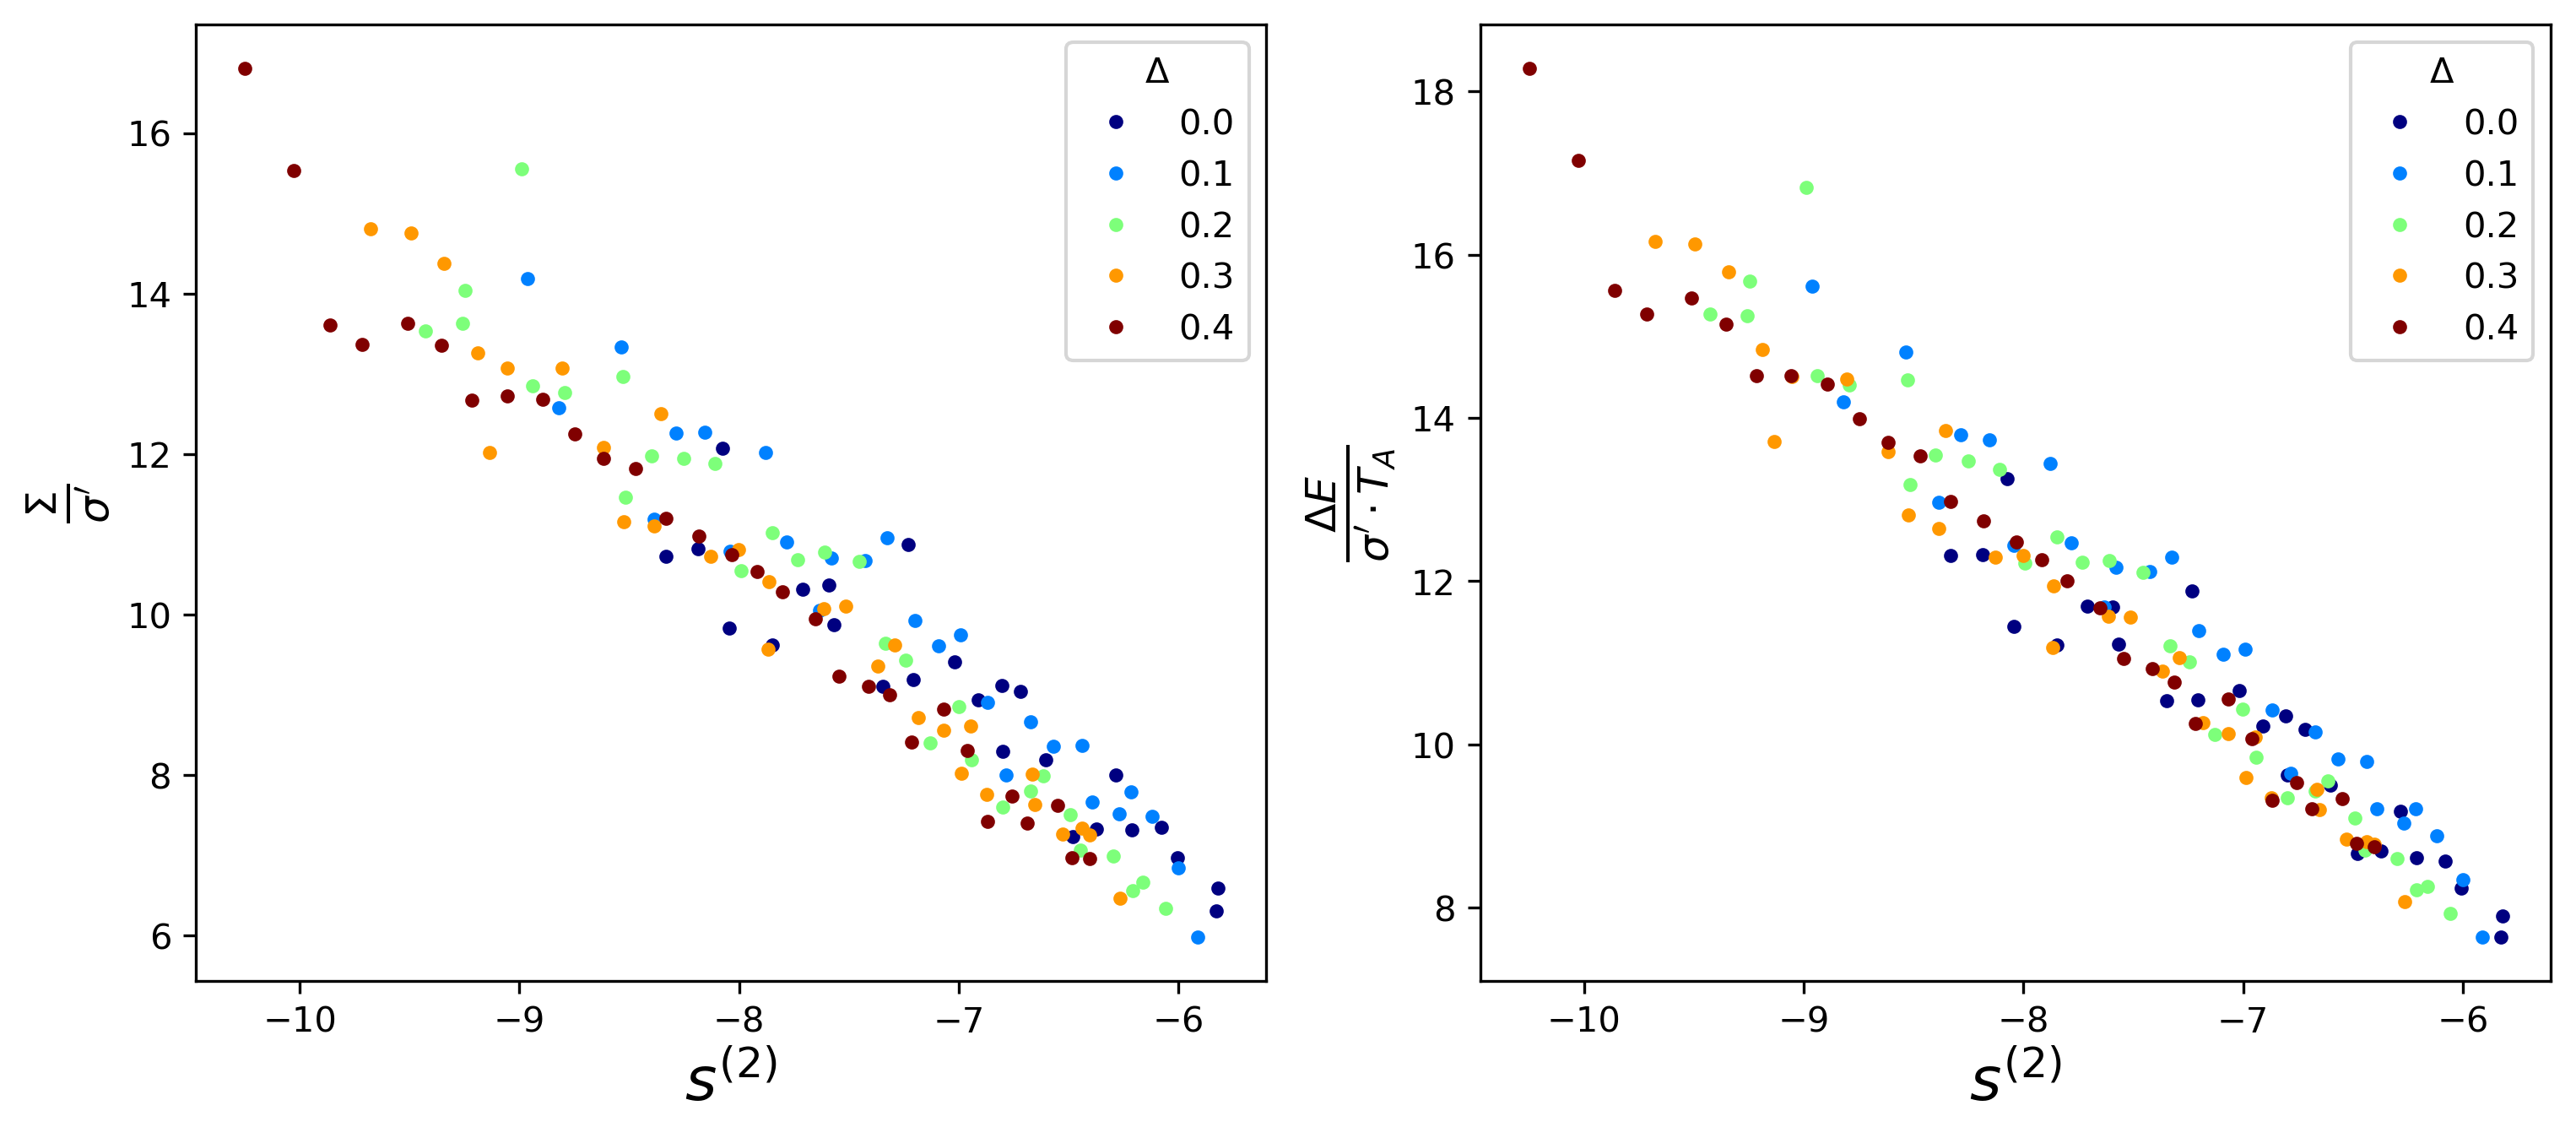

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=150)
cmap = cm.jet
norm = colors.Normalize(0.0, 0.4)

for delta in [0.0, 0.1, 0.2, 0.3, 0.4]:
    file = project.fn(f"prob_rearrang/rdfs-bin-softness-fire_delta-{delta}.pickle")

    data = pickle.load(open(file, "rb"))

    itemps = data["inv_t"]
    in_cuts = data["data"][0]["cuts"]
    f_a = 0.8
    f_b = 0.2
    r = data["r_bc"]
    phi = data["phi"]
    fits = []
    entropy = []
    for i in range(len(data["cuts"])):
        rearrang = [d["rearrang"][i] for d in data["data"]]
        g_a = data["data"][3]["rdfs"][in_cuts[i]]["g_a"]
        g_b = data["data"][3]["rdfs"][in_cuts[i]]["g_b"]
        s = pair_excess_entropy_binary(g_a, g_b, f_a, f_b, r, phi)
        entropy.append(s)
        p = np.polyfit(itemps, np.log(rearrang), 1)

        fits.append(p)

    soft = pickle.load(open(project.fn(f"prob_rearrang/fit_softness_delta-{delta}.pickle"), "rb"))

    def reject_outliers(sr, iq_range=0.8):
        pcnt = (1 - iq_range) / 2
        qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
        iqr = qhigh - qlow
        return sr[ (sr - median).abs() <= iqr]

    data1 = []
    keys = list(soft["data"].keys())
    for i in range(len(keys)-1):
        v1 = soft["data"][keys[i]]["p"]
        for j in range(i+1, len(keys)):
            v2 = soft["data"][keys[j]]["p"]
            data1.append(1/((v2[1] - v1[1]) / (v1[0] - v2[0])))
    T_a = np.mean(reject_outliers(pd.Series(data1)).to_numpy())

    fits = np.array(fits)

    axs[0].plot(entropy, fits[:,1]/(1.0 - delta/2.0**(1/6)), ".", linestyle="", label=f"{delta:.1f}", color=cmap(norm(delta)))
    axs[1].plot(entropy, -fits[:,0]/(1.0 - delta/2.0**(1/6))/T_a, ".", linestyle="", label=f"{delta:.1f}", color=cmap(norm(delta)))

axs[0].set_xlabel(r"$s^{(2)}$", size="xx-large")
axs[0].set_ylabel(r"$\frac{\Sigma}{\sigma'}$", size="xx-large")
plt.sca(axs[0])
plt.legend(title=r"$\Delta$")
# make_axes_label(axs[0], "(a)")

axs[1].set_xlabel(r"$s^{(2)}$", size="xx-large")
axs[1].set_ylabel(r"$\frac{\Delta E}{\sigma' \cdot T_A }$", size="xx-large")
plt.sca(axs[1])
plt.legend(title=r"$\Delta$")
# make_axes_label(axs[1], "(b)")

# plt.savefig("fig6-fixed.png", dpi=200)

/tmp/ipykernel_2797781/910307808.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2797781/910307808.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2797781/910307808.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2797781/910307808.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2797781/910307808.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2797781/910307808.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2797781/910307808.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_2797781/910307808.py:24: RuntimeW

25.994366300006206
24.222079395487988
21.965961204185792
18.99182574474734
17.60761939915538


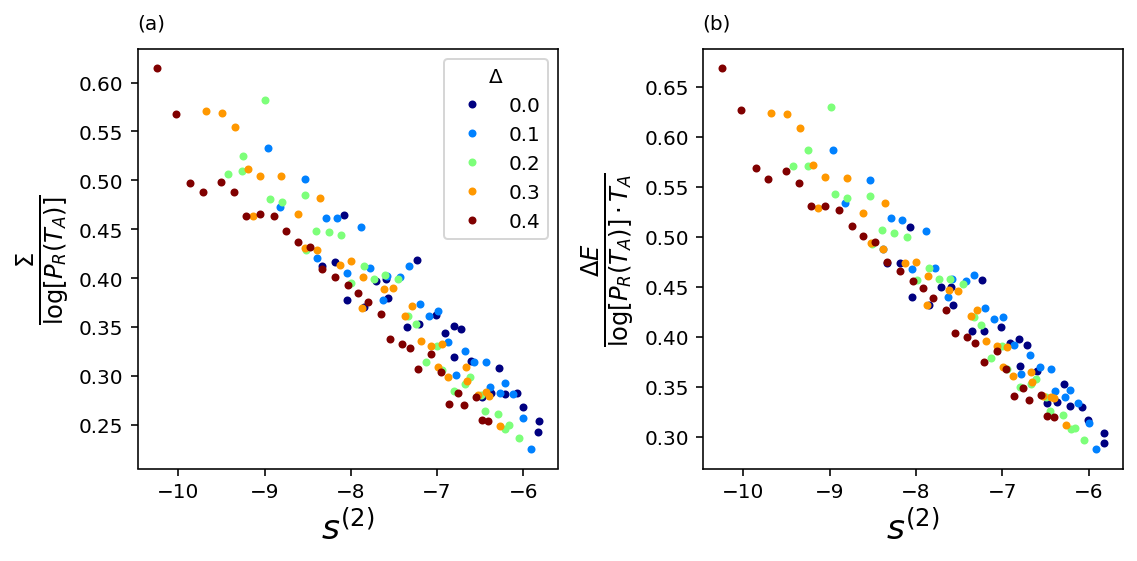

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)
cmap = cm.jet
norm = colors.Normalize(0.0, 0.4)

for delta in [0.0, 0.1, 0.2, 0.3, 0.4]:
    file = project.fn(f"prob_rearrang/rdfs-bin-softness-fire_delta-{delta}.pickle")

    data = pickle.load(open(file, "rb"))

    itemps = data["inv_t"]
    in_cuts = data["data"][0]["cuts"]
    f_a = 0.8
    f_b = 0.2
    r = data["r_bc"]
    phi = data["phi"]
    fits = []
    entropy = []
    for i in range(len(data["cuts"])):
        rearrang = [d["rearrang"][i] for d in data["data"]]
        g_a = data["data"][3]["rdfs"][in_cuts[i]]["g_a"]
        g_b = data["data"][3]["rdfs"][in_cuts[i]]["g_b"]
        s = pair_excess_entropy_binary(g_a, g_b, f_a, f_b, r, phi)
        entropy.append(s)
        p = np.polyfit(itemps, np.log(rearrang), 1)

        fits.append(p)

    soft = pickle.load(open(project.fn(f"prob_rearrang/fit_softness_delta-{delta}.pickle"), "rb"))

    def reject_outliers(sr, iq_range=0.8):
        pcnt = (1 - iq_range) / 2
        qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
        iqr = qhigh - qlow
        cond = (sr - median).abs() <= iqr
        return cond

    data1 = []
    keys = list(soft["data"].keys())
    for i in range(len(keys)-1):
        v1 = soft["data"][keys[i]]["p"]
        for j in range(i+1, len(keys)):
            v2 = soft["data"][keys[j]]["p"]
            data1.append(1/((v2[1] - v1[1]) / (v1[0] - v2[0])))
    ser_data = pd.Series(data1)
    cond = reject_outliers(ser_data)
    T_a = np.mean(ser_data[cond].to_numpy())
    P_rs = []
    for i in range(len(keys)):
        v1 = soft["data"][keys[i]]["p"]
        P_rs.append(np.exp(v1[1] - v1[0]/T_a))
    P_r = np.log(np.mean(P_rs))
    print(P_r)

    fits = np.array(fits)

    axs[0].plot(entropy, fits[:,1]/P_r, ".", linestyle="", label=f"{delta:.1f}", color=cmap(norm(delta)))
    axs[1].plot(entropy, -fits[:,0]/P_r/T_a, ".", linestyle="", label=f"{delta:.1f}", color=cmap(norm(delta)))

axs[0].set_xlabel(r"$s^{(2)}$")
axs[0].set_ylabel(r"$\frac{\Sigma}{\log[P_R(T_A)]}$")
plt.sca(axs[0])
plt.legend(title=r"$\Delta$")
make_axes_label(axs[0], "(a)")

axs[1].set_xlabel(r"$s^{(2)}$")
axs[1].set_ylabel(r"$\frac{\Delta E}{\log[P_R(T_A)] \cdot T_A }$")
plt.sca(axs[1])
# plt.legend(title=r"$\Delta$")
make_axes_label(axs[1], "(b)")

plt.savefig("fig6-pres.png", dpi=200)

In [15]:
1/soft["inv_t"], T_a

(array([2.01, 1.92, 1.82, 1.73, 1.67, 1.6 , 1.54, 1.48, 1.42]),
 2.232822698492146)

/tmp/ipykernel_3457872/1539257989.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_3457872/1539257989.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_3457872/1539257989.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_3457872/1539257989.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_3457872/1539257989.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_3457872/1539257989.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_3457872/1539257989.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_3457872/1539257989.py:24: 

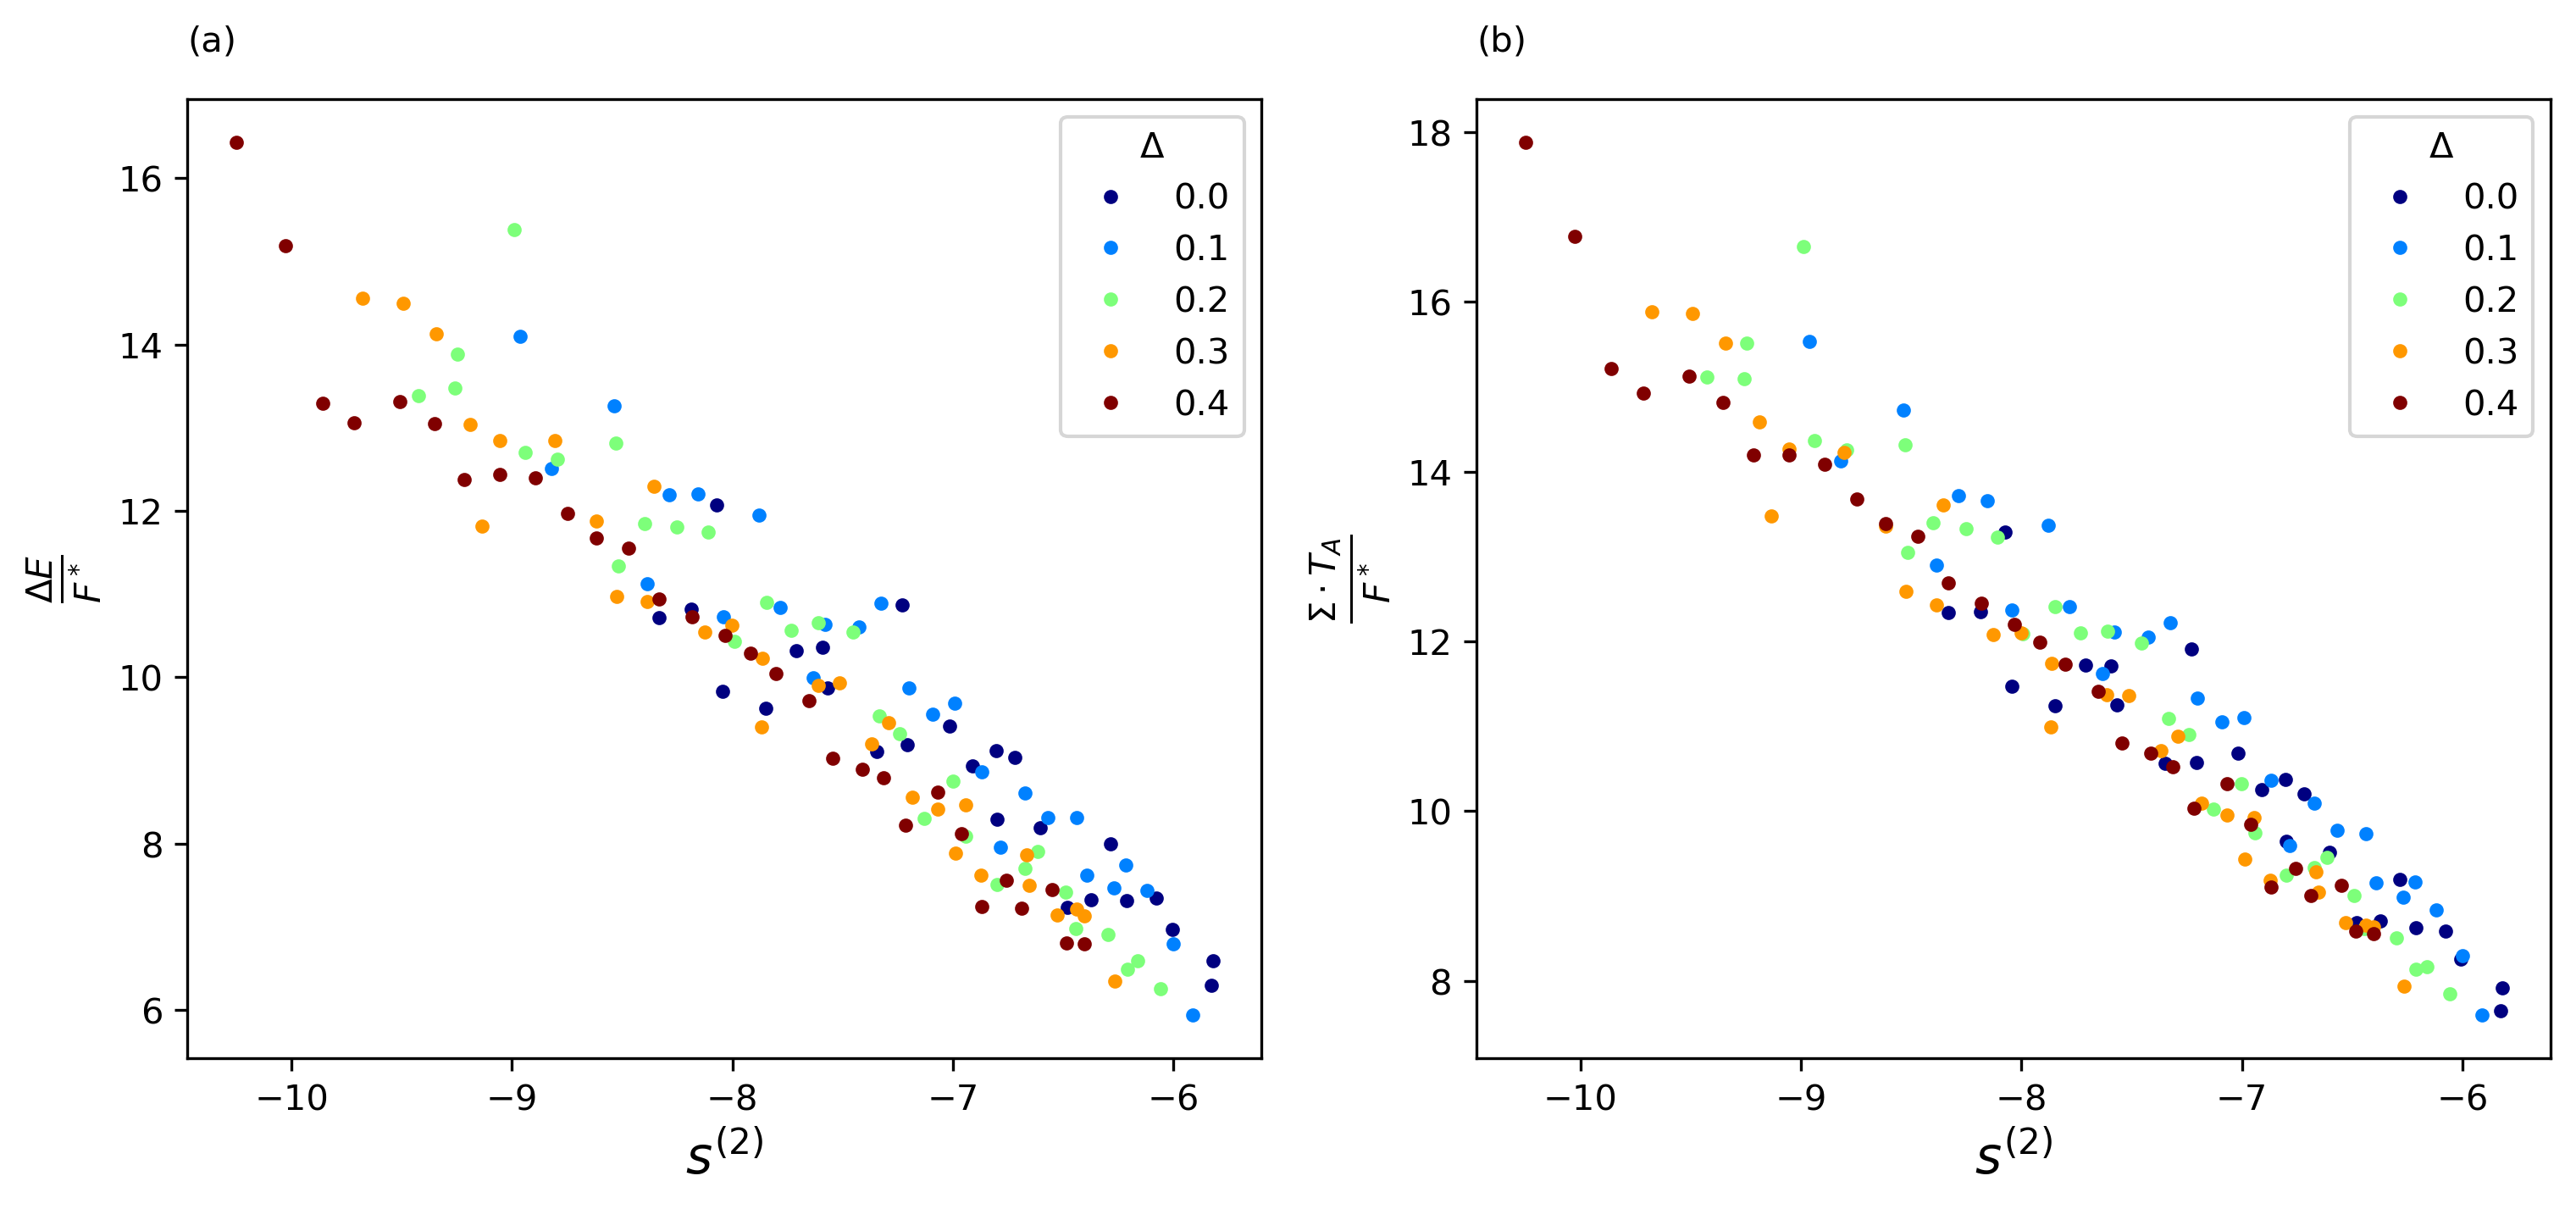

In [84]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=150)
cmap = cm.jet
norm = colors.Normalize(0.0, 0.4)
force_data = np.save(project.fn("structure/cage-force-sup.npy"))

for delta in [0.0, 0.1, 0.2, 0.3, 0.4]:
    file = project.fn(f"prob_rearrang/rdfs-bin-softness-fire_delta-{delta}.pickle")

    data = pickle.load(open(file, "rb"))

    itemps = data["inv_t"]
    in_cuts = data["data"][0]["cuts"]
    f_a = 0.8
    f_b = 0.2
    r = data["r_bc"]
    phi = data["phi"]
    fits = []
    entropy = []
    for i in range(len(data["cuts"])):
        rearrang = [d["rearrang"][i] for d in data["data"]]
        g_a = data["data"][3]["rdfs"][in_cuts[i]]["g_a"]
        g_b = data["data"][3]["rdfs"][in_cuts[i]]["g_b"]
        s = pair_excess_entropy_binary(g_a, g_b, f_a, f_b, r, phi)
        entropy.append(s)
        p = np.polyfit(itemps, np.log(rearrang), 1)

        fits.append(p)

    soft = pickle.load(open(project.fn(f"prob_rearrang/fit_softness_delta-{delta}.pickle"), "rb"))

    def reject_outliers(sr, iq_range=0.8):
        pcnt = (1 - iq_range) / 2
        qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
        iqr = qhigh - qlow
        return sr[ (sr - median).abs() <= iqr]

    data1 = []
    keys = list(soft["data"].keys())
    for i in range(len(keys)-1):
        v1 = soft["data"][keys[i]]["p"]
        for j in range(i+1, len(keys)):
            v2 = soft["data"][keys[j]]["p"]
            data1.append((v2[1] - v1[1]) / (v1[0] - v2[0]))
    T_a = np.mean(reject_outliers(pd.Series(data1)).to_numpy())

    fits = np.array(fits)

    axs[0].plot(entropy, fits[:,1]/(1.2/phi)**(1/3)/(1.0 - delta/2.0**(1/6)), ".", linestyle="", label=f"{delta:.1f}", color=cmap(norm(delta)))
    axs[1].plot(entropy, -fits[:,0]*T_a/(1.2/phi)**(1/3)/(1.0 - delta/2.0**(1/6)), ".", linestyle="", label=f"{delta:.1f}", color=cmap(norm(delta)))

axs[0].set_xlabel(r"$s^{(2)}$")
axs[0].set_ylabel(r"$\frac{\Delta E}{F^*}$")
plt.sca(axs[0])
plt.legend(title=r"$\Delta$")
make_axes_label(axs[0], "(a)")

axs[1].set_xlabel(r"$s^{(2)}$")
axs[1].set_ylabel(r"$\frac{\Sigma \cdot T_A }{F^*}$")
plt.sca(axs[1])
plt.legend(title=r"$\Delta$")
make_axes_label(axs[1], "(b)")

plt.savefig("fig6-alt.png", dpi=200)

/tmp/ipykernel_3457872/3155438747.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_3457872/3155438747.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_3457872/3155438747.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_3457872/3155438747.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_3457872/3155438747.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_3457872/3155438747.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_3457872/3155438747.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_3457872/3155438747.py:24: 

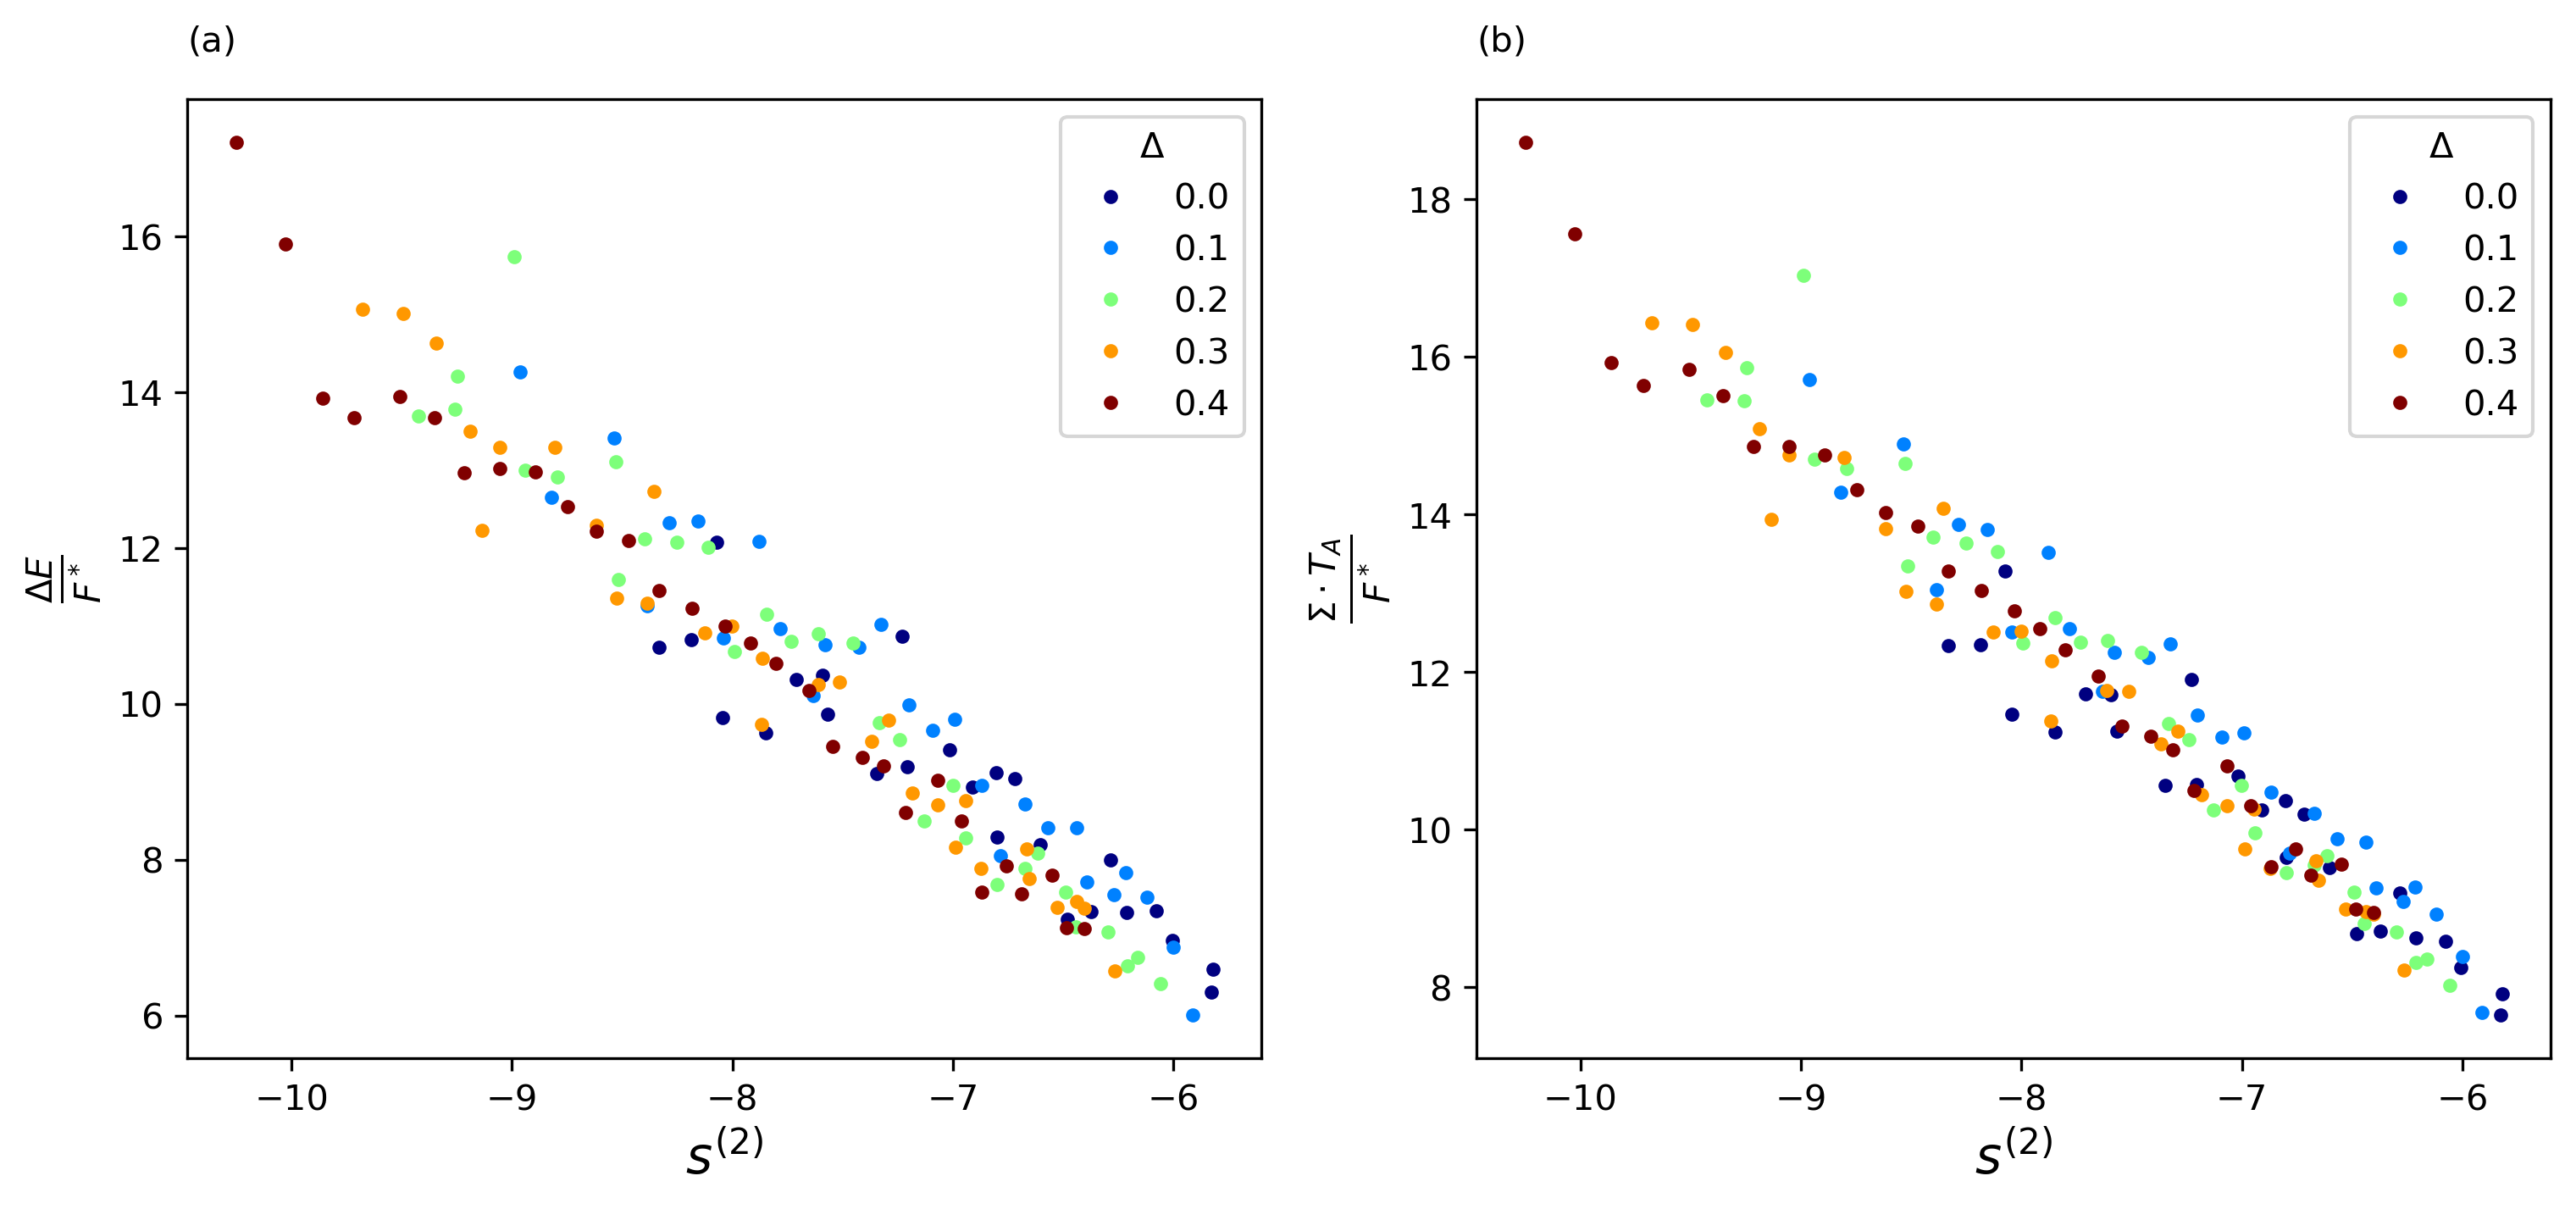

In [85]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=150)
cmap = cm.jet
norm = colors.Normalize(0.0, 0.4)

for delta in [0.0, 0.1, 0.2, 0.3, 0.4]:
    file = project.fn(f"prob_rearrang/rdfs-bin-softness-fire_delta-{delta}.pickle")

    data = pickle.load(open(file, "rb"))

    itemps = data["inv_t"]
    in_cuts = data["data"][0]["cuts"]
    f_a = 0.8
    f_b = 0.2
    r = data["r_bc"]
    phi = data["phi"]
    fits = []
    entropy = []
    for i in range(len(data["cuts"])):
        rearrang = [d["rearrang"][i] for d in data["data"]]
        g_a = data["data"][3]["rdfs"][in_cuts[i]]["g_a"]
        g_b = data["data"][3]["rdfs"][in_cuts[i]]["g_b"]
        s = pair_excess_entropy_binary(g_a, g_b, f_a, f_b, r, phi)
        entropy.append(s)
        p = np.polyfit(itemps, np.log(rearrang), 1)

        fits.append(p)

    soft = pickle.load(open(project.fn(f"prob_rearrang/fit_softness_delta-{delta}.pickle"), "rb"))

    def reject_outliers(sr, iq_range=0.8):
        pcnt = (1 - iq_range) / 2
        qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
        iqr = qhigh - qlow
        return sr[ (sr - median).abs() <= iqr]

    data1 = []
    keys = list(soft["data"].keys())
    for i in range(len(keys)-1):
        v1 = soft["data"][keys[i]]["p"]
        for j in range(i+1, len(keys)):
            v2 = soft["data"][keys[j]]["p"]
            data1.append((v2[1] - v1[1]) / (v1[0] - v2[0]))
    T_a = np.mean(reject_outliers(pd.Series(data1)).to_numpy())

    fits = np.array(fits)

    axs[0].plot(entropy, fits[:,1]*(1.2/phi)**(1/3)/(1.0 - delta/2.0**(1/6)), ".", linestyle="", label=f"{delta:.1f}", color=cmap(norm(delta)))
    axs[1].plot(entropy, -fits[:,0]*T_a*(1.2/phi)**(1/3)/(1.0 - delta/2.0**(1/6)), ".", linestyle="", label=f"{delta:.1f}", color=cmap(norm(delta)))

axs[0].set_xlabel(r"$s^{(2)}$")
axs[0].set_ylabel(r"$\frac{\Delta E}{F^*}$")
plt.sca(axs[0])
plt.legend(title=r"$\Delta$")
make_axes_label(axs[0], "(a)")

axs[1].set_xlabel(r"$s^{(2)}$")
axs[1].set_ylabel(r"$\frac{\Sigma \cdot T_A }{F^*}$")
plt.sca(axs[1])
plt.legend(title=r"$\Delta$")
make_axes_label(axs[1], "(b)")

plt.savefig("fig6-alt.png", dpi=200)

/tmp/ipykernel_1370337/3342647942.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_1370337/3342647942.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_1370337/3342647942.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_1370337/3342647942.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_1370337/3342647942.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_1370337/3342647942.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_1370337/3342647942.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_1370337/3342647942.py:24: 

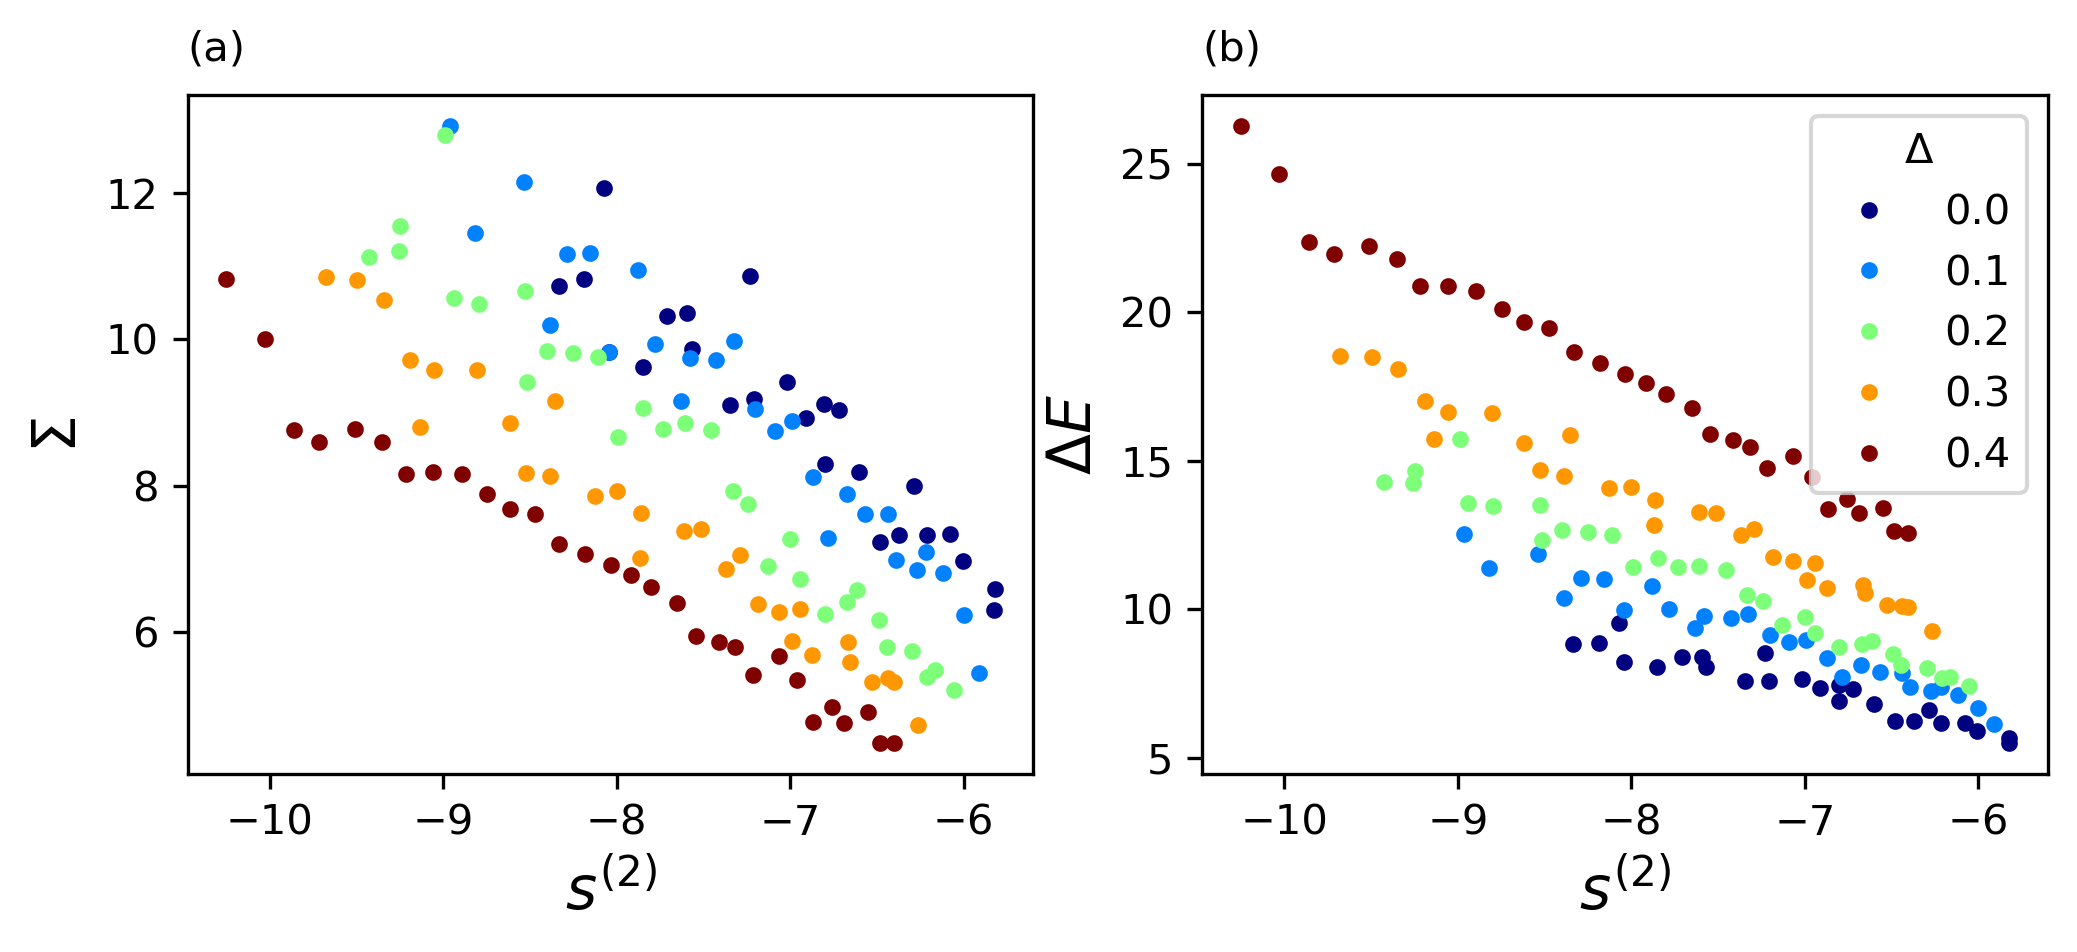

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), dpi=150)
cmap = cm.jet
norm = colors.Normalize(0.0, 0.4)

for delta in [0.0, 0.1, 0.2, 0.3, 0.4]:
    file = project.fn(f"prob_rearrang/rdfs-bin-softness-fire_delta-{delta}.pickle")

    data = pickle.load(open(file, "rb"))

    itemps = data["inv_t"]
    in_cuts = data["data"][0]["cuts"]
    f_a = 0.8
    f_b = 0.2
    r = data["r_bc"]
    phi = data["phi"]
    fits = []
    entropy = []
    for i in range(len(data["cuts"])):
        rearrang = [d["rearrang"][i] for d in data["data"]]
        g_a = data["data"][3]["rdfs"][in_cuts[i]]["g_a"]
        g_b = data["data"][3]["rdfs"][in_cuts[i]]["g_b"]
        s = pair_excess_entropy_binary(g_a, g_b, f_a, f_b, r, phi)
        entropy.append(s)
        p = np.polyfit(itemps, np.log(rearrang), 1)

        fits.append(p)

    soft = pickle.load(open(project.fn(f"prob_rearrang/fit_softness_delta-{delta}.pickle"), "rb"))

    def reject_outliers(sr, iq_range=0.8):
        pcnt = (1 - iq_range) / 2
        qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
        iqr = qhigh - qlow
        return sr[ (sr - median).abs() <= iqr]

    data1 = []
    keys = list(soft["data"].keys())
    for i in range(len(keys)-1):
        v1 = soft["data"][keys[i]]["p"]
        for j in range(i+1, len(keys)):
            v2 = soft["data"][keys[j]]["p"]
            data1.append((v2[1] - v1[1]) / (v1[0] - v2[0]))
    T_a = np.mean(reject_outliers(pd.Series(data1)).to_numpy())

    fits = np.array(fits)

    axs[0].plot(entropy, fits[:,1], ".", linestyle="", label=f"{delta:.1f}", color=cmap(norm(delta)))
    axs[1].plot(entropy, -fits[:,0], ".", linestyle="", label=f"{delta:.1f}", color=cmap(norm(delta)))

axs[1].set_xlabel(r"$s^{(2)}$")
axs[1].set_ylabel(r"$\Delta E$")
plt.sca(axs[0])
# plt.legend(title=r"$\Delta$")
make_axes_label(axs[0], "(a)")

axs[0].set_xlabel(r"$s^{(2)}$")
axs[0].set_ylabel(r"$\Sigma$")
plt.sca(axs[1])
plt.legend(title=r"$\Delta$")
make_axes_label(axs[1], "(b)")

# plt.savefig("fig6-alt2.png", dpi=200)

# Figure 6 - Diffusion coefficients

In [ ]:
def plot_reduced_diffusion_coefficient_excess_entropy(ax, diff_data, excess_entropy_folder, legend=True):
    cmap = cm.jet
    norm = mpl.colors.Normalize(vmin=0, vmax=0.4)
    
    for delta, d in diff_data.items():
        phi = delta_to_phi(float(delta))
        with open(excess_entropy_folder + f"/excess-entropy-binary_delta-{delta}.pickle", "rb") as f:
            excess_entropy_data = pickle.load(f)
        plot_data = []
        for temp, data in excess_entropy_data.items():
            plot_data.append(excess_entropy_data[temp]["excess_entropy"])
        ax.plot(np.array(plot_data), np.array(d[()]["D"])*phi**(1/3)*np.sqrt(d[()]["inv_temp"]), label=f"{delta}", color=cmap(norm(float(delta))))
    if legend:
        ax.legend(title=r"$\Delta$")
    ax.set_yscale('log')
    ax.set_xlabel(r"$s^{(2)}$")
    ax.set_ylabel(r"$D^*_A$")

fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=150) # , sharey=True, gridspec_kw={'hspace': 0, 'wspace': 0}
plot_reduced_diffusion_coefficient_softness(axs[0], np.load(project.fn("dynamics/diffusion_coefficients.npz"), allow_pickle=True), project.fn("structure"))
make_axes_label(axs[0], "(a)")
plot_reduced_diffusion_coefficient_excess_entropy(axs[1], np.load(project.fn("dynamics/diffusion_coefficients.npz"), allow_pickle=True), project.fn("structure"))
make_axes_label(axs[1], "(b)")

plt.savefig("fig2.png", dpi=200)

In [15]:
D

array({'inv_temp': [0.7042253521126761, 0.6756756756756757, 0.6493506493506493, 0.625, 0.5988023952095809, 0.5780346820809249, 0.5494505494505494, 0.5208333333333334, 0.49751243781094534, 0.47393364928909953, 0.45454545454545453, 0.42372881355932207, 0.3968253968253968, 0.35335689045936397, 0.31746031746031744, 0.26525198938992045, 0.22727272727272727, 0.19880715705765406, 0.17667844522968199, 0.1589825119236884], 'D': [0.00017471377000020344, 0.00028869891395453954, 0.000467107672695731, 0.0006221529972250639, 0.0009107358602967473, 0.0011637728356131748, 0.0016921197297370518, 0.002271530303616029, 0.0027111951497796037, 0.0034190283697159572, 0.004340149799619321, 0.005593224096647133, 0.007005497796172356, 0.010126151773852851, 0.01303446952267353, 0.020514542827505835, 0.028467030994709017, 0.03634938136407272, 0.04495550119160138, 0.05317917588418248]},
      dtype=object)

In [ ]:
fig, ax = plt.subplots(, dpi=150)
cmap = cm.jet
norm = colors.Normalize(0.0, 0.4)

# extract diffusion coefficients
diffusion_coefficients = np.load(project.fn("dynamics/diffusion_coefficients.npz"), allow_pickle=True)

for delta, D_data in diffusion_coefficients.items():
    file = project.fn(f"prob_rearrang/rdfs-bin-softness_delta-{delta}.pickle")

    D = D_data[()]["D"]


    data = pickle.load(open(file, "rb"))

    itemps = data["inv_t"]
    in_cuts = data["data"][0]["cuts"]
    f_a = 0.8
    f_b = 0.2
    r = data["r_bc"]
    phi = data["phi"]
    for j in range(len(itemps)):
        fits = []
        entropy = []
        for i in range(len(data["cuts"])):
            rearrang = [d["rearrang"][i] for d in data["data"]]
            g_a = data["data"][j]["rdfs"][in_cuts[i]]["g_a"]
            g_b = data["data"][j]["rdfs"][in_cuts[i]]["g_b"]
            s = pair_excess_entropy_binary(g_a, g_b, f_a, f_b, r, phi)
            # s = pair_excess_entropy_binary(0.8*g_a + 0.2*g_b, r, phi)
            entropy.append(s)
            p = np.polyfit(itemps, np.log(rearrang), 1)

            fits.append(p)

        soft = pickle.load(open(project.fn(f"prob_rearrang/fit_softness_delta-{delta}.pickle"), "rb"))

        def reject_outliers(sr, iq_range=0.8):
            pcnt = (1 - iq_range) / 2
            qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
            iqr = qhigh - qlow
            return sr[ (sr - median).abs() <= iqr]

        data1 = []
        keys = list(soft["data"].keys())
        for i in range(len(keys)-1):
            v1 = soft["data"][keys[i]]["p"]
            for j in range(i+1, len(keys)):
                v2 = soft["data"][keys[j]]["p"]
                data1.append((v2[1] - v1[1]) / (v1[0] - v2[0]))
        T_a = np.mean(reject_outliers(pd.Series(data1)).to_numpy())

        fits = np.array(fits)

        axs[0].plot(entropy, D[j]*phi**(1/3)*np.sqrt(), ".", linestyle="", label=f"{delta:.1f}", color=cmap(norm(delta)))

axs[0].set_xlabel(r"$s^{(2)}$")
axs[0].set_ylabel(r"$\Delta E$")

In [38]:
file = project.fn(f"prob_rearrang/rdfs-bin-softness_delta-{delta}.pickle")

In [39]:
data = pickle.load(open(file, "rb"))


In [40]:
list(data["data"][0].keys())

['rdfs', 'cuts', 'rearrang']

In [43]:
idx = data["data"][0]["cuts"][0]
print(idx)
data["data"][0]['rdfs'][idx].keys()

-0.746


dict_keys(['g_a', 'g_b'])